In [104]:
# ipython magic


%matplotlib inline

from B00_util import *
%reload_ext autoreload
%autoreload 2

# Get  trigger positive data for ML4

In [2]:
dataset = extractDataset("B00_ML4TrgPos_Y2016", {  "AllMed",  "HF","NonVAMed", "DispensedDrug","Only10daysPrior30DaysAfter"})

TABLE_CATALOG TABLE_SCHEMA  \
0   ORD_Singh_201911038D         Dflt   
1   ORD_Singh_201911038D         Dflt   
2   ORD_Singh_201911038D         Dflt   
3   ORD_Singh_201911038D         Dflt   
4   ORD_Singh_201911038D         Dflt   
5   ORD_Singh_201911038D         Dflt   
6   ORD_Singh_201911038D         Dflt   
7   ORD_Singh_201911038D         Dflt   
8   ORD_Singh_201911038D         Dflt   
9   ORD_Singh_201911038D         Dflt   
10  ORD_Singh_201911038D         Dflt   
11  ORD_Singh_201911038D         Dflt   
12  ORD_Singh_201911038D         Dflt   
13  ORD_Singh_201911038D         Dflt   

                                           TABLE_NAME  TABLE_TYPE  
0                 _B00_ML4TrgPos_Y201621_01_04_cohort  BASE TABLE  
1                    _B00_ML4TrgPos_Y201621_05_04_Rad  BASE TABLE  
2                    _B00_ML4TrgPos_Y201621_04_04_Lab  BASE TABLE  
3           _B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat  BASE TABLE  
4           _B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed  BASE TABLE  
5   _B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...  BASE TABLE  
6             _B00_ML4TrgPos_Y201621_06_Med_08_AllMed  BASE TABLE  
7                   _B00_ML4TrgPos_Y201621_08_Consult  BASE TABLE  
8                       _B00_ML4TrgPos_Y201621_12_ICD  BASE TABLE  
9                     _B00_ML4TrgPos_Y201621_14_Vital  BASE TABLE  
10            _B00_ML4TrgPos_Y201622_30_Note_withRole  BASE TABLE  
11                       _B00_ML4TrgPos_Y201621_16_HF  BASE TABLE  
12         _B00_ML4TrgPos_Y201621_01_04_Demorgraphics  BASE TABLE  
13  _B00_ML4TrgPos_Y201621_05_04_Rad_Only10daysPri...  BASE TABLE

dict_keys(['cohort', 'Rad', 'Lab', 'RxOutpat', 'Consult', 'ICD', 'Vital', 'withRole', 'Demorgraphics'])


#  Cohorts

In [107]:
cohorts = dataset['cohort']
dizzy_cohort_df, abdpain_cohort_df = separate_cohorts(cohorts)

Dizzy cohort =  (193, 12)  Abdpain cohort =  (915, 12)
Dizzy cohort df =  (193, 19)  Abdpain cohort df =  (915, 19)


#  Demographic data
- for dizzy df, there are four labeled patients for which we do not have demo or cohort records

In [108]:
demog = dataset['Demorgraphics']
dizzy_demo_coded, abdpain_demo_coded = separate_demog(demog,dizzy_cohort_df,abdpain_cohort_df)
print('Dizzy demo df = ', dizzy_demo_coded.shape, ' Abdpain demo df = ', abdpain_demo_coded.shape)    

dizzy demographics shape =  (168, 7)
abdpain demographics shape =  (783, 7)
Dizzy demo df =  (168, 9)  Abdpain demo df =  (783, 9)


#  ED vitals
- vitals during ED visit
    - systolic, diastolic (per visit)
    - pulse, respiration, pulse oximetry, pain, temperature (count, min, max, first for multiple readings)


In [109]:
vitals = dataset['Vital']

dizzy_EDvitals_df,abdpain_EDvitals_df = separate_cohorts_EDvitals(vitals,dizzy_cohort_df,abdpain_cohort_df)
print(dizzy_EDvitals_df.shape,abdpain_EDvitals_df.shape)

(2288, 14) (13373, 14)
(1371, 26) (9815, 26)


# Vitals during the hospitalizations subsequent to ED visits

In [110]:
# get vitals from hospital visits
dizzy_hosp_vitals_df,abdpain_hosp_vitals_df = separate_cohorts_hosp_vitals(vitals,dizzy_cohort_df,abdpain_cohort_df)
print(dizzy_hosp_vitals_df.shape,abdpain_hosp_vitals_df.shape)

(25219, 14) (94585, 14)
(1481, 31) (35005, 31)


# Consults  ordered during ED visit
- count up top three consult depts for dizzy
- count up top seven consult depts for abdpain

Cardiology consult count useful for dizzy
EKG consult count useful for abdpain

In [113]:
consults = dataset['Consult']
dizzy_consults, abdpain_consults = separate_cohorts_consults(consults,dizzy_cohort_df,abdpain_cohort_df)

# look at which departments are being consulted (pick top N)
dizzy_topN_consult_counts = topN_consult_counts(dizzy_consults,dizzy_demo_coded,3)
abdpain_topN_consult_counts = topN_consult_counts(abdpain_consults,abdpain_demo_coded,7)
print(dizzy_topN_consult_counts.shape, abdpain_topN_consult_counts.shape)

(115, 13) (416, 13)
(168, 4) (783, 8)


# Imaging features
- ct images: - how many ordered, how many w/contrast, how many abnormal
- xr images: how many ordered, how many abnormal
- us images: how many ordered, how many abnormal


In [112]:
# get imaging records for dizzy and abdpain
images = dataset['Rad']

dizzy_images, abdpain_images = separate_cohorts_images(images,dizzy_cohort_df,abdpain_cohort_df)
print(dizzy_images.shape, abdpain_images.shape)

(174, 9) (820, 11)



# Labs: ED visit only
- for select labs, get count, min, max, abnormal_count

In [114]:
labs = dataset['Lab']
dizzy_labs, abdpain_labs = separate_cohorts_labs(labs,dizzy_cohort_df,abdpain_cohort_df)
print(dizzy_labs.shape,abdpain_labs.shape)

labs = ['WBC','glucose','albumin','potassium','calcium','lact','chloride','bun','creat','troponin','CO2','ast','alt',
        'alkphos','lipase','amylase','hgb']
lab_fns = ['matches_' + lab + '_loinc' for lab in labs]

# collect all labs and then filter later on
dizzy_lab_dict = {}
abdpain_lab_dict = {}
for i in range(len(labs)):
    lab, labfn = labs[i], lab_fns[i]
    dizzy_lab_dict[lab] = get_labs_data(dizzy_labs,lab,eval(labfn),dizzy_demo_coded)
    abdpain_lab_dict[lab] = get_labs_data(abdpain_labs,lab,eval(labfn),abdpain_demo_coded)


(8039, 14) (48930, 14)


# History
- for dizzy, use Viral's ICD list
- for abdpain, use Adel's ICD list refined by Andy Z

In [10]:
icds = dataset['ICD']
dizzy_icds,abdpain_icds = separate_cohorts_icds(icds,dizzy_cohort_df,abdpain_cohort_df)
print(dizzy_icds.shape,abdpain_icds.shape)

# get dizzy risk factors
dizzy_rf_df = get_dizzy_rf(dizzy_icds,dizzy_cohort_df)
print(dizzy_rf_df.shape)

# get abdpain risk factors
abdpain_rf_df = get_abdpain_rf(abdpain_icds,abdpain_cohort_df)
print(abdpain_rf_df.shape)

(125546, 7) (429443, 7)
(168, 10)
(795, 8)


# Get labeled data

In [11]:
dizzy_df, dizzy_labels_df = retrieveLabels_dizzy(dizzy_fname)
abdpain_df, abdpain_labels_df = retrieveLabels_abdpain(abdpain_fname)
print(dizzy_labels_df.shape,abdpain_labels_df.shape)

print(dizzy_labels_df.label.value_counts())
print(abdpain_labels_df.label.value_counts())
print('\nPPV for dizzy = ', dizzy_labels_df[dizzy_labels_df.label=='MOD'].shape[0]/dizzy_labels_df.shape[0])
print('PPV for abdpain = ', np.round(abdpain_labels_df[abdpain_labels_df.label=='MOD'].shape[0]/abdpain_labels_df.shape[0],3))

(100, 2) (104, 2)
NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: label, dtype: int64
NoMOD    73
MOD      31
Name: label, dtype: int64

PPV for dizzy =  0.38
PPV for abdpain =  0.298


# Labeled versions of all dataframes

In [12]:
# labeled versions of the cohort datasets
dizzy_cohort_df_labeled = pd.merge(dizzy_cohort_df,dizzy_labels_df,on='PtSSN')
abdpain_cohort_df_labeled = pd.merge(abdpain_cohort_df,abdpain_labels_df,on='PtSSN')
print('Cohort:',dizzy_cohort_df_labeled.shape, abdpain_cohort_df_labeled.shape)

# labeled versions of demog datasets
dizzy_demo_coded_labeled = pd.merge(dizzy_demo_coded,dizzy_labels_df,on='PtSSN')
abdpain_demo_coded_labeled = pd.merge(abdpain_demo_coded,abdpain_labels_df,on='PtSSN')
print('Demo:', dizzy_demo_coded_labeled.shape,abdpain_demo_coded_labeled.shape)

# get labeled version of ED vitals
dizzy_EDvitals_labeled = pd.merge(dizzy_EDvitals_df,dizzy_labels_df,on='PtSSN')
abdpain_EDvitals_labeled = pd.merge(abdpain_EDvitals_df,abdpain_labels_df,on='PtSSN')
print('EDVitals:', dizzy_EDvitals_labeled.shape,abdpain_EDvitals_labeled.shape)

# get labeled versions of hosp vitals
dizzy_hosp_vitals_labeled = pd.merge(dizzy_hosp_vitals_df,dizzy_labels_df,on='PtSSN')
abdpain_hosp_vitals_labeled = pd.merge(abdpain_hosp_vitals_df,abdpain_labels_df,on='PtSSN')
print('Hosp vitals:', dizzy_hosp_vitals_labeled.shape,abdpain_hosp_vitals_labeled.shape)

# get labeled versions of consults
dizzy_topN_consult_counts_labeled = pd.merge(dizzy_topN_consult_counts,dizzy_labels_df,on='PtSSN').fillna(0)
abdpain_topN_consult_counts_labeled = pd.merge(abdpain_topN_consult_counts,abdpain_labels_df,on='PtSSN').fillna(0)
print('Consults: ', dizzy_topN_consult_counts_labeled.shape,abdpain_topN_consult_counts_labeled.shape)

# get labeled version of images
dizzy_images_labeled = pd.merge(dizzy_images,dizzy_labels_df,on='PtSSN')
abdpain_images_labeled = pd.merge(abdpain_images,abdpain_labels_df,on='PtSSN')
print('Imaging:', dizzy_images_labeled.shape,abdpain_images_labeled.shape)

# get labeled versions of risk factors
dizzy_rf_df_labeled = pd.merge(dizzy_rf_df,dizzy_labels_df,on='PtSSN')
abdpain_rf_df_labeled = pd.merge(abdpain_rf_df,abdpain_labels_df,on='PtSSN')
print('Risk Factors:', dizzy_rf_df_labeled.shape,abdpain_rf_df_labeled.shape)

# get labeled versions of labs

# collect all labs and then filter later on
dizzy_lab_dict_labeled = {}
abdpain_lab_dict_labeled = {}
for i in range(len(labs)):
    lab, labfn = labs[i], lab_fns[i]
    dizzy_lab_dict_labeled[lab] = pd.merge(dizzy_lab_dict[lab],dizzy_labels_df,on='PtSSN')
    abdpain_lab_dict_labeled[lab] = pd.merge(abdpain_lab_dict[lab],abdpain_labels_df,on='PtSSN')
    

Cohort: (109, 20) (131, 20)
Demo: (96, 10) (104, 10)
EDVitals: (81, 27) (109, 27)
Hosp vitals: (98, 27) (119, 27)
Consults:  (96, 5) (104, 9)
Imaging: (100, 10) (115, 12)
Risk Factors: (96, 11) (104, 9)


# Check if any of the features  are useful for MOD prediction
- 

In [13]:
# cohort fields ttest
cohort_fields = ['ed_duration', 'ed_first_inp_delta','sum_hosp_stay', 'num_hosp','num_ED_visits']
cohort_ftypes = ['c','c','c','c','c']
dizzy_cohort_sig = ttest_fields(dizzy_cohort_df_labeled[dizzy_cohort_df_labeled.label.isin(['MOD','NoMOD'])],cohort_fields,cohort_ftypes)
print('Dizziness cohort:', dizzy_cohort_sig)
abdpain_cohort_sig = ttest_fields(abdpain_cohort_df_labeled,cohort_fields,cohort_ftypes)
print('Abdpain cohort:',abdpain_cohort_sig)

# demo field ttest
demo_fields = dizzy_demo_coded.columns[1:]
demo_ftypes = ['c','d','d','d','d','d','d','d']
dizzy_demo_sig = ttest_fields(dizzy_demo_coded_labeled[dizzy_demo_coded_labeled.label.isin(['MOD','NoMOD'])],demo_fields,demo_ftypes,show=False)
print('Dizziness demo:',dizzy_demo_sig)
abdpain_demo_sig = ttest_fields(abdpain_demo_coded_labeled,demo_fields,demo_ftypes,show=False)
print('Abdpain demo:',abdpain_demo_sig)

# ED Vitals ttest
# do a ttest with all fields with respect to MOD
ED_vitals_fields= dizzy_EDvitals_labeled.columns[3:-1]
ED_vitals_ftypes = len(ED_vitals_fields)*['c']
dizzy_vitals_sig = ttest_fields(dizzy_EDvitals_labeled[dizzy_EDvitals_labeled.label.isin(['MOD','NoMOD'])],ED_vitals_fields,ED_vitals_ftypes)
print('Dizziness ED vitals:',dizzy_vitals_sig)
abdpain_vitals_sig = ttest_fields(abdpain_EDvitals_labeled,ED_vitals_fields,ED_vitals_ftypes)
print('Abdpain ED vitals:',abdpain_vitals_sig)

# Hosp vitals ttest
# do a ttest with all fields with respect to MOD
hosp_vitals_fields = dizzy_hosp_vitals_df.columns[2:]
hosp_vitals_ftypes = len(hosp_vitals_fields) * ['c']
dizzy_hosp_vitals_sig = ttest_fields(dizzy_hosp_vitals_labeled[dizzy_hosp_vitals_labeled.label.isin(['MOD','NoMOD'])],hosp_vitals_fields,hosp_vitals_ftypes)
print('Dizziness hosp vitals:',dizzy_hosp_vitals_sig)
abdpain_hosp_vitals_sig = ttest_fields(abdpain_hosp_vitals_labeled,hosp_vitals_fields,hosp_vitals_ftypes)
print('Abdpain hosp vitals:',abdpain_hosp_vitals_sig)

# Consult ttest
dizzy_ccounts_fields = dizzy_topN_consult_counts_labeled.columns[1:-1]
dizzy_ccounts_ftypes = ['d','d','d']
dizzy_consults_sig = ttest_fields(dizzy_topN_consult_counts_labeled,dizzy_ccounts_fields,dizzy_ccounts_ftypes)
print('Dizziness consults: ',dizzy_consults_sig)
abdpain_ccounts_fields = abdpain_topN_consult_counts_labeled.columns[1:-1]
abdpain_ccounts_ftypes = len(abdpain_ccounts_fields) * ['d']
abdpain_consults_sig = ttest_fields(abdpain_topN_consult_counts_labeled,abdpain_ccounts_fields,abdpain_ccounts_ftypes)
print('Abdpain consults: ',abdpain_consults_sig)

# Imaging ttest
dizzy_images_fields = dizzy_images_labeled.columns[2:-1]
dizzy_images_ftypes = len(dizzy_images_fields) * ['c']
dizzy_images_sig = ttest_fields(dizzy_images_labeled[dizzy_images_labeled.label.isin(['MOD','NoMOD'])],dizzy_images_fields,dizzy_images_ftypes)
print('Dizziness imaging: ', dizzy_images_sig)
abdpain_images_fields = abdpain_images_labeled.columns[2:-1]
abdpain_images_ftypes = len(abdpain_images_fields) * ['c']
abdpain_images_sig = ttest_fields(abdpain_images_labeled,abdpain_images_fields,abdpain_images_ftypes)
print('Abdpain imaging: ', abdpain_images_sig)

# ttest for risk factors
dizzy_rf_sig = ttest_fields(dizzy_rf_df_labeled,dizzy_rf_df.columns[1:],len(dizzy_rf_df.columns[1:])*['c'],show=False)
print('Dizzy RF: ', dizzy_rf_sig)
abdpain_rf_sig = ttest_fields(abdpain_rf_df_labeled,abdpain_rf_df.columns[1:],len(abdpain_rf_df.columns[1:])*['c'],show=False)
print('Abdpain RF: ', abdpain_rf_sig)

# ttest for labs
dizzy_labs_sig = []
for lab in labs:
    labdf = dizzy_lab_dict_labeled[lab]
    sig = ttest_fields(labdf,labdf.columns[1:-1],['c','c','c','c'])
    print(lab,sig)
    dizzy_labs_sig = dizzy_labs_sig + sig
   
abdpain_labs_sig = []    
for lab in labs:
    labdf = abdpain_lab_dict_labeled[lab]
    sig = ttest_fields(labdf,labdf.columns[1:-1],['c','c','c','c'])
    abdpain_labs_sig = abdpain_labs_sig + sig
    
    
print('Dizzy Lab: ',dizzy_labs_sig)
print('Abdpain Lab: ',abdpain_labs_sig)

Dizziness cohort: ['ed_duration', 'ed_first_inp_delta']
Abdpain cohort: ['ed_first_inp_delta']
Dizziness demo: []
Abdpain demo: ['Ethnicity']
Dizziness ED vitals: ['Systolic_max', 'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min', 'PULSE_first', 'RESPIRATION_max']
Abdpain ED vitals: ['Diastolic_count', 'Diastolic_min', 'PULSE_count', 'PULSE_max', 'PULSE_min', 'PULSE_first', 'RESPIRATION_count', 'PAIN_count', 'TEMPERATURE_count', 'TEMPERATURE_max', 'TEMPERATURE_min', 'TEMPERATURE_first']
Dizziness hosp vitals: ['HOSP_Systolic_max', 'HOSP_Diastolic_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first', 'HOSP_RESPIRATION_first']
Abdpain hosp vitals: ['HOSP_Systolic_first', 'HOSP_Diastolic_first', 'HOSP_PULSE_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first', 'HOSP_TEMPERATURE_max', 'HOSP_TEMPERATURE_min']
Dizziness consults:  []
Abdpain consults:  []
Dizziness imaging:  []
Abdpain imaging:  ['xr_count']
Dizzy RF:  ['Hx aneurysm']
Abdpain RF:  ['cholelithiasis', 'pancreatitis']
WBC ['WBC_abn

C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


lact []
chloride []
bun []
creat []
troponin ['troponin_abnormal_count']
CO2 ['CO2_count']
ast []
alt []
alkphos ['alkphos_abnormal_count']
lipase []
amylase []
hgb ['hgb_abnormal_count']
Dizzy Lab:  ['WBC_abnormal_count', 'glucose_count', 'glucose_min', 'glucose_max', 'glucose_abnormal_count', 'albumin_abnormal_count', 'troponin_abnormal_count', 'CO2_count', 'alkphos_abnormal_count', 'hgb_abnormal_count']
Abdpain Lab:  ['potassium_min', 'potassium_max', 'lact_abnormal_count', 'chloride_max', 'bun_abnormal_count', 'amylase_max', 'amylase_abnormal_count']


# Merge different dataframes
- start with labs

Index(['PtSSN', 'EDStartDateTime', 'ct_count', 'ct_contrast_count',
       'ct_abnormal_count', 'xr_count', 'xr_abnormal_count', 'mri_count',
       'mri_abnormal_count'],
      dtype='object')

In [47]:
# start with cohort, then demo, then vitals, then consults, imaging, labs, history

dizzy_cohort_cols = ['TriggerType', 'PtSSN', 'EDStartDateTime', 'EDEndDateTime',
       'EDVisitReason', 'AdmitDateTime', 'DischargeDateTime','hosp_stay',
       'ed_duration', 'FirstAdmission', 'ed_first_inp_delta', 'num_ED_visits',
       'num_hosp', 'sum_hosp_stay']

dizzy_all = pd.DataFrame(dizzy_demo_coded.PtSSN,columns=['PtSSN'])
dizzy_all = pd.merge(dizzy_all,dizzy_cohort_df[dizzy_cohort_cols],on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_demo_coded,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_EDvitals_df,on=['PtSSN','EDStartDateTime'],how='left')
dizzy_all = pd.merge(dizzy_all,dizzy_hosp_vitals_df,on=['PtSSN','AdmitDateTime'],how='left')
dizzy_all = pd.merge(dizzy_all,dizzy_topN_consult_counts,on=['PtSSN'])
dizzy_all = pd.merge(dizzy_all,dizzy_images,on=['PtSSN','EDStartDateTime'])
dizzy_all = pd.merge(dizzy_all,dizzy_rf_df,on='PtSSN')

dizzy_merged_labs = pd.DataFrame(dizzy_cohort_df.PtSSN.unique(),columns=['PtSSN'])
for lab in labs:
    dizzy_merged_labs = pd.merge(dizzy_merged_labs,dizzy_lab_dict[lab],on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_merged_labs,on='PtSSN')

print(dizzy_all.shape)


(193, 157)


In [ ]:
# handle missing values

cols_with_missing = []
for col in dizzy_all.columns:
    missing = dizzy_all[col].isna().sum()
    if missing > 0:
        cols_with_missing.append(col)
print(cols_with_missing)
        
# EDvitals has missing values, Hosp vitals has missing values, labs have missing values.
# We need a policy for filling in these values.

# EDvitals
dizzy_all.loc[dizzy_EDvitals['Systolic_count'].isna()]

In [36]:
# merge lab dataframes  

dizzy_merged_labs = pd.DataFrame(dizzy_cohort_df.PtSSN.unique(),columns=['PtSSN'])
abdpain_merged_labs = pd.DataFrame(abdpain_cohort_df.PtSSN.unique(),columns=['PtSSN'])
for lab in labs:
    dizzy_merged_labs = pd.merge(dizzy_merged_labs,dizzy_lab_dict[lab],on='PtSSN')
    abdpain_merged_labs = pd.merge(abdpain_merged_labs,abdpain_lab_dict[lab],on='PtSSN')
print(dizzy_merged_labs.shape, abdpain_merged_labs.shape)

# drop cols with lots of NA
def check_nas(df,cols,thresh):
    drop_cols = []
    for col in cols:
        pct_na = df[col].isna().sum()/df.shape[0] * 100
        if pct_na > thresh:
            #print(col,pct_na)
            drop_cols = drop_cols + [col]
    return drop_cols

def clean_lab_df(merged_df,cols,thresh):
    drop_labs = check_nas(merged_df,cols,thresh)
    print('Lab cols to drop:',drop_labs)
    lab_retain = list(set(merged_df.columns).difference(set(drop_labs)))
    print(merged_df[lab_retain].shape,merged_df[lab_retain].dropna().shape)
    return merged_df[lab_retain]

dizzy_clean_labs = clean_lab_df(dizzy_merged_labs,dizzy_merged_labs.columns[1:],11)
abdpain_clean_labs = clean_lab_df(abdpain_merged_labs,abdpain_merged_labs.columns[1:],11)
print(dizzy_clean_labs.shape,abdpain_clean_labs.shape)


(168, 69) (783, 69)
Lab cols to drop: ['WBC_min', 'WBC_max', 'albumin_min', 'albumin_max', 'potassium_min', 'potassium_max', 'calcium_min', 'calcium_max', 'lact_min', 'lact_max', 'chloride_min', 'chloride_max', 'bun_min', 'bun_max', 'creat_min', 'creat_max', 'troponin_min', 'troponin_max', 'CO2_min', 'CO2_max', 'ast_min', 'ast_max', 'alt_min', 'alt_max', 'alkphos_min', 'alkphos_max', 'lipase_min', 'lipase_max', 'amylase_min', 'amylase_max', 'hgb_min', 'hgb_max']
(168, 37) (151, 37)
Lab cols to drop: ['albumin_min', 'albumin_max', 'calcium_min', 'calcium_max', 'lact_min', 'lact_max', 'troponin_min', 'troponin_max', 'ast_min', 'ast_max', 'alt_min', 'alt_max', 'alkphos_min', 'alkphos_max', 'lipase_min', 'lipase_max', 'amylase_min', 'amylase_max']
(783, 51) (674, 51)
(168, 37) (783, 51)


median statistics of cluster  0


ed_duration            3.445278
ed_first_inp_delta    11.848380
Name: 50%, dtype: float64

median statistics of cluster  1


ed_duration           3.410556
ed_first_inp_delta    1.219699
Name: 50%, dtype: float64

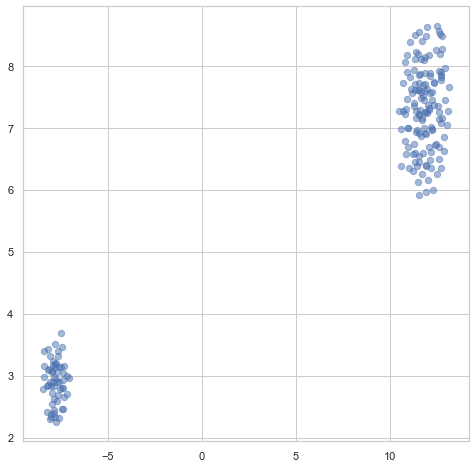

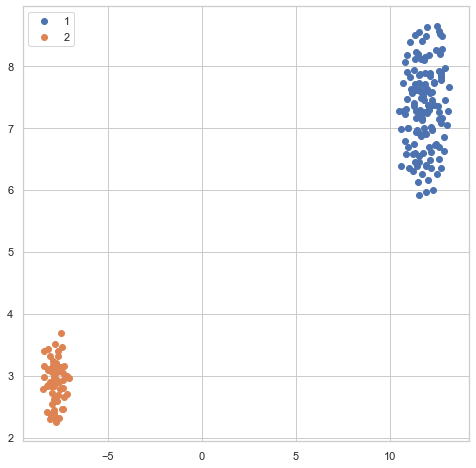

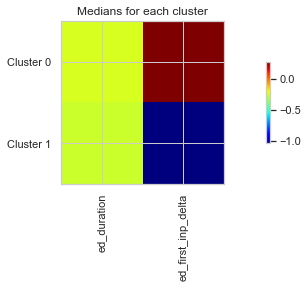

In [23]:
X = dizzy_cohort_df[dizzy_cohort_sig]
u = umap_plot_nolabel(X,1,7);
# analyze the resulting clusters
clust = cluster_umap_nolabel(u,2,X,'upper left')
analyze_clusters_nolabel(clust,X,X.columns)


median statistics of cluster  0


ed_duration                            3.938611
ed_first_inp_delta                    14.178553
age_at_index_visit                    69.450000
new_race_ALASKA/PACIFIC                0.000000
new_race_ASIAN                         0.000000
new_race_BLACK OR AFRICAN AMERICAN     0.000000
new_race_UNKNOWN                       0.000000
new_race_WHITE                         1.000000
Gender                                 1.000000
Ethnicity                              0.000000
Name: 50%, dtype: float64

median statistics of cluster  1


ed_duration                            3.264722
ed_first_inp_delta                     5.271227
age_at_index_visit                    70.110000
new_race_ALASKA/PACIFIC                0.000000
new_race_ASIAN                         0.000000
new_race_BLACK OR AFRICAN AMERICAN     1.000000
new_race_UNKNOWN                       0.000000
new_race_WHITE                         0.000000
Gender                                 1.000000
Ethnicity                              0.000000
Name: 50%, dtype: float64

median statistics of cluster  2


ed_duration                            3.577500
ed_first_inp_delta                    25.034456
age_at_index_visit                    69.195000
new_race_ALASKA/PACIFIC                0.000000
new_race_ASIAN                         0.000000
new_race_BLACK OR AFRICAN AMERICAN     0.000000
new_race_UNKNOWN                       0.000000
new_race_WHITE                         1.000000
Gender                                 1.000000
Ethnicity                              0.000000
Name: 50%, dtype: float64

median statistics of cluster  3


ed_duration                            3.123611
ed_first_inp_delta                     1.077697
age_at_index_visit                    70.550000
new_race_ALASKA/PACIFIC                0.000000
new_race_ASIAN                         0.000000
new_race_BLACK OR AFRICAN AMERICAN     0.000000
new_race_UNKNOWN                       0.000000
new_race_WHITE                         1.000000
Gender                                 1.000000
Ethnicity                              0.000000
Name: 50%, dtype: float64

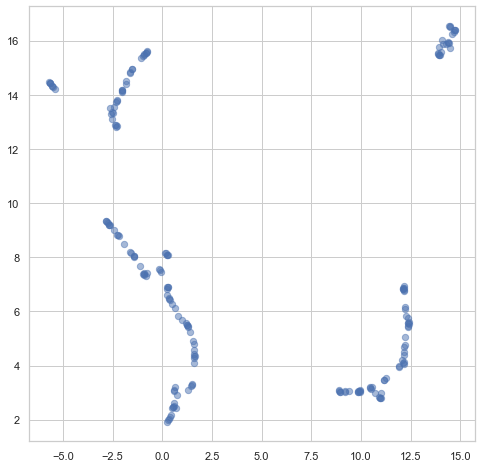

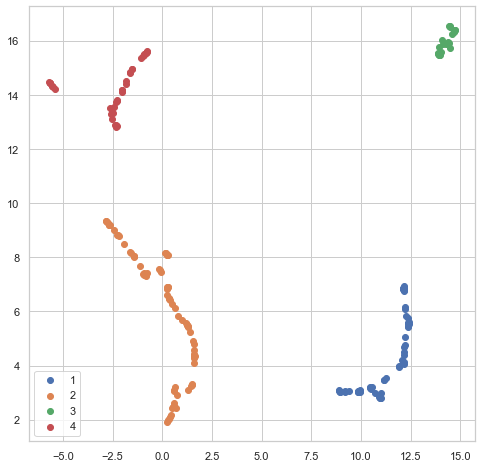

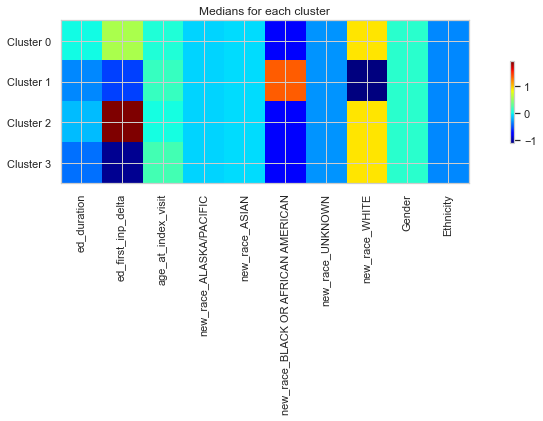

In [64]:
# combine cohort, demo

cohort_demo = pd.merge(dizzy_cohort_df[['PtSSN']+dizzy_cohort_sig],dizzy_demo_coded,on='PtSSN')
X = cohort_demo.iloc[:,1:]
u = umap_plot_nolabel(X,1,7);
# analyze the resulting clusters
clust = cluster_umap_nolabel(u,4,X,'lower left')
analyze_clusters_nolabel(clust,X,X.columns)


median statistics of cluster  0


ed_duration                             3.850000
ed_first_inp_delta                     22.686898
age_at_index_visit                     73.390000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           102.000000
glucose_max                           102.000000
glucose_abnormal_count                  0.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Name: 50%, dtype: fl

median statistics of cluster  1


ed_duration                             3.910833
ed_first_inp_delta                      7.141748
age_at_index_visit                     67.150000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           187.000000
glucose_max                           187.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Name: 50%, dtype: fl

median statistics of cluster  2


ed_duration                             4.087778
ed_first_inp_delta                      8.233912
age_at_index_visit                     63.740000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      1.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           257.000000
glucose_max                           302.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Name: 50%, dtype: fl

median statistics of cluster  3


ed_duration                             3.347222
ed_first_inp_delta                      5.136887
age_at_index_visit                     68.230000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           130.000000
glucose_max                           134.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Name: 50%, dtype: fl

median statistics of cluster  4


ed_duration                             3.298611
ed_first_inp_delta                      4.402697
age_at_index_visit                     72.610000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           104.000000
glucose_max                           104.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Name: 50%, dtype: fl

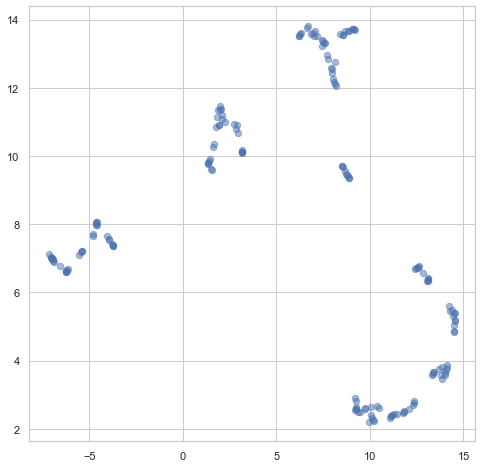

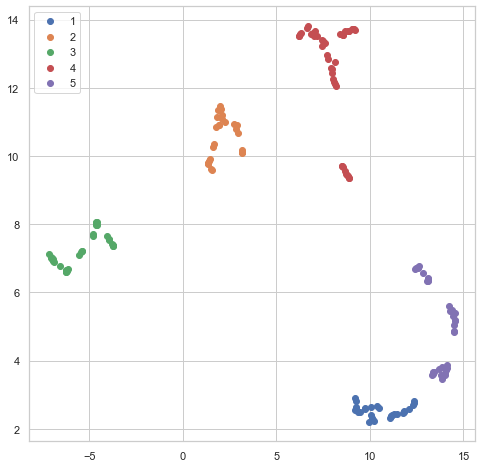

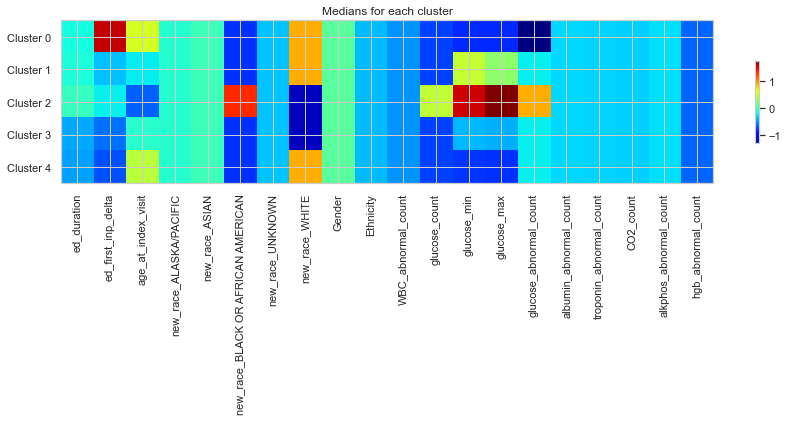

In [65]:
# UMAP the dizzy (cohort_demo + labs)


cohort_demo_labs = pd.merge(cohort_demo,dizzy_clean_labs.dropna()[['PtSSN'] + dizzy_labs_sig],on='PtSSN')
X = cohort_demo_labs.iloc[:,1:]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,5,X,'upper left')
analyze_clusters_nolabel(clust,X,X.columns)




(156, 28) Index(['PtSSN', 'ed_duration', 'ed_first_inp_delta', 'age_at_index_visit',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'WBC_abnormal_count',
       'glucose_count', 'glucose_min', 'glucose_max', 'glucose_abnormal_count',
       'albumin_abnormal_count', 'troponin_abnormal_count', 'CO2_count',
       'alkphos_abnormal_count', 'hgb_abnormal_count', 'Systolic_max',
       'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min',
       'PULSE_first', 'RESPIRATION_max'],
      dtype='object')
median statistics of cluster  0


ed_duration                             3.240556
ed_first_inp_delta                      3.733929
age_at_index_visit                     69.425000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.500000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           134.000000
glucose_max                           135.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  1


ed_duration                             4.430278
ed_first_inp_delta                      9.956435
age_at_index_visit                     69.475000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.500000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           183.000000
glucose_max                           200.500000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  2


ed_duration                             3.761528
ed_first_inp_delta                      8.588958
age_at_index_visit                     70.900000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           101.500000
glucose_max                           103.000000
glucose_abnormal_count                  0.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  3


ed_duration                             2.183472
ed_first_inp_delta                     10.435758
age_at_index_visit                     69.850000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.500000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           129.000000
glucose_max                           131.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  4


ed_duration                             3.814861
ed_first_inp_delta                      5.271227
age_at_index_visit                     63.740000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           280.000000
glucose_max                           316.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

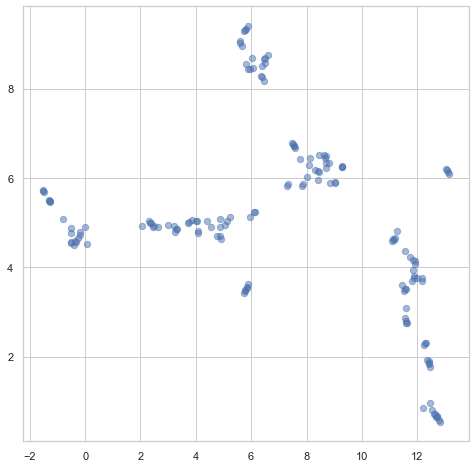

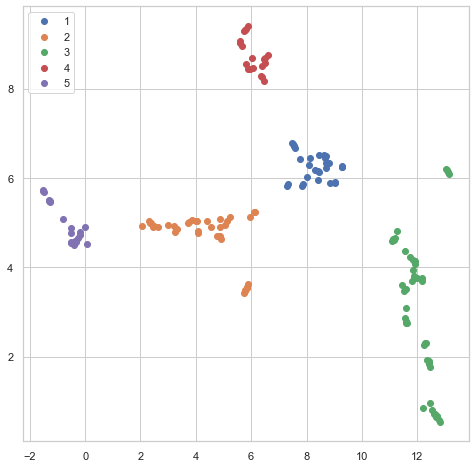

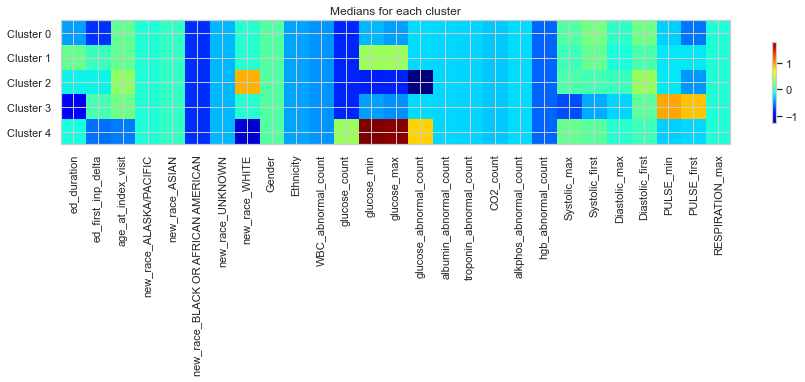

In [92]:
# UMAP the cohort_demo_labs + EDvitals
cohort_demo_labs_EDvitals = pd.merge(cohort_demo_labs,dizzy_EDvitals_df[['PtSSN']+dizzy_vitals_sig],on='PtSSN')
print(cohort_demo_labs_EDvitals.shape,cohort_demo_labs_EDvitals.columns)

X = cohort_demo_labs_EDvitals.iloc[:,1:]
u = umap_plot_nolabel(X,2,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,5,X,'upper left')
analyze_clusters_nolabel(clust,X,X.columns)

median statistics of cluster  0


ed_duration                             3.639444
ed_first_inp_delta                      6.840081
age_at_index_visit                     68.960000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           105.000000
glucose_max                           107.000000
glucose_abnormal_count                  0.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  1


ed_duration                             3.915556
ed_first_inp_delta                      7.544051
age_at_index_visit                     64.900000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           229.500000
glucose_max                           234.500000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  2


ed_duration                             3.835833
ed_first_inp_delta                      7.993895
age_at_index_visit                     76.245000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.500000
new_race_UNKNOWN                        0.500000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.500000
WBC_abnormal_count                      0.000000
glucose_count                           4.000000
glucose_min                           162.500000
glucose_max                           301.000000
glucose_abnormal_count                  3.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               2.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      1.000000
Systolic_max        

median statistics of cluster  3


ed_duration                             3.123611
ed_first_inp_delta                      5.836470
age_at_index_visit                     71.720000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           1.000000
glucose_min                           133.000000
glucose_max                           134.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

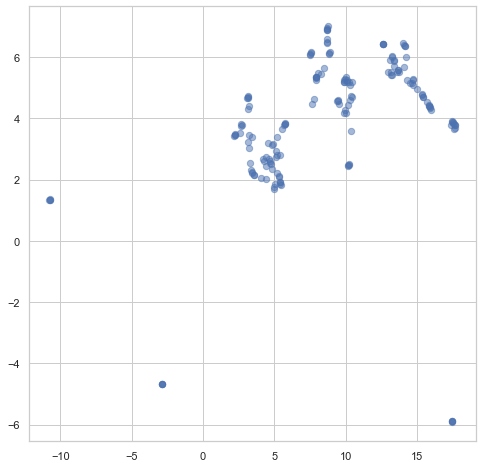

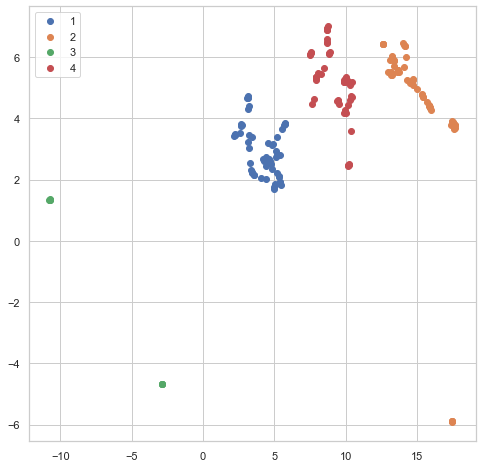

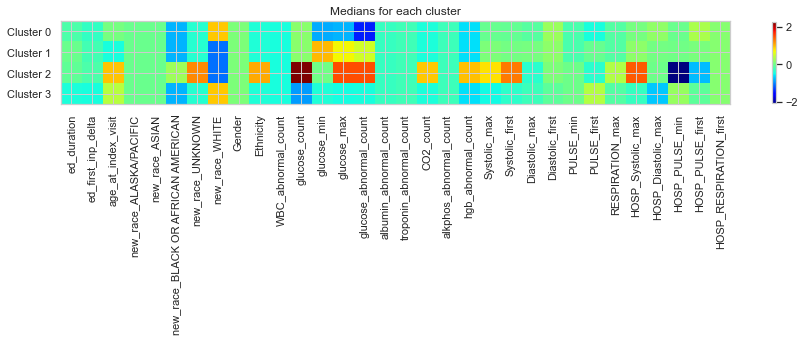

In [69]:
# UMAP the cohort_demo_labs + EDvitals + hospvitals

cohort_demo_labs_EDvitals_hospvitals = pd.merge(cohort_demo_labs_EDvitals,dizzy_hosp_vitals_df[['PtSSN']+dizzy_hosp_vitals_sig],on='PtSSN')
#print(cohort_demo_labs_EDvitals_hospvitals.shape,cohort_demo_labs_EDvitals_hospvitals.columns)

X = cohort_demo_labs_EDvitals_hospvitals.iloc[:,1:]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,4,X,'upper left')
analyze_clusters_nolabel(clust,X,X.columns)

In [73]:
cohort_demo_labs_EDvitals_hospvitals_imaging.columns

Index(['PtSSN', 'ed_duration', 'ed_first_inp_delta', 'age_at_index_visit',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'WBC_abnormal_count',
       'glucose_count', 'glucose_min', 'glucose_max', 'glucose_abnormal_count',
       'albumin_abnormal_count', 'troponin_abnormal_count', 'CO2_count',
       'alkphos_abnormal_count', 'hgb_abnormal_count', 'Systolic_max',
       'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min',
       'PULSE_first', 'RESPIRATION_max', 'HOSP_Systolic_max',
       'HOSP_Diastolic_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first',
       'HOSP_RESPIRATION_first', 'EDStartDateTime', 'ct_count',
       'ct_contrast_count', 'ct_abnormal_count', 'xr_count',
       'xr_abnormal_count', 'mri_count', 'mri_abnormal_count'],
      dtype='object')

median statistics of cluster  0


ed_duration                             4.144722
ed_first_inp_delta                      6.593877
age_at_index_visit                     64.450000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           226.000000
glucose_max                           233.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  1


ed_duration                             3.247778
ed_first_inp_delta                      6.283686
age_at_index_visit                     70.355000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           121.000000
glucose_max                           123.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  2


ed_duration                             3.036111
ed_first_inp_delta                      8.651001
age_at_index_visit                     72.130000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      1.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           156.000000
glucose_max                           302.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               0.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  3


ed_duration                             2.079167
ed_first_inp_delta                      5.261123
age_at_index_visit                     74.350000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        1.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               1.000000
WBC_abnormal_count                      0.000000
glucose_count                           4.000000
glucose_min                           169.000000
glucose_max                           173.000000
glucose_abnormal_count                  4.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               2.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      2.000000
Systolic_max        

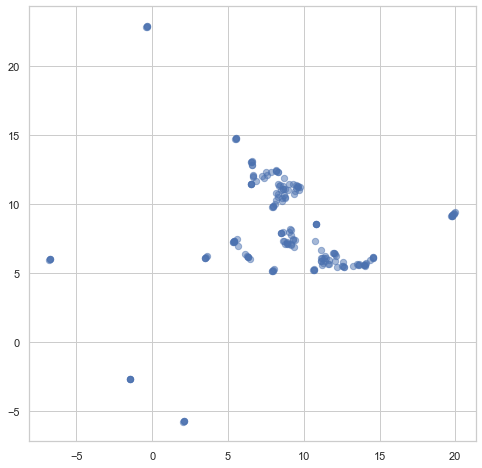

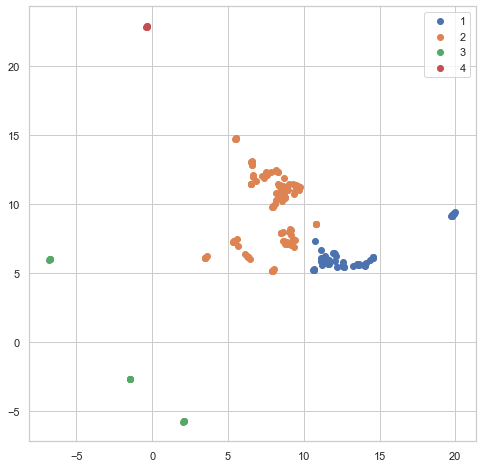

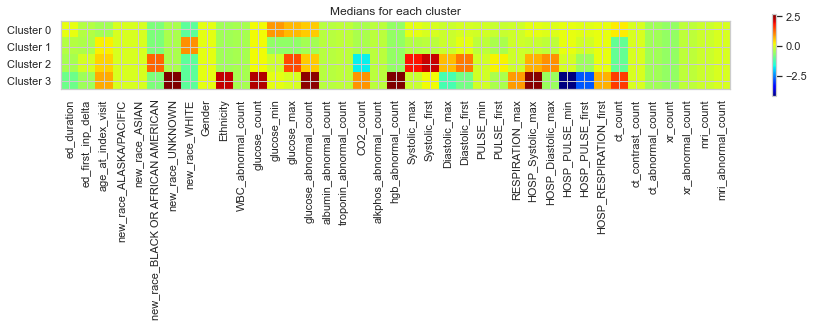

In [87]:
cohort_demo_labs_EDvitals_hospvitals_imaging = pd.merge(cohort_demo_labs_EDvitals_hospvitals,dizzy_images,on='PtSSN')
#print(cohort_demo_labs_EDvitals_hospvitals_imaging.shape,cohort_demo_labs_EDvitals_hospvitals_imaging.columns)
cols = list(cohort_demo_labs_EDvitals_hospvitals_imaging.columns)

cols.remove('PtSSN')
cols.remove('EDStartDateTime')
X = cohort_demo_labs_EDvitals_hospvitals_imaging.loc[:,cols]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,4,X,'upper right')
analyze_clusters_nolabel(clust,X,X.columns)


median statistics of cluster  0


ed_duration                             2.079167
ed_first_inp_delta                      7.164606
age_at_index_visit                     74.350000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      1.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          0.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           4.000000
glucose_min                           156.000000
glucose_max                           173.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               2.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  1


ed_duration                             3.657639
ed_first_inp_delta                      6.310995
age_at_index_visit                     64.900000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           205.000000
glucose_max                           222.000000
glucose_abnormal_count                  2.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

median statistics of cluster  2


ed_duration                             3.347222
ed_first_inp_delta                      7.219167
age_at_index_visit                     69.400000
new_race_ALASKA/PACIFIC                 0.000000
new_race_ASIAN                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
new_race_UNKNOWN                        0.000000
new_race_WHITE                          1.000000
Gender                                  1.000000
Ethnicity                               0.000000
WBC_abnormal_count                      0.000000
glucose_count                           2.000000
glucose_min                           117.000000
glucose_max                           121.000000
glucose_abnormal_count                  1.000000
albumin_abnormal_count                  0.000000
troponin_abnormal_count                 0.000000
CO2_count                               1.000000
alkphos_abnormal_count                  0.000000
hgb_abnormal_count                      0.000000
Systolic_max        

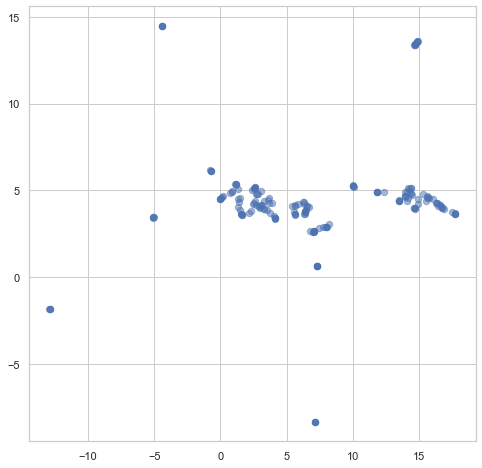

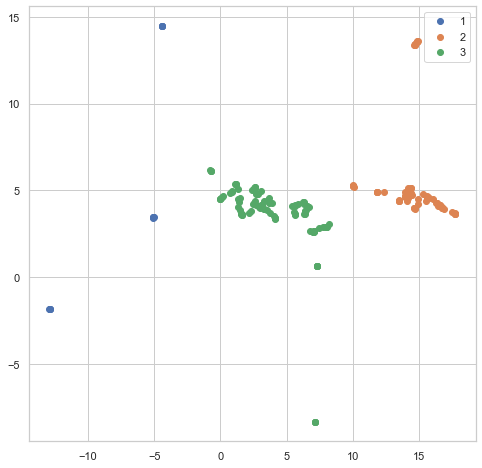

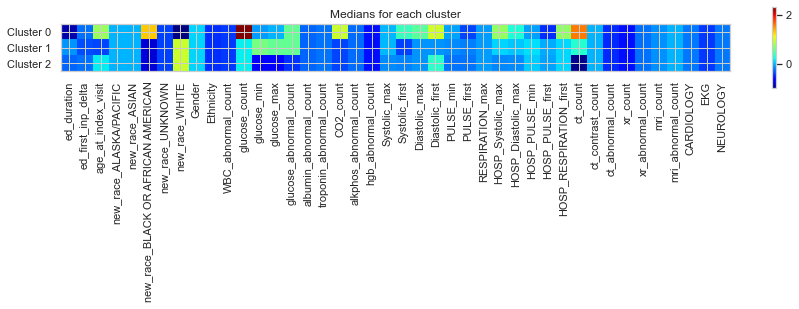

In [90]:
# add consults information
cohort_demo_labs_EDvitals_hospvitals_imaging_consults = pd.merge(cohort_demo_labs_EDvitals_hospvitals_imaging,dizzy_topN_consult_counts,on='PtSSN')
cols = list(cohort_demo_labs_EDvitals_hospvitals_imaging_consults.columns)

cols.remove('PtSSN')
cols.remove('EDStartDateTime')
X = cohort_demo_labs_EDvitals_hospvitals_imaging_consults.loc[:,cols]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,3,X,'upper right')
analyze_clusters_nolabel(clust,X,X.columns)


median statistics of cluster  0


ed_duration                                               3.335694
ed_first_inp_delta                                        6.585475
age_at_index_visit                                       66.100000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        1.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            0.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             2.000000
glucose_min                                             147.500000
glucose_max                                             147.500000
glucose_abnormal_count                                    1.00

median statistics of cluster  1


ed_duration                                               3.372778
ed_first_inp_delta                                        7.443559
age_at_index_visit                                       69.425000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            1.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             1.000000
glucose_min                                             114.000000
glucose_max                                             117.000000
glucose_abnormal_count                                    1.00

median statistics of cluster  2


ed_duration                                               3.436111
ed_first_inp_delta                                        5.271227
age_at_index_visit                                       64.710000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            0.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             2.000000
glucose_min                                             205.000000
glucose_max                                             218.000000
glucose_abnormal_count                                    2.00

median statistics of cluster  3


ed_duration                                               4.092778
ed_first_inp_delta                                       17.880561
age_at_index_visit                                       76.080000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.500000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            0.500000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             3.000000
glucose_min                                             142.000000
glucose_max                                             278.500000
glucose_abnormal_count                                    2.00

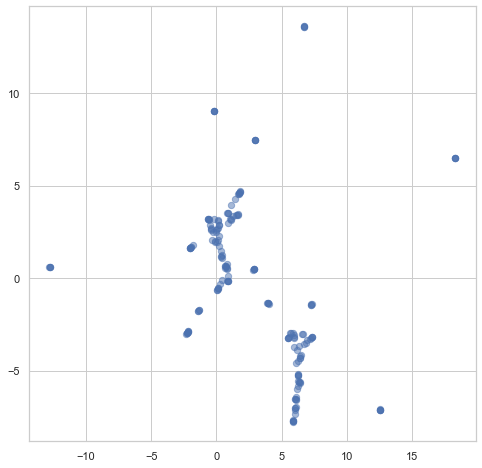

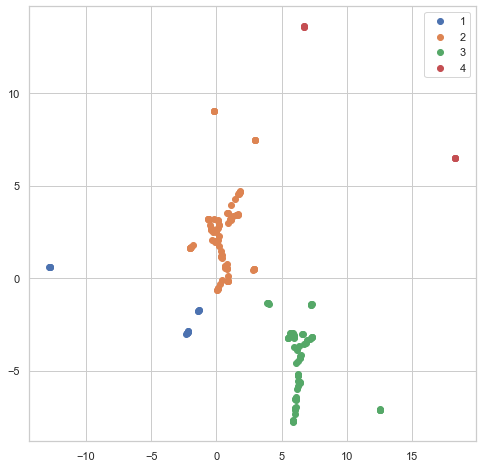

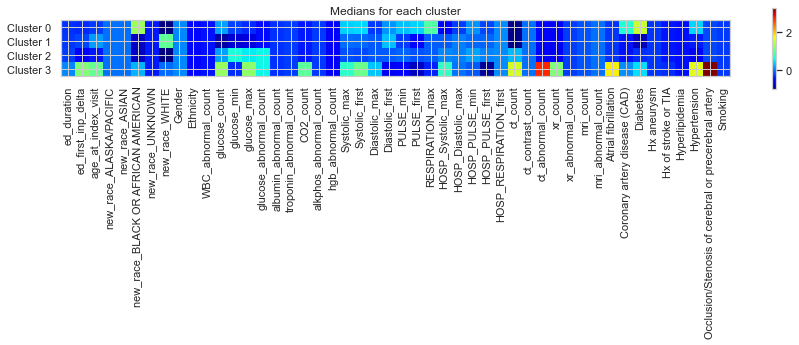

In [134]:
# add risk factors information
cohort_demo_labs_EDvitals_hospvitals_imaging_rf = pd.merge(cohort_demo_labs_EDvitals_hospvitals_imaging,dizzy_rf_df,on='PtSSN')
cols = list(cohort_demo_labs_EDvitals_hospvitals_imaging_rf.columns)

cols.remove('PtSSN')
cols.remove('EDStartDateTime')
X = cohort_demo_labs_EDvitals_hospvitals_imaging_rf.loc[:,cols]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,4,X,'upper right')
analyze_clusters_nolabel(clust,X,X.columns)

In [110]:
combo_label_df.columns

Index(['PtSSN', 'ed_duration', 'ed_first_inp_delta', 'age_at_index_visit',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'WBC_abnormal_count',
       'glucose_count', 'glucose_min', 'glucose_max', 'glucose_abnormal_count',
       'albumin_abnormal_count', 'troponin_abnormal_count', 'CO2_count',
       'alkphos_abnormal_count', 'hgb_abnormal_count', 'Systolic_max',
       'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min',
       'PULSE_first', 'RESPIRATION_max', 'HOSP_Systolic_max',
       'HOSP_Diastolic_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first',
       'HOSP_RESPIRATION_first', 'EDStartDateTime', 'ct_count',
       'ct_contrast_count', 'ct_abnormal_count', 'xr_count',
       'xr_abnormal_count', 'mri_count', 'mri_abnormal_count',
       'Atrial fibrillation', 'Coronary artery disease (CAD)', 'Diabetes',
       'Hx aneurysm', 'Hx of stroke or TIA', 'Hy

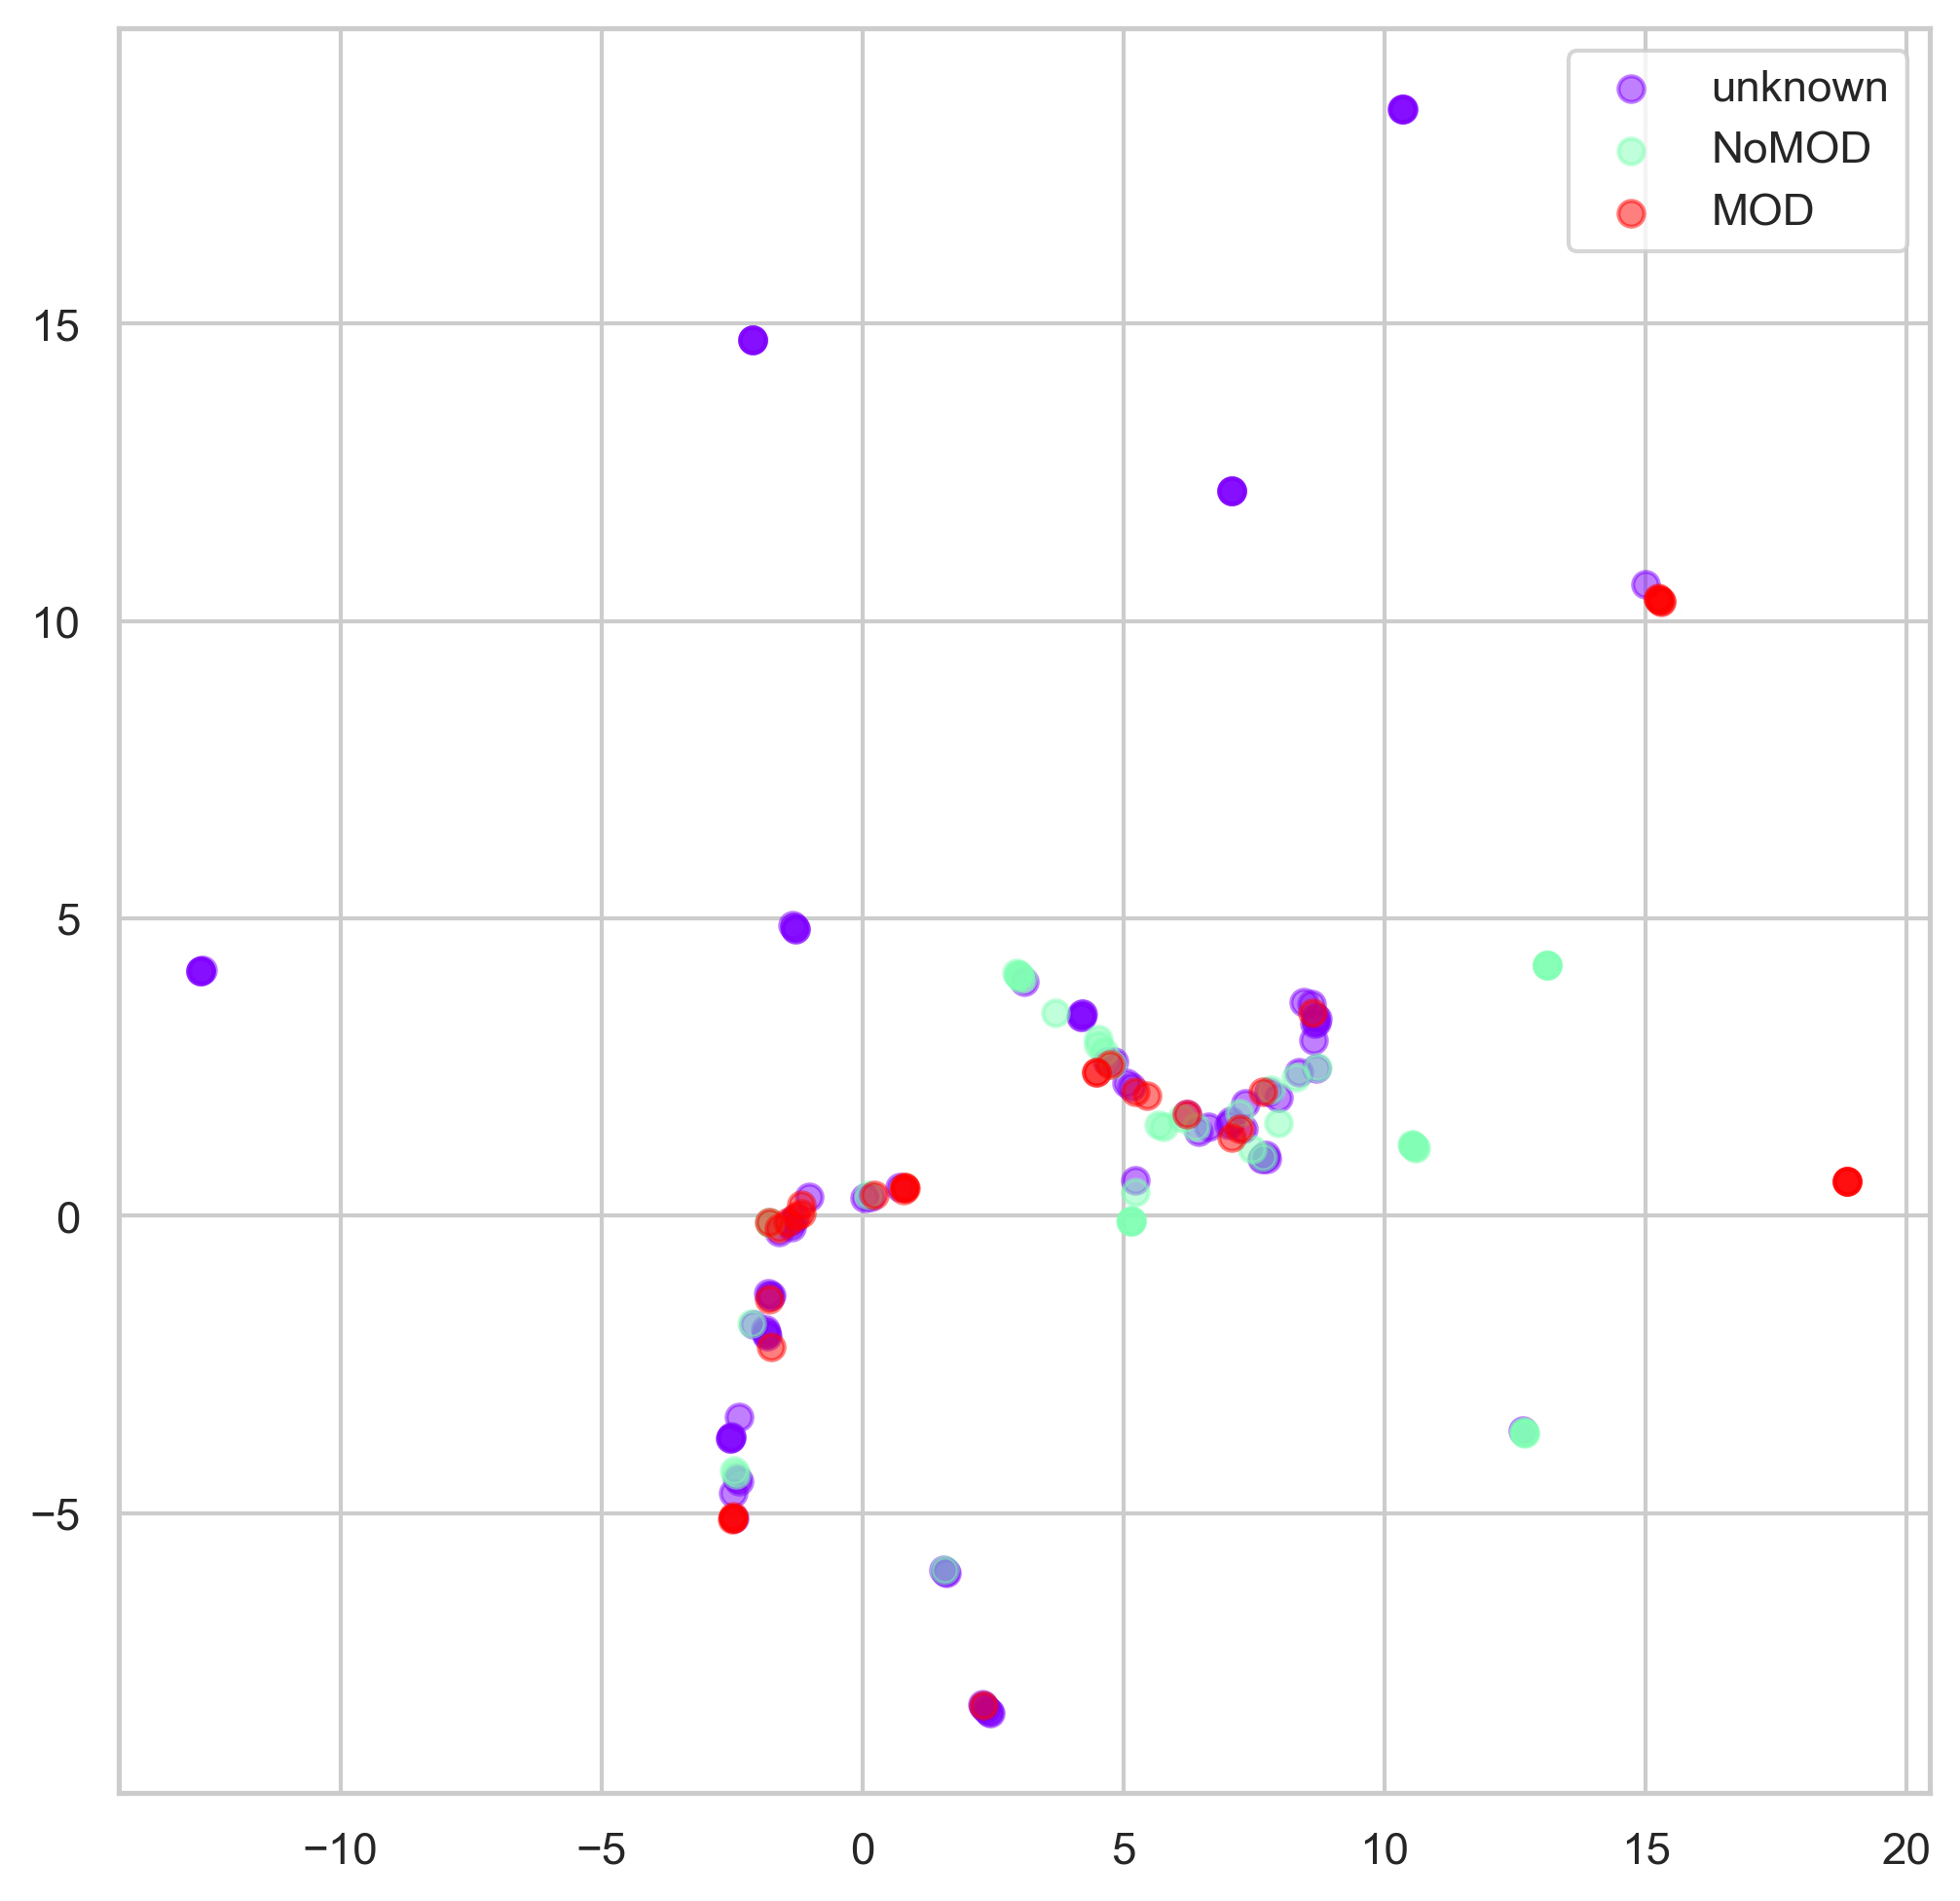

In [153]:
# find a way to plot the labeled data in the combined dataframe

combo_df = cohort_demo_labs_EDvitals_hospvitals_imaging_rf
combo_label_df = pd.merge(combo_df,dizzy_labels_df,on='PtSSN',how='left')
combo_label_df.loc[combo_label_df.label.isna(),'label'] = 'unknown'
cols = list(combo_label_df.columns)

cols.remove('PtSSN')
cols.remove('label')
cols.remove('EDStartDateTime')
reduced_combo = combo_label_df[combo_label_df.label.isin(['MOD','NoMOD','unknown'])]
X = reduced_combo[cols]
y = reduced_combo['label']
label_list = list(reduced_combo.label.value_counts().index)
u = umap_plot_label(X,y,3,5,label_list,'upper right');


Cluster  1
NoMOD      39
unknown    33
MOD        14
Name: label, dtype: int64
Cluster  2
unknown    42
MOD        18
NoMOD       7
Name: label, dtype: int64
Cluster  3
unknown    13
MOD         5
Name: label, dtype: int64
median statistics of cluster  0
NoMOD      39
unknown    33
MOD        14
Name: label, dtype: int64


ed_duration                                               3.761528
ed_first_inp_delta                                        7.910023
age_at_index_visit                                       68.230000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            1.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             1.000000
glucose_min                                             119.500000
glucose_max                                             120.000000
glucose_abnormal_count                                    1.00

median statistics of cluster  1
unknown    42
MOD        18
NoMOD       7
Name: label, dtype: int64


ed_duration                                               3.410556
ed_first_inp_delta                                        5.271227
age_at_index_visit                                       64.710000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            0.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             2.000000
glucose_min                                             192.000000
glucose_max                                             203.000000
glucose_abnormal_count                                    2.00

median statistics of cluster  2
unknown    13
MOD         5
Name: label, dtype: int64


ed_duration                                               2.593056
ed_first_inp_delta                                        8.233912
age_at_index_visit                                       73.315000
new_race_ALASKA/PACIFIC                                   0.000000
new_race_ASIAN                                            0.000000
new_race_BLACK OR AFRICAN AMERICAN                        0.000000
new_race_UNKNOWN                                          0.000000
new_race_WHITE                                            1.000000
Gender                                                    1.000000
Ethnicity                                                 0.000000
WBC_abnormal_count                                        0.000000
glucose_count                                             2.000000
glucose_min                                             128.000000
glucose_max                                             130.500000
glucose_abnormal_count                                    2.00

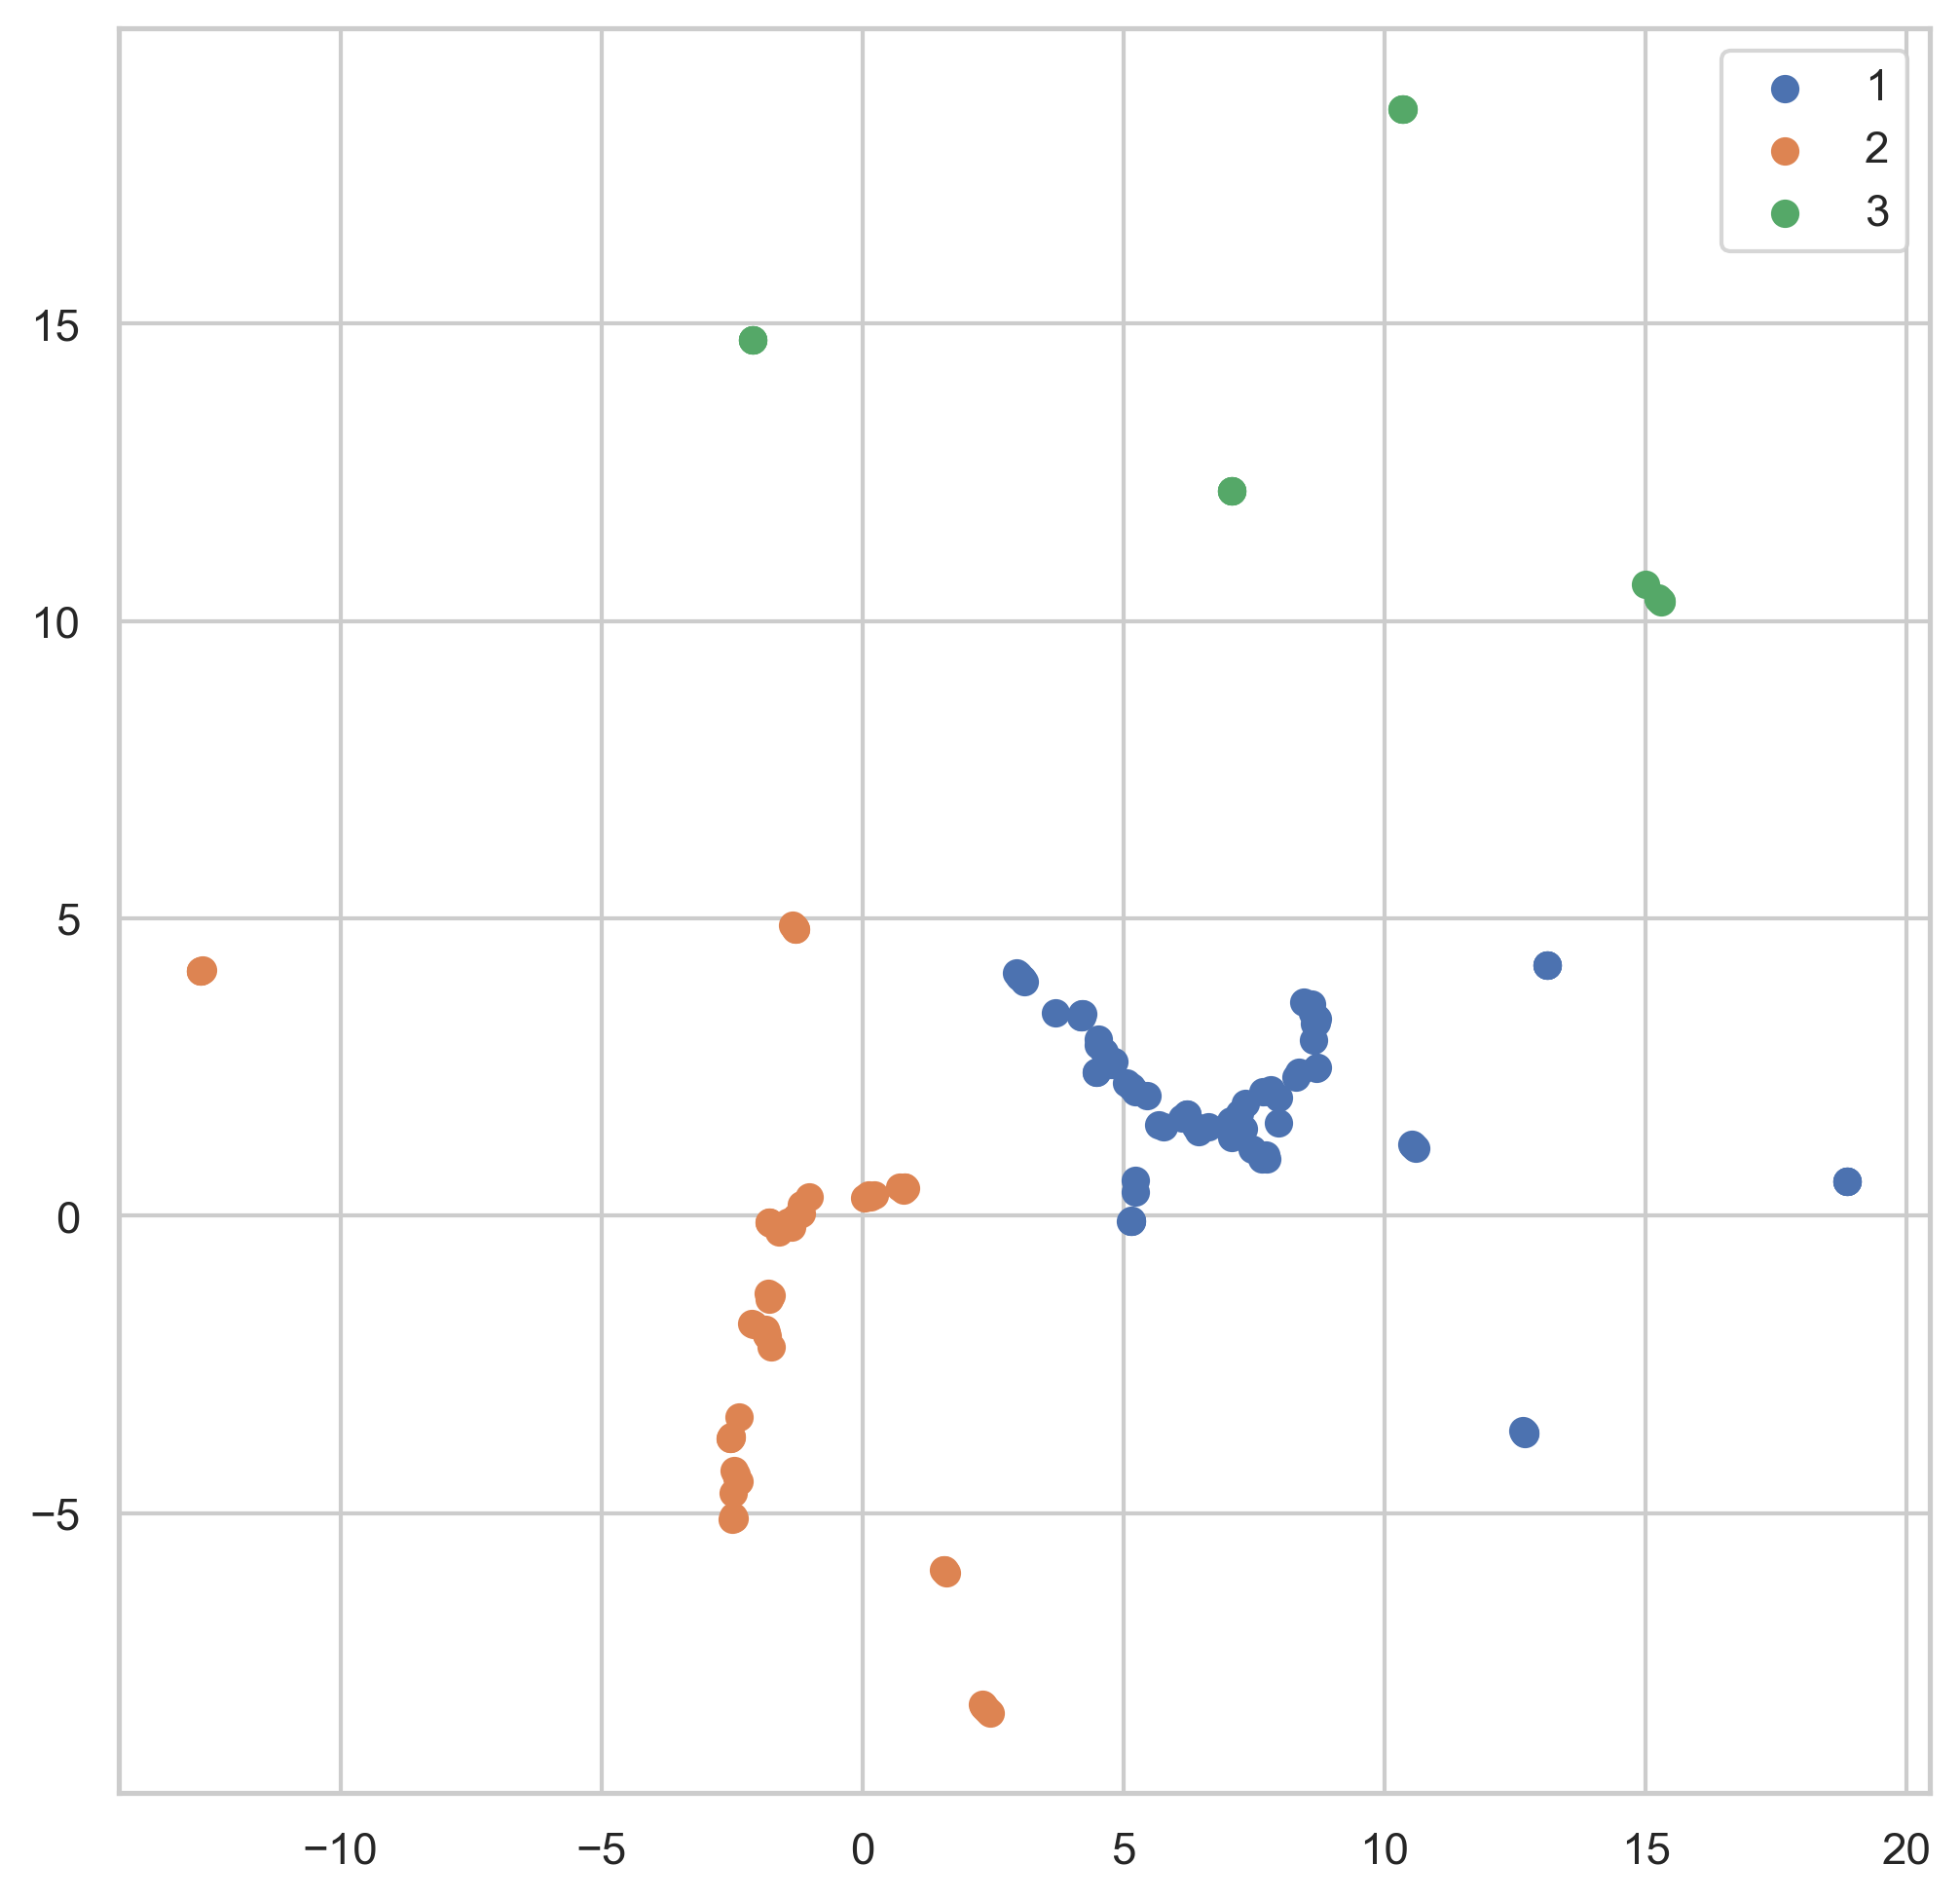

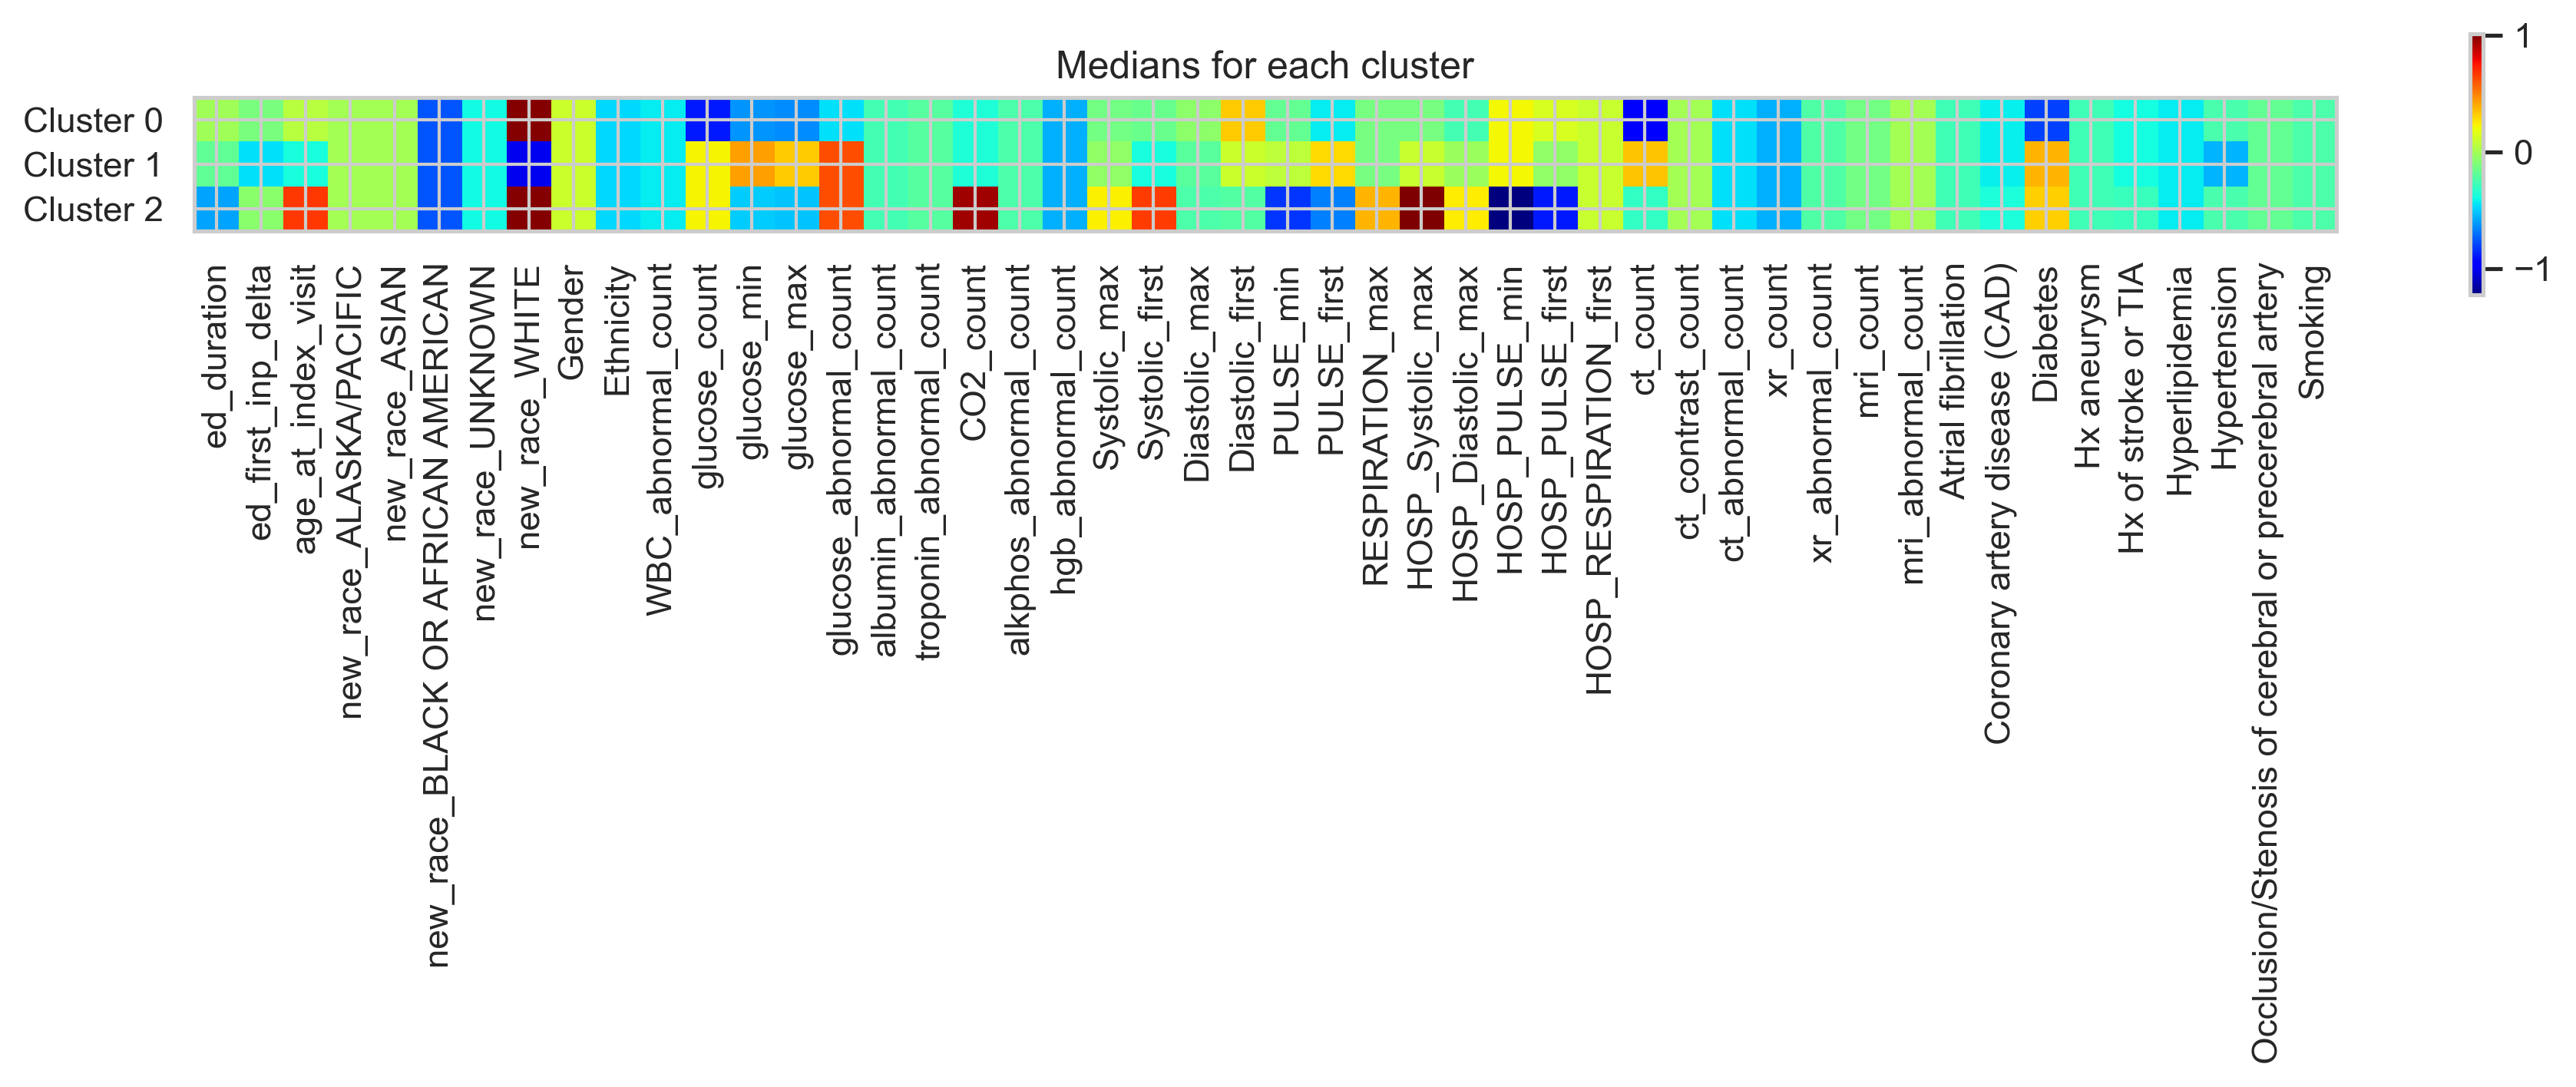

In [154]:
# analyze the resulting clusters
clust = cluster_umap(u,3,reduced_combo[cols+['label']],'upper right')
analyze_clusters(clust,reduced_combo[cols+['label']],cols) 

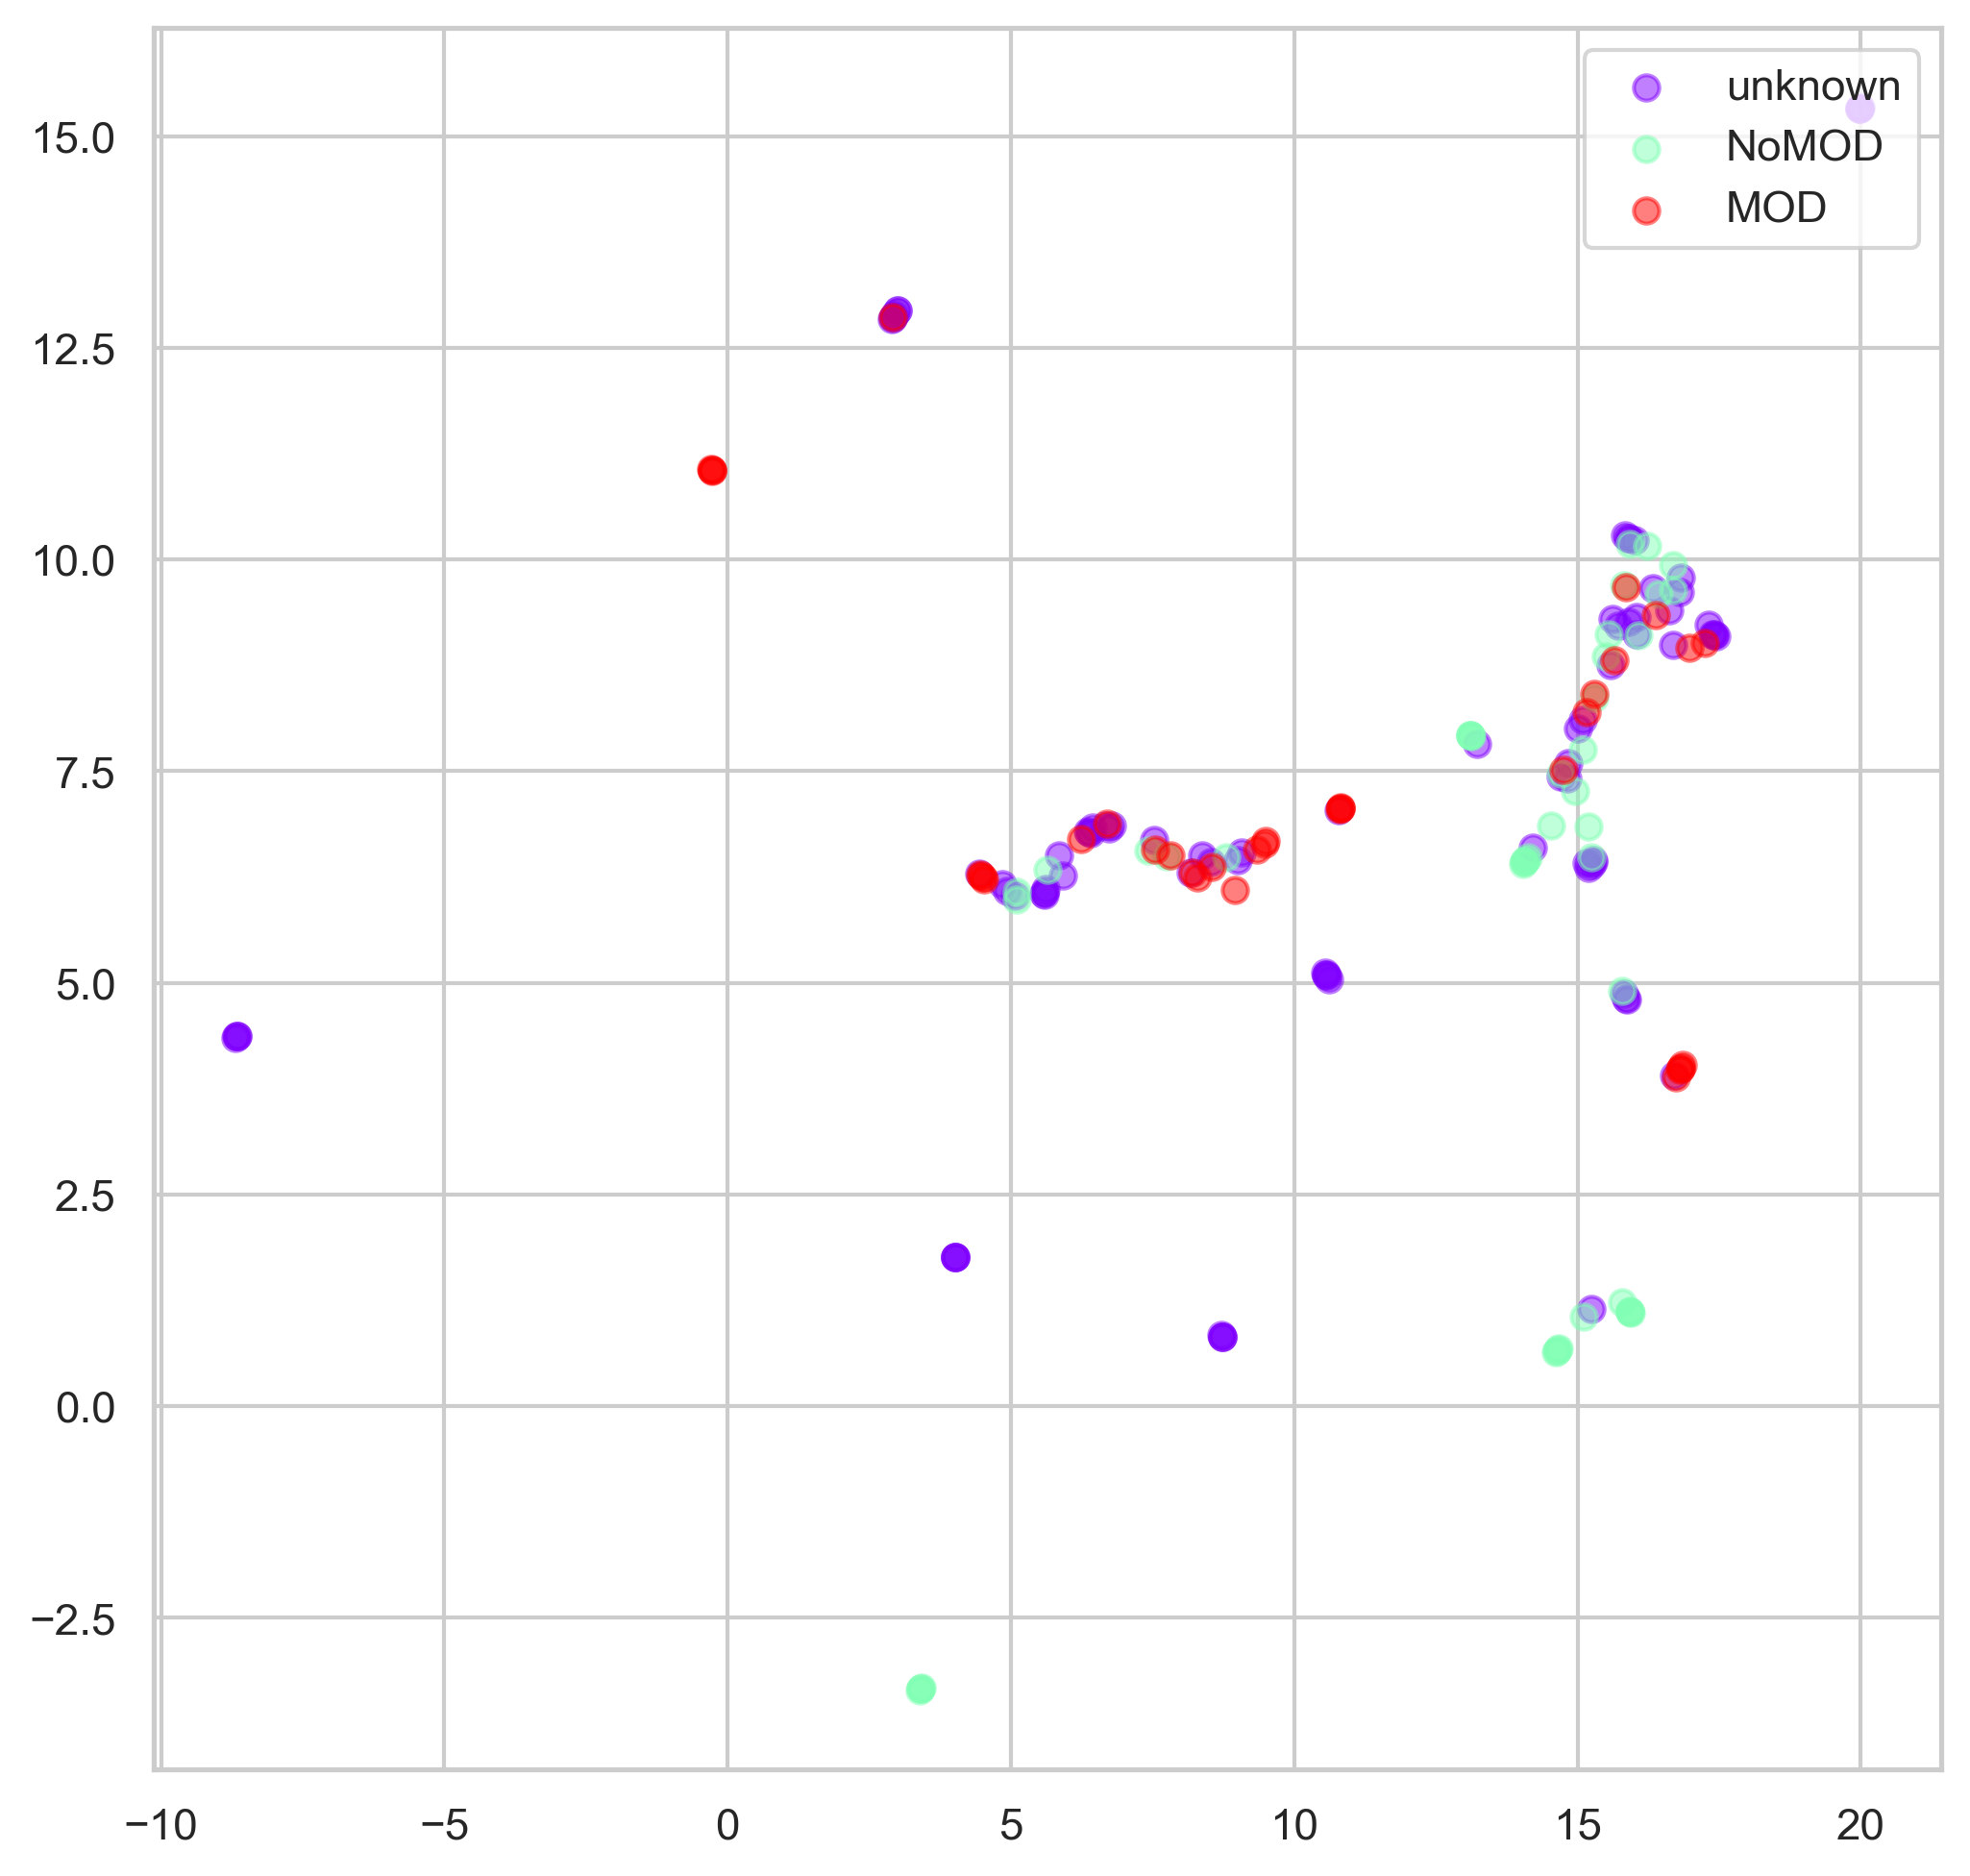

In [151]:
imp_cols = ['ed_first_inp_delta','age_at_index_visit','new_race_WHITE','new_race_BLACK OR AFRICAN AMERICAN','glucose_count',
           'glucose_min','glucose_max','glucose_abnormal_count','CO2_count','hgb_abnormal_count','Systolic_max','Systolic_first',
           'Diastolic_max','Diastolic_first','PULSE_min','PULSE_first','HOSP_Systolic_max','HOSP_Diastolic_max','HOSP_PULSE_min',
           'HOSP_PULSE_first','ct_count','ct_abnormal_count','Diabetes','Hypertension','Coronary artery disease (CAD)']

X = reduced_combo[imp_cols]
y = reduced_combo['label']
label_list = list(reduced_combo.label.value_counts().index)
u = umap_plot_label(X,y,1,7,label_list,'upper right');


Cluster  1
unknown    41
NoMOD      36
MOD        13
Name: label, dtype: int64
Cluster  2
unknown    8
NoMOD      4
Name: label, dtype: int64
Cluster  3
unknown    39
MOD        24
NoMOD       6
Name: label, dtype: int64
median statistics of cluster  0
unknown    41
NoMOD      36
MOD        13
Name: label, dtype: int64


ed_first_inp_delta                      5.923247
age_at_index_visit                     68.230000
new_race_WHITE                          1.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
glucose_count                           1.000000
glucose_min                           114.500000
glucose_max                           122.500000
glucose_abnormal_count                  1.000000
CO2_count                               1.000000
hgb_abnormal_count                      0.000000
Systolic_max                          159.000000
Systolic_first                        149.500000
Diastolic_max                          90.000000
Diastolic_first                        90.000000
PULSE_min                              70.000000
PULSE_first                            72.000000
HOSP_Systolic_max                     165.000000
HOSP_Diastolic_max                     91.500000
HOSP_PULSE_min                         62.500000
HOSP_PULSE_first                       73.500000
ct_count            

median statistics of cluster  1
unknown    8
NoMOD      4
Name: label, dtype: int64


ed_first_inp_delta                      8.651001
age_at_index_visit                     56.940000
new_race_WHITE                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      1.000000
glucose_count                           2.000000
glucose_min                           141.000000
glucose_max                           141.000000
glucose_abnormal_count                  1.000000
CO2_count                               0.000000
hgb_abnormal_count                      0.000000
Systolic_max                          163.000000
Systolic_first                        163.000000
Diastolic_max                         101.000000
Diastolic_first                       101.000000
PULSE_min                             102.000000
PULSE_first                           102.000000
HOSP_Systolic_max                     166.000000
HOSP_Diastolic_max                    105.000000
HOSP_PULSE_min                         73.000000
HOSP_PULSE_first                       96.000000
ct_count            

median statistics of cluster  2
unknown    39
MOD        24
NoMOD       6
Name: label, dtype: int64


ed_first_inp_delta                      5.271227
age_at_index_visit                     69.420000
new_race_WHITE                          0.000000
new_race_BLACK OR AFRICAN AMERICAN      0.000000
glucose_count                           2.000000
glucose_min                           192.000000
glucose_max                           212.000000
glucose_abnormal_count                  2.000000
CO2_count                               1.000000
hgb_abnormal_count                      0.000000
Systolic_max                          159.000000
Systolic_first                        156.000000
Diastolic_max                          90.000000
Diastolic_first                        83.000000
PULSE_min                              72.000000
PULSE_first                            72.000000
HOSP_Systolic_max                     170.000000
HOSP_Diastolic_max                     95.000000
HOSP_PULSE_min                         61.000000
HOSP_PULSE_first                       71.000000
ct_count            

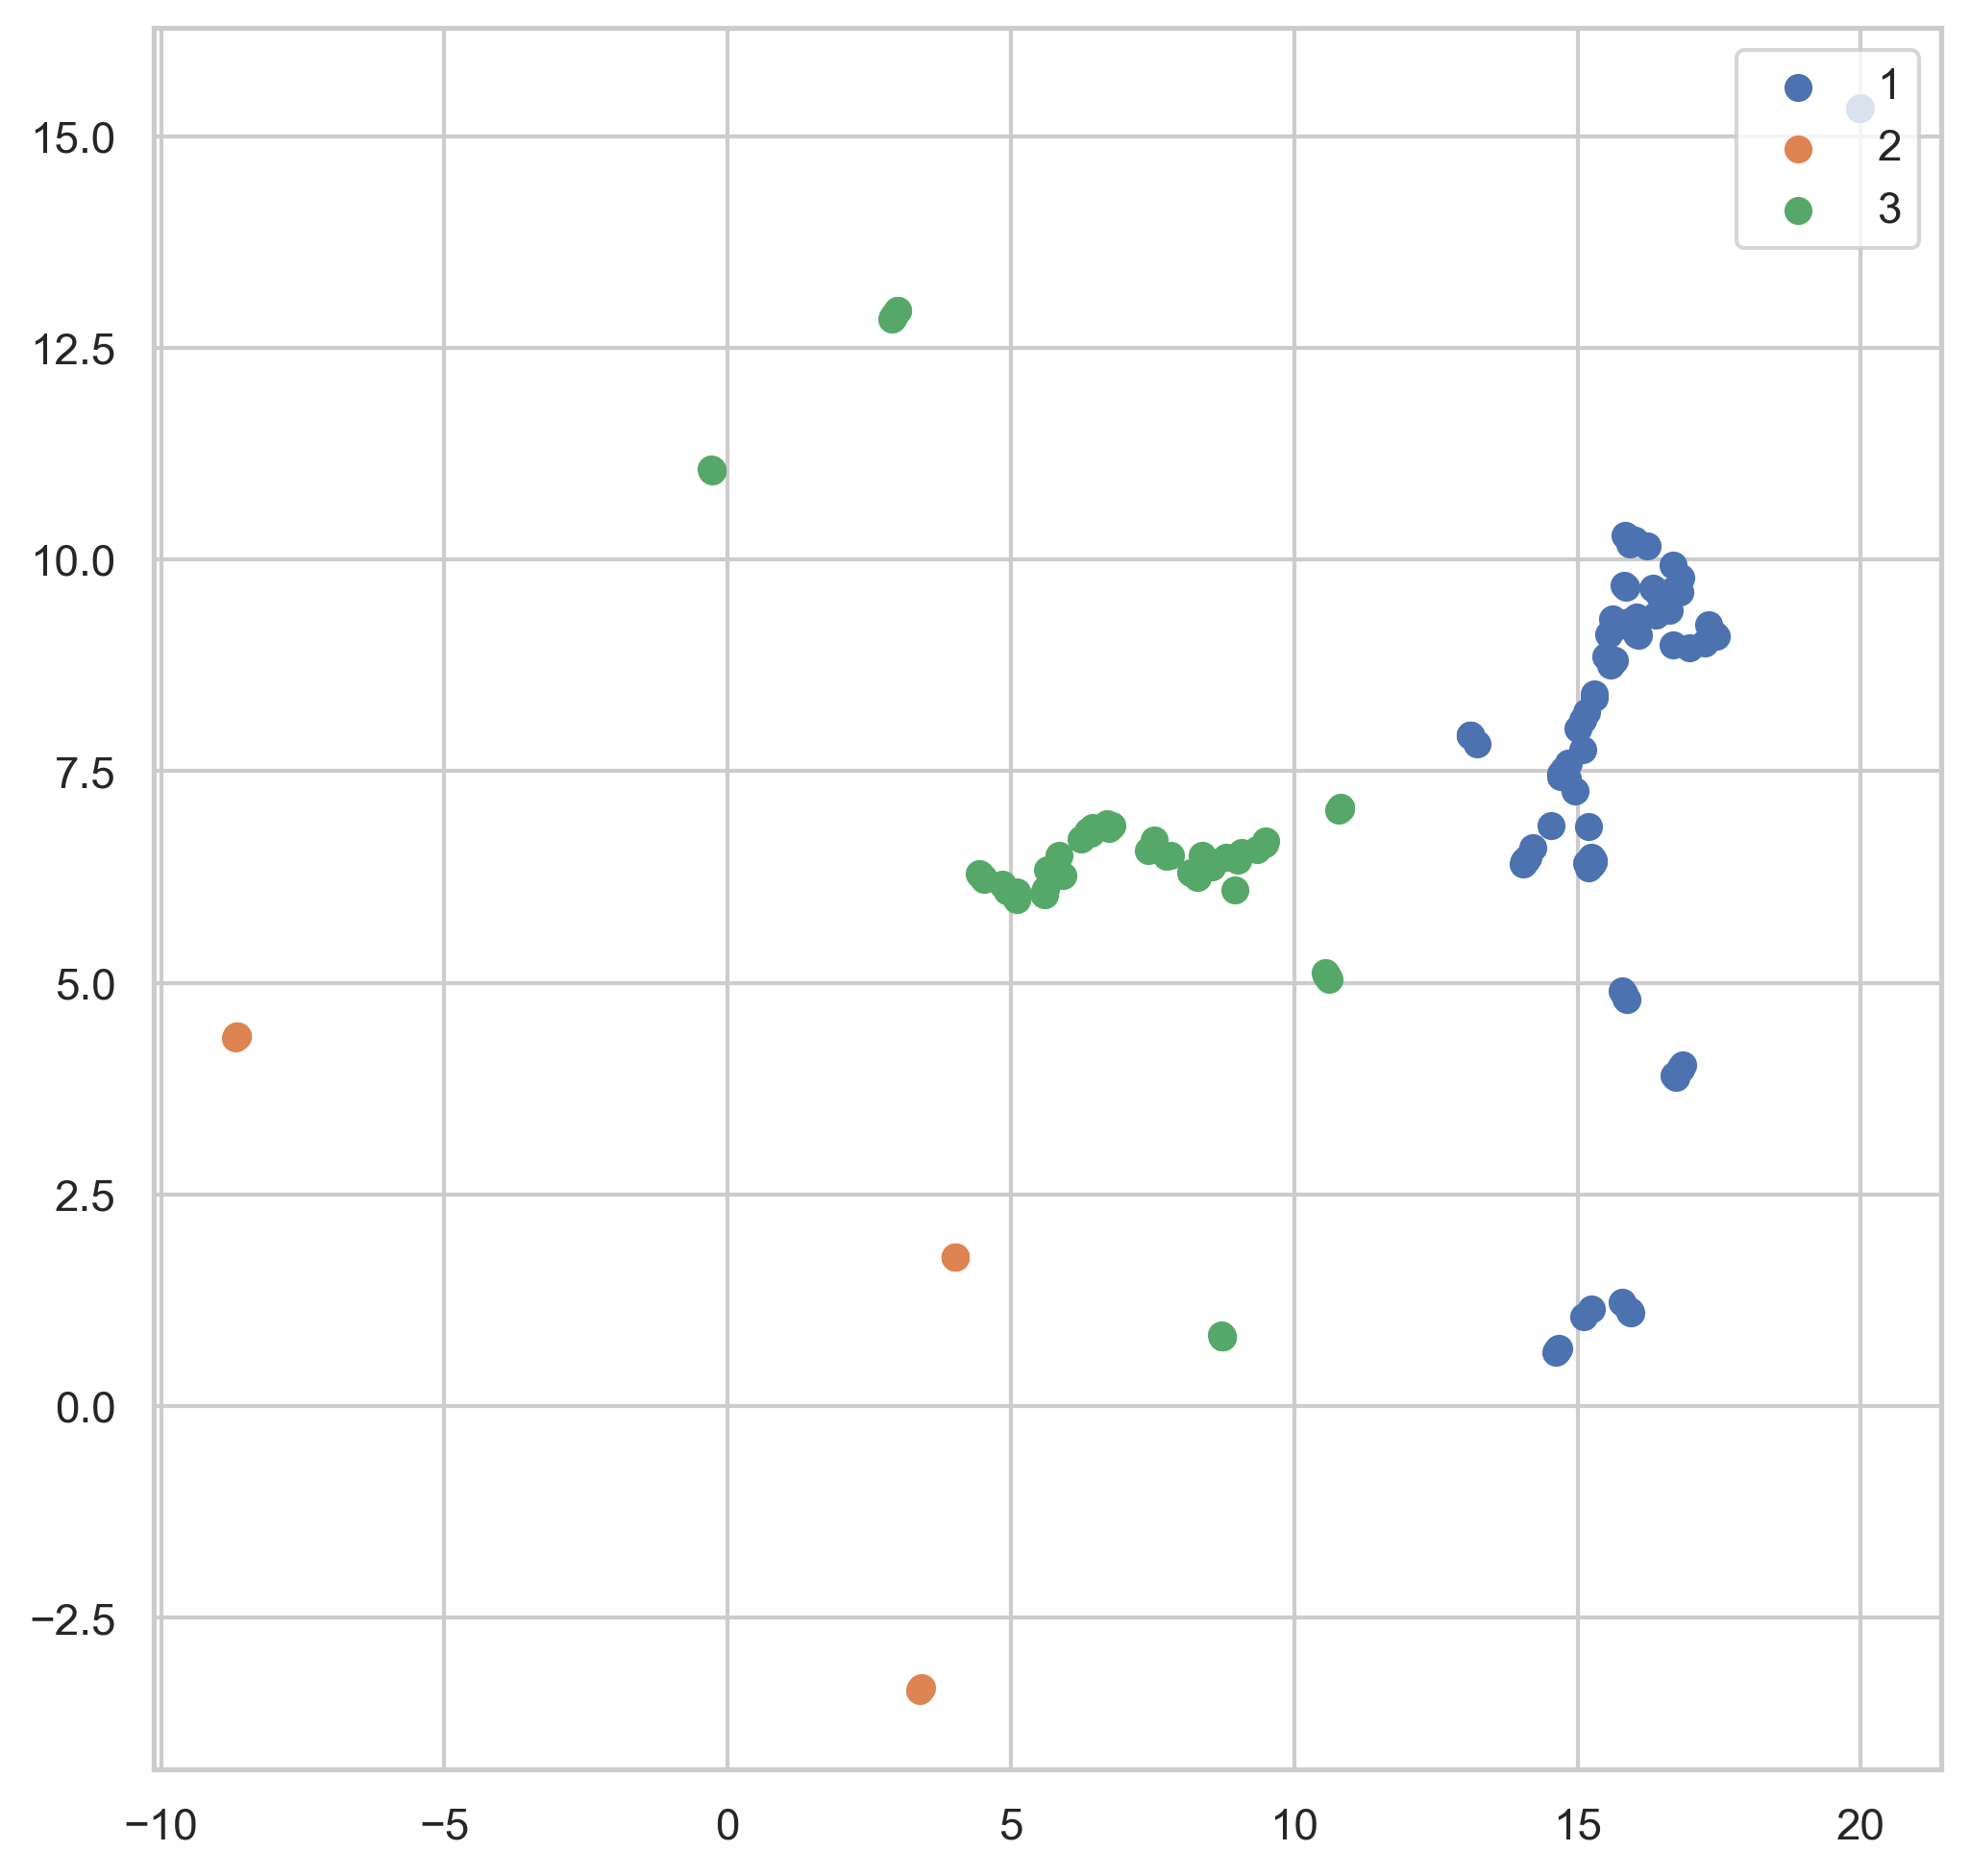

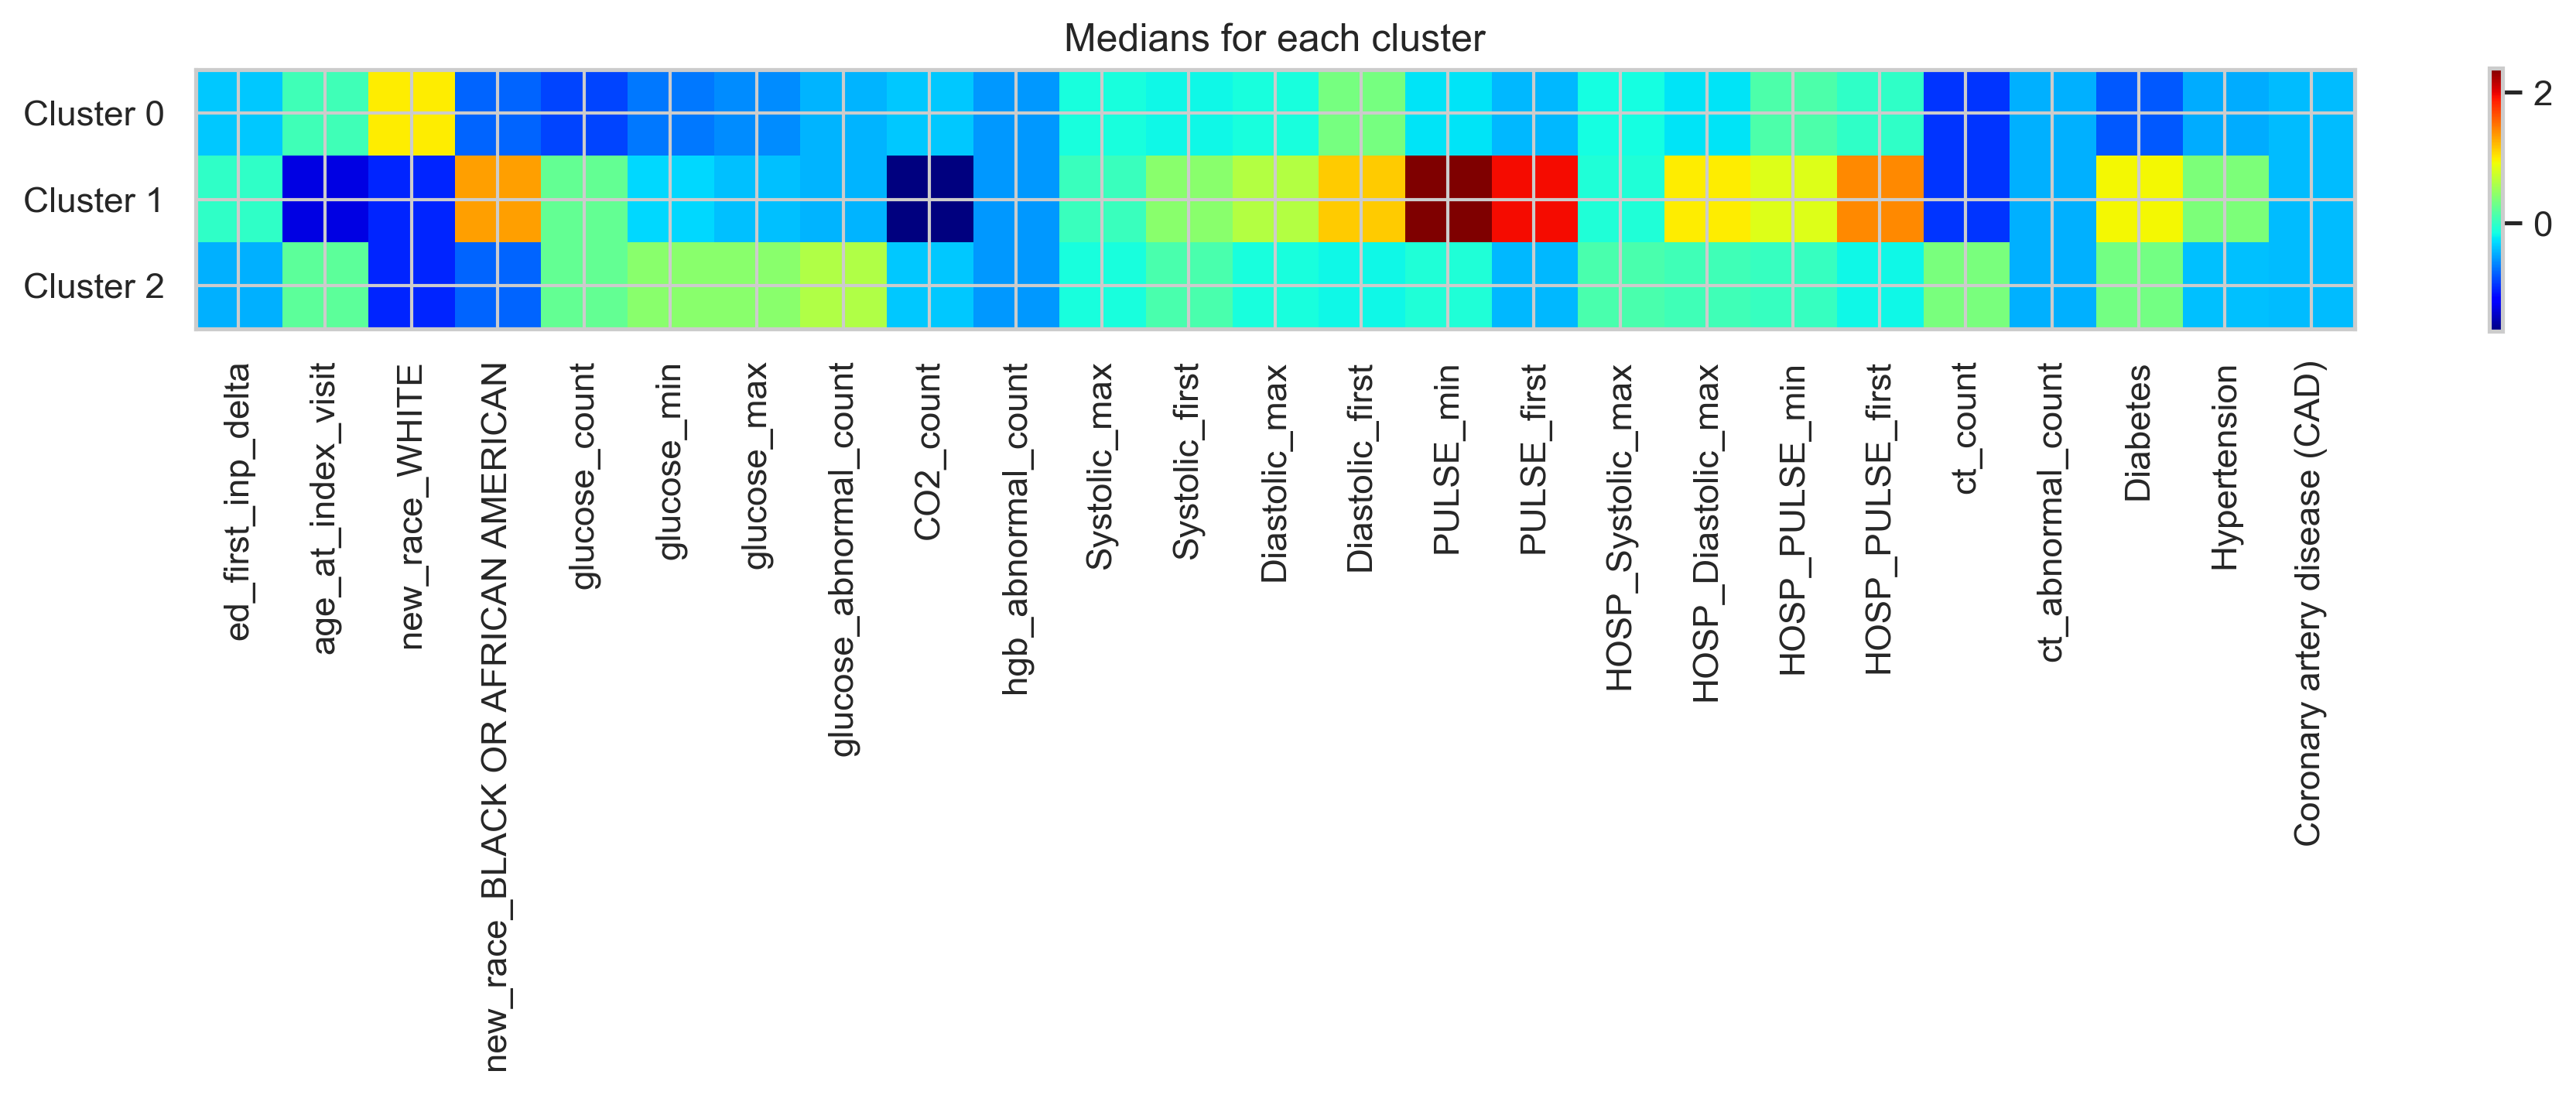

In [152]:
# analyze the resulting clusters
clust = cluster_umap(u,3,reduced_combo[imp_cols+['label']],'upper right')
analyze_clusters(clust,reduced_combo[imp_cols+['label']],imp_cols) 

# Need to get red flags to recreate Paarth classifier on our data
- headache
- diplopia


In [191]:
notes.columns

Index(['PatientSSN', 'EntryDateTime', 'TIUDocumentSID', 'TIUStandardTitle',
       'ReportText', 'Sta3n', 'PatientSID', 'SignedByStaffSID',
       'AmendmentDateTime', 'AmendedByStaffSID', 'ProviderRole'],
      dtype='object')

In [ ]:
tmp = notes[notes.PatientSSN==ptssn]
start_time, end_time = dizzy_cohort_df[dizzy_cohort_df.PtSSN==ptssn].EDStartDateTime.values[0],dizzy_cohort_df[dizzy_cohort_df.PtSSN==ptssn].DischargeDateTime.values[0]
tmp1 = tmp[(tmp.EntryDateTime >= start_time) & (tmp.EntryDateTime <= end_time)]
for i in range(tmp1.shape[0]):
    print(i,'---------------------------------------------')
    print(tmp1.TIUStandardTitle.iloc[i])
    print(tmp1.ReportText.iloc[i])


In [199]:
notes = dataset['withRole']
notes.PatientSSN = notes.PatientSSN.astype('int64')
notes.EntryDateTime = pd.to_datetime(notes.EntryDateTime)
ed_notes = notes[notes.TIUStandardTitle=='EMERGENCY DEPT NOTE'].copy()
ed_notes.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
ed_notes.PtSSN = ed_notes.PtSSN.astype('int64')


ed_notes_mod = pd.merge(ed_notes,dizzy_labels_df,on='PtSSN')


In [ ]:
ptssn = ed_notes_mod.iloc[0].PtSSN
#print(ed_notes_mod.ReportText.iloc[0])
display(dizzy_df[dizzy_df.PtSSN==ptssn].CaseSummaryER.values)
combo_df[combo_df.PtSSN==ptssn]
dizzy_cohort_df[dizzy_cohort_df.PtSSN==ptssn]

median statistics of cluster  0


bun_count                     1.00
chloride_min                101.00
hgb_max                      14.30
WBC_min                       9.41
WBC_max                       9.41
amylase_count                 0.00
lact_count                    0.00
CO2_min                      25.00
calcium_count                 1.00
glucose_count                 1.00
troponin_abnormal_count       0.00
WBC_abnormal_count            0.00
calcium_abnormal_count        0.00
bun_min                      16.00
chloride_abnormal_count       0.00
chloride_count                1.00
ast_count                     1.00
amylase_abnormal_count        0.00
albumin_abnormal_count        0.00
glucose_max                 123.00
potassium_min                 4.00
bun_abnormal_count            0.00
CO2_count                     1.00
chloride_max                102.00
alt_abnormal_count            0.00
CO2_max                      25.00
lact_abnormal_count           0.00
troponin_count                0.00
hgb_abnormal_count  

median statistics of cluster  1


bun_count                     1.00
chloride_min                104.00
hgb_max                      14.00
WBC_min                       8.50
WBC_max                       8.56
amylase_count                 0.00
lact_count                    0.00
CO2_min                      25.00
calcium_count                 1.00
glucose_count                 1.00
troponin_abnormal_count       0.00
WBC_abnormal_count            0.00
calcium_abnormal_count        0.00
bun_min                      13.00
chloride_abnormal_count       0.00
chloride_count                1.00
ast_count                     1.00
amylase_abnormal_count        0.00
albumin_abnormal_count        0.00
glucose_max                  95.00
potassium_min                 3.90
bun_abnormal_count            0.00
CO2_count                     1.00
chloride_max                104.00
alt_abnormal_count            0.00
CO2_max                      25.00
lact_abnormal_count           0.00
troponin_count                0.00
hgb_abnormal_count  

median statistics of cluster  2


bun_count                     1.00
chloride_min                100.00
hgb_max                      13.90
WBC_min                      10.04
WBC_max                      10.30
amylase_count                 0.00
lact_count                    0.00
CO2_min                      24.00
calcium_count                 1.00
glucose_count                 1.00
troponin_abnormal_count       0.00
WBC_abnormal_count            0.00
calcium_abnormal_count        0.00
bun_min                      16.35
chloride_abnormal_count       0.00
chloride_count                1.00
ast_count                     1.00
amylase_abnormal_count        0.00
albumin_abnormal_count        0.00
glucose_max                 194.50
potassium_min                 4.00
bun_abnormal_count            0.00
CO2_count                     1.00
chloride_max                100.00
alt_abnormal_count            0.00
CO2_max                      24.15
lact_abnormal_count           0.00
troponin_count                0.00
hgb_abnormal_count  

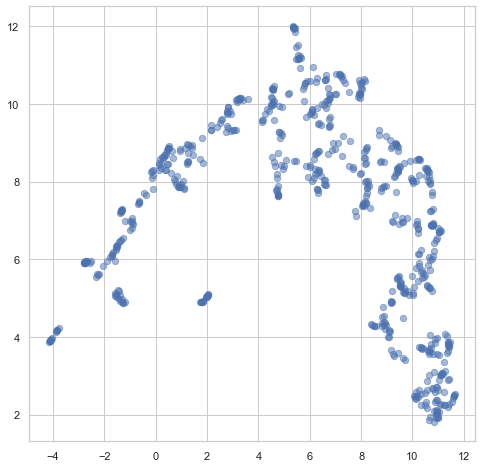

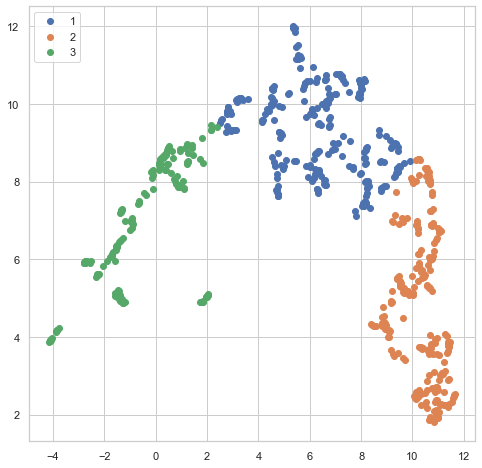

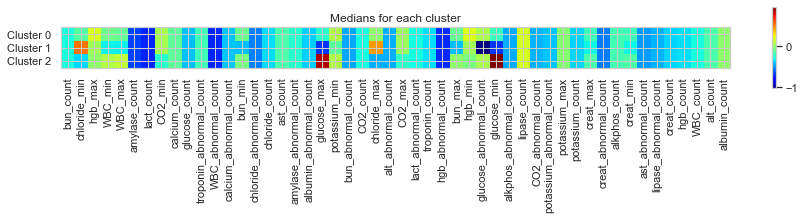

In [32]:
# UMAP the lab dataframe for abdpain

XX = abdpain_clean_labs.dropna()
X = XX[set(XX.columns).difference(['PtSSN'])]
u = umap_plot_nolabel(X,1,7)

# analyze the resulting clusters
clust = cluster_umap_nolabel(u,3,X,'upper left')
analyze_clusters_nolabel(clust,X,X.columns)

# create a tapestry plot to visualize the clusters according to median values


In [ ]:
# start merging all dataframes and UMAP them for dizzy and abdpain


# Make predictive model for dizzy with all the ttest relevant fields

In [213]:
dizzy_cohort_tmp = dizzy_cohort_df_labeled[['PtSSN'] + dizzy_cohort_sig]
dizzy_demo_tmp = dizzy_demo_coded_labeled[['PtSSN'] + dizzy_demo_sig]
dizzy_vitals_tmp = dizzy_EDvitals_labeled[['PtSSN'] + dizzy_vitals_sig]
dizzy_hosp_vitals_tmp = dizzy_hosp_vitals_labeled[['PtSSN'] + dizzy_hosp_vitals_sig]
#dizzy_consults_tmp = dizzy_topN_consult_counts_labeled[['PtSSN'] + dizzy_consults_sig]

# images
dizzy_images_xr_count_labeled = pd.merge(dizzy_images_xr_count,dizzy_labels_df[dizzy_labels_df.label.isin(['MOD','NoMOD'])],on='PtSSN')
dizzy_images_ct_count_labeled = pd.merge(dizzy_images_ct_count,dizzy_labels_df[dizzy_labels_df.label.isin(['MOD','NoMOD'])],on='PtSSN')
dizzy_images_ct_abnormal_count_labeled = pd.merge(dizzy_images_ct_abnormal_count,dizzy_labels_df[dizzy_labels_df.label.isin(['MOD','NoMOD'])],on='PtSSN')

# convert image count fields into int
dizzy_images_xr_count_labeled.xr_count = dizzy_images_xr_count_labeled.xr_count.astype(int)
dizzy_images_ct_count_labeled.ct_count = dizzy_images_ct_count_labeled.ct_count.astype(int)
dizzy_images_ct_abnormal_count_labeled.ct_abnormal_count = dizzy_images_ct_abnormal_count_labeled.ct_abnormal_count.astype(int)

dizzy_images_xr_count_tmp = dizzy_images_xr_count_labeled[['PtSSN','xr_count']].drop_duplicates()
dizzy_images_ct_count_tmp = dizzy_images_ct_count_labeled[['PtSSN','ct_count']].drop_duplicates()
dizzy_images_ct_abnormal_count_tmp = dizzy_images_ct_abnormal_count_labeled[['PtSSN','ct_abnormal_count']].drop_duplicates()


# labs is rel_dizzy_labs
# risk factors is dizzy_rf_df_all_labeled

# merge them all

labels_tmp = dizzy_labels_df[dizzy_labels_df.label.isin(['MOD','NoMOD'])][['PtSSN','label']]
dizzy_all = pd.merge(labels_tmp,dizzy_cohort_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_demo_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_vitals_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_hosp_vitals_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_consults_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,rel_dizzy_labs,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_images_xr_count_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_images_ct_count_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_images_ct_abnormal_count_tmp,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_rf_df_all_labeled[['PtSSN','Hx aneurysm']],on=['PtSSN'])
print(dizzy_all.shape)
set(dizzy_all.columns).difference(set(all_dizzy_all.columns))

(82, 29)


{'label'}

# make feature dataframe for entire data set

In [236]:
# make dataset for all of dizzy (not just the labeled data)
all_dizzy_cohort_tmp = dizzy_cohort_df[['PtSSN'] + dizzy_cohort_sig]
#print(all_dizzy_cohort_tmp.shape,all_dizzy_cohort_tmp.columns)
all_dizzy_demo_tmp = dizzy_demo_coded[['PtSSN'] + dizzy_demo_sig]
#print(all_dizzy_demo_tmp.shape,all_dizzy_demo_tmp.columns)
all_dizzy_vitals_tmp = dizzy_EDvitals_df[['PtSSN'] + dizzy_vitals_sig]
#print(all_dizzy_vitals_tmp.shape,all_dizzy_vitals_tmp.columns)
all_dizzy_hosp_vitals_tmp = dizzy_hosp_vitals_df[['PtSSN'] + dizzy_hosp_vitals_sig]
#all_dizzy_consults_tmp = dizzy_topN_consult_counts[['PtSSN'] + dizzy_consults_sig]
#print(all_dizzy_hosp_vitals_tmp.shape,all_dizzy_hosp_vitals_tmp.columns)

# convert image count fields into int
dizzy_images_xr_count.xr_count = dizzy_images_xr_count.xr_count.astype(int)
dizzy_images_ct_count.ct_count = dizzy_images_ct_count.ct_count.astype(int)
dizzy_images_ct_abnormal_count.ct_abnormal_count = dizzy_images_ct_abnormal_count.ct_abnormal_count.astype(int)

all_dizzy_images_xr_count_tmp = dizzy_images_xr_count[['PtSSN','xr_count']].drop_duplicates()
all_dizzy_images_ct_count_tmp = dizzy_images_ct_count[['PtSSN','ct_count']].drop_duplicates()
all_dizzy_images_ct_abnormal_count_tmp = dizzy_images_ct_abnormal_count[['PtSSN','ct_abnormal_count']].drop_duplicates()


# labs is rel_dizzy_labs
# risk factors is dizzy_rf_df_all_labeled

# merge them all


all_dizzy_all = pd.merge(all_dizzy_cohort_tmp,all_dizzy_demo_tmp,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,all_dizzy_vitals_tmp,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,all_dizzy_hosp_vitals_tmp,on='PtSSN')

#all_dizzy_all = pd.merge(all_dizzy_all,dizzy_consults_tmp,on='PtSSN')
all_dizzy_all = pd.merge(all_dizzy_all,rel_dizzy_labs,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,all_dizzy_images_xr_count_tmp,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,all_dizzy_images_ct_count_tmp,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,all_dizzy_images_ct_abnormal_count_tmp,on='PtSSN')

all_dizzy_all = pd.merge(all_dizzy_all,dizzy_rf_df_all[['PtSSN','Hx aneurysm']],on=['PtSSN'])
print(all_dizzy_all.shape)
print(all_dizzy_all.columns)

(195, 28)
Index(['PtSSN', 'ed_duration', 'ed_first_inp_delta', 'Systolic_max',
       'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min',
       'PULSE_first', 'RESPIRATION_max', 'HOSP_Systolic_max',
       'HOSP_Diastolic_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first',
       'HOSP_RESPIRATION_first', 'WBC_abnormal_count', 'glucose_count',
       'glucose_min', 'glucose_max', 'glucose_abnormal_count',
       'albumin_abnormal_count', 'CO2_count', 'alkphos_abnormal_count',
       'hgb_abnormal_count', 'xr_count', 'ct_count', 'ct_abnormal_count',
       'Hx aneurysm'],
      dtype='object')


In [45]:
# which ones have NAs in them?
# make all  count columns default to 0

limit_dizzy_all = dizzy_all[dizzy_all.label.isin(['MOD','NoMOD'])].copy()

abcols = ['WBC_abnormal_count','glucose_count','glucose_abnormal_count','albumin_abnormal_count','CO2_count',
        'alkphos_abnormal_count','hgb_abnormal_count']
for abcol in abcols:
    limit_dizzy_all[abcol] = limit_dizzy_all[abcol].fillna(0)



for col in limit_dizzy_all.columns[2:]:
    v = limit_dizzy_all[col].isna().sum()
    if v > 0:
        print(col,v )
    
print(limit_dizzy_all.shape)

glucose_min 7
glucose_max 7
(82, 29)


In [46]:
# for glucose_min and glucose_max use class_specific medians

glucose_cols = ['glucose_min','glucose_max']
for gcol in glucose_cols:
    vals = limit_dizzy_all.groupby('label')[gcol].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(mod_val,nomod_val)
    

156.0 126.0
171.0 126.0


<AxesSubplot:>

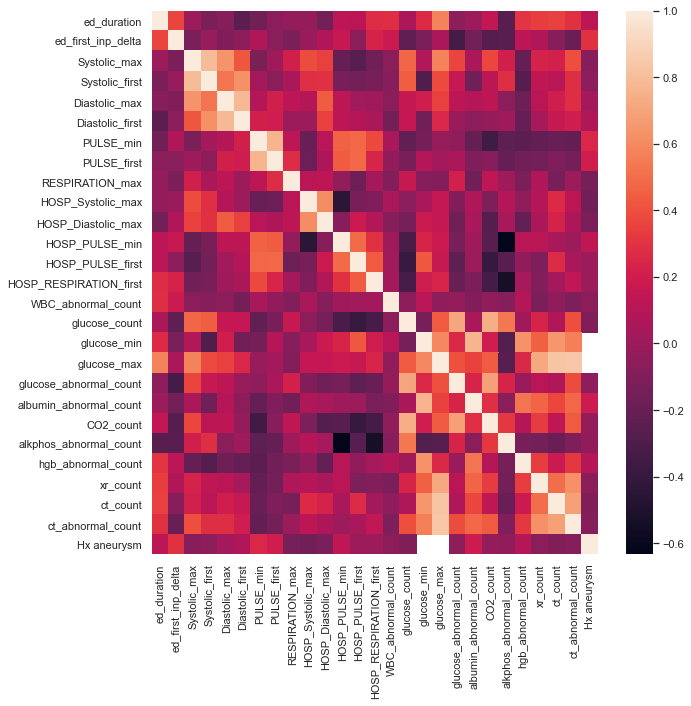

In [101]:
# drop highly correlated columns to support logistic regression
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(limit_dizzy_all.iloc[:,2:].corr(),ax=ax,annot=False)

(75, 29)
(75, 27) (75,)
Best C =  0.004520353656360241


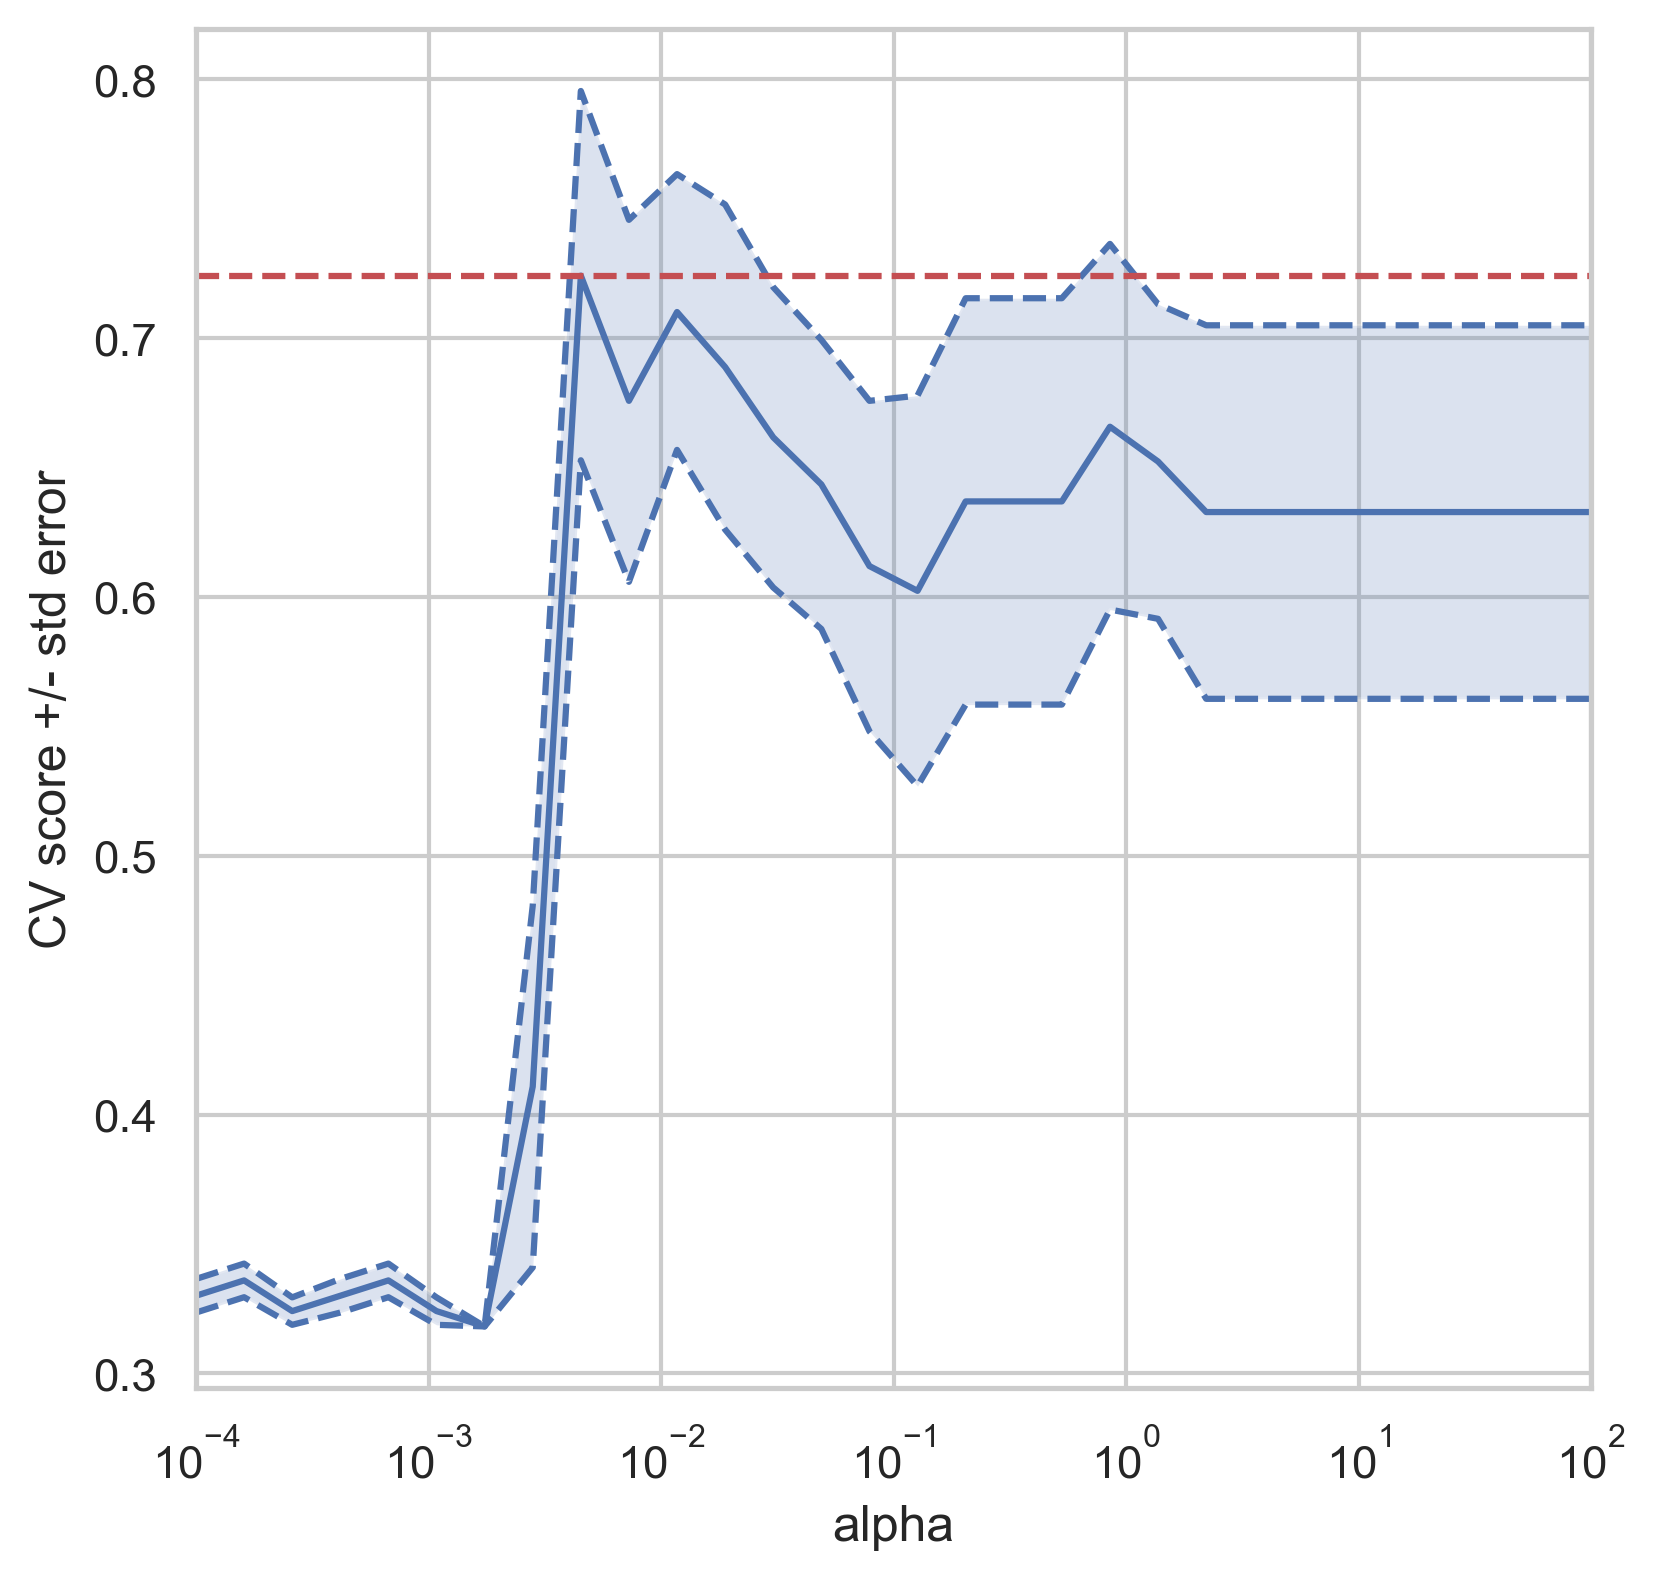

In [240]:
tmp = limit_dizzy_all.dropna()
print(tmp.shape)
X = tmp.iloc[:,2:]
yy = tmp.label
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)
clf = tune_model(X,y)
print('Best C = ',clf.best_params_['C'])

(75, 27) (75,)
AUC =  0.7785714285714285 0.14133113526720983
F1 =  0.6947155768208401 0.12909600812201208
Accuracy =  0.7066666666666667 0.12364824660660939
Confusion matrix:
[[32  6]
 [16 21]]
3  features chosen by L1 model.


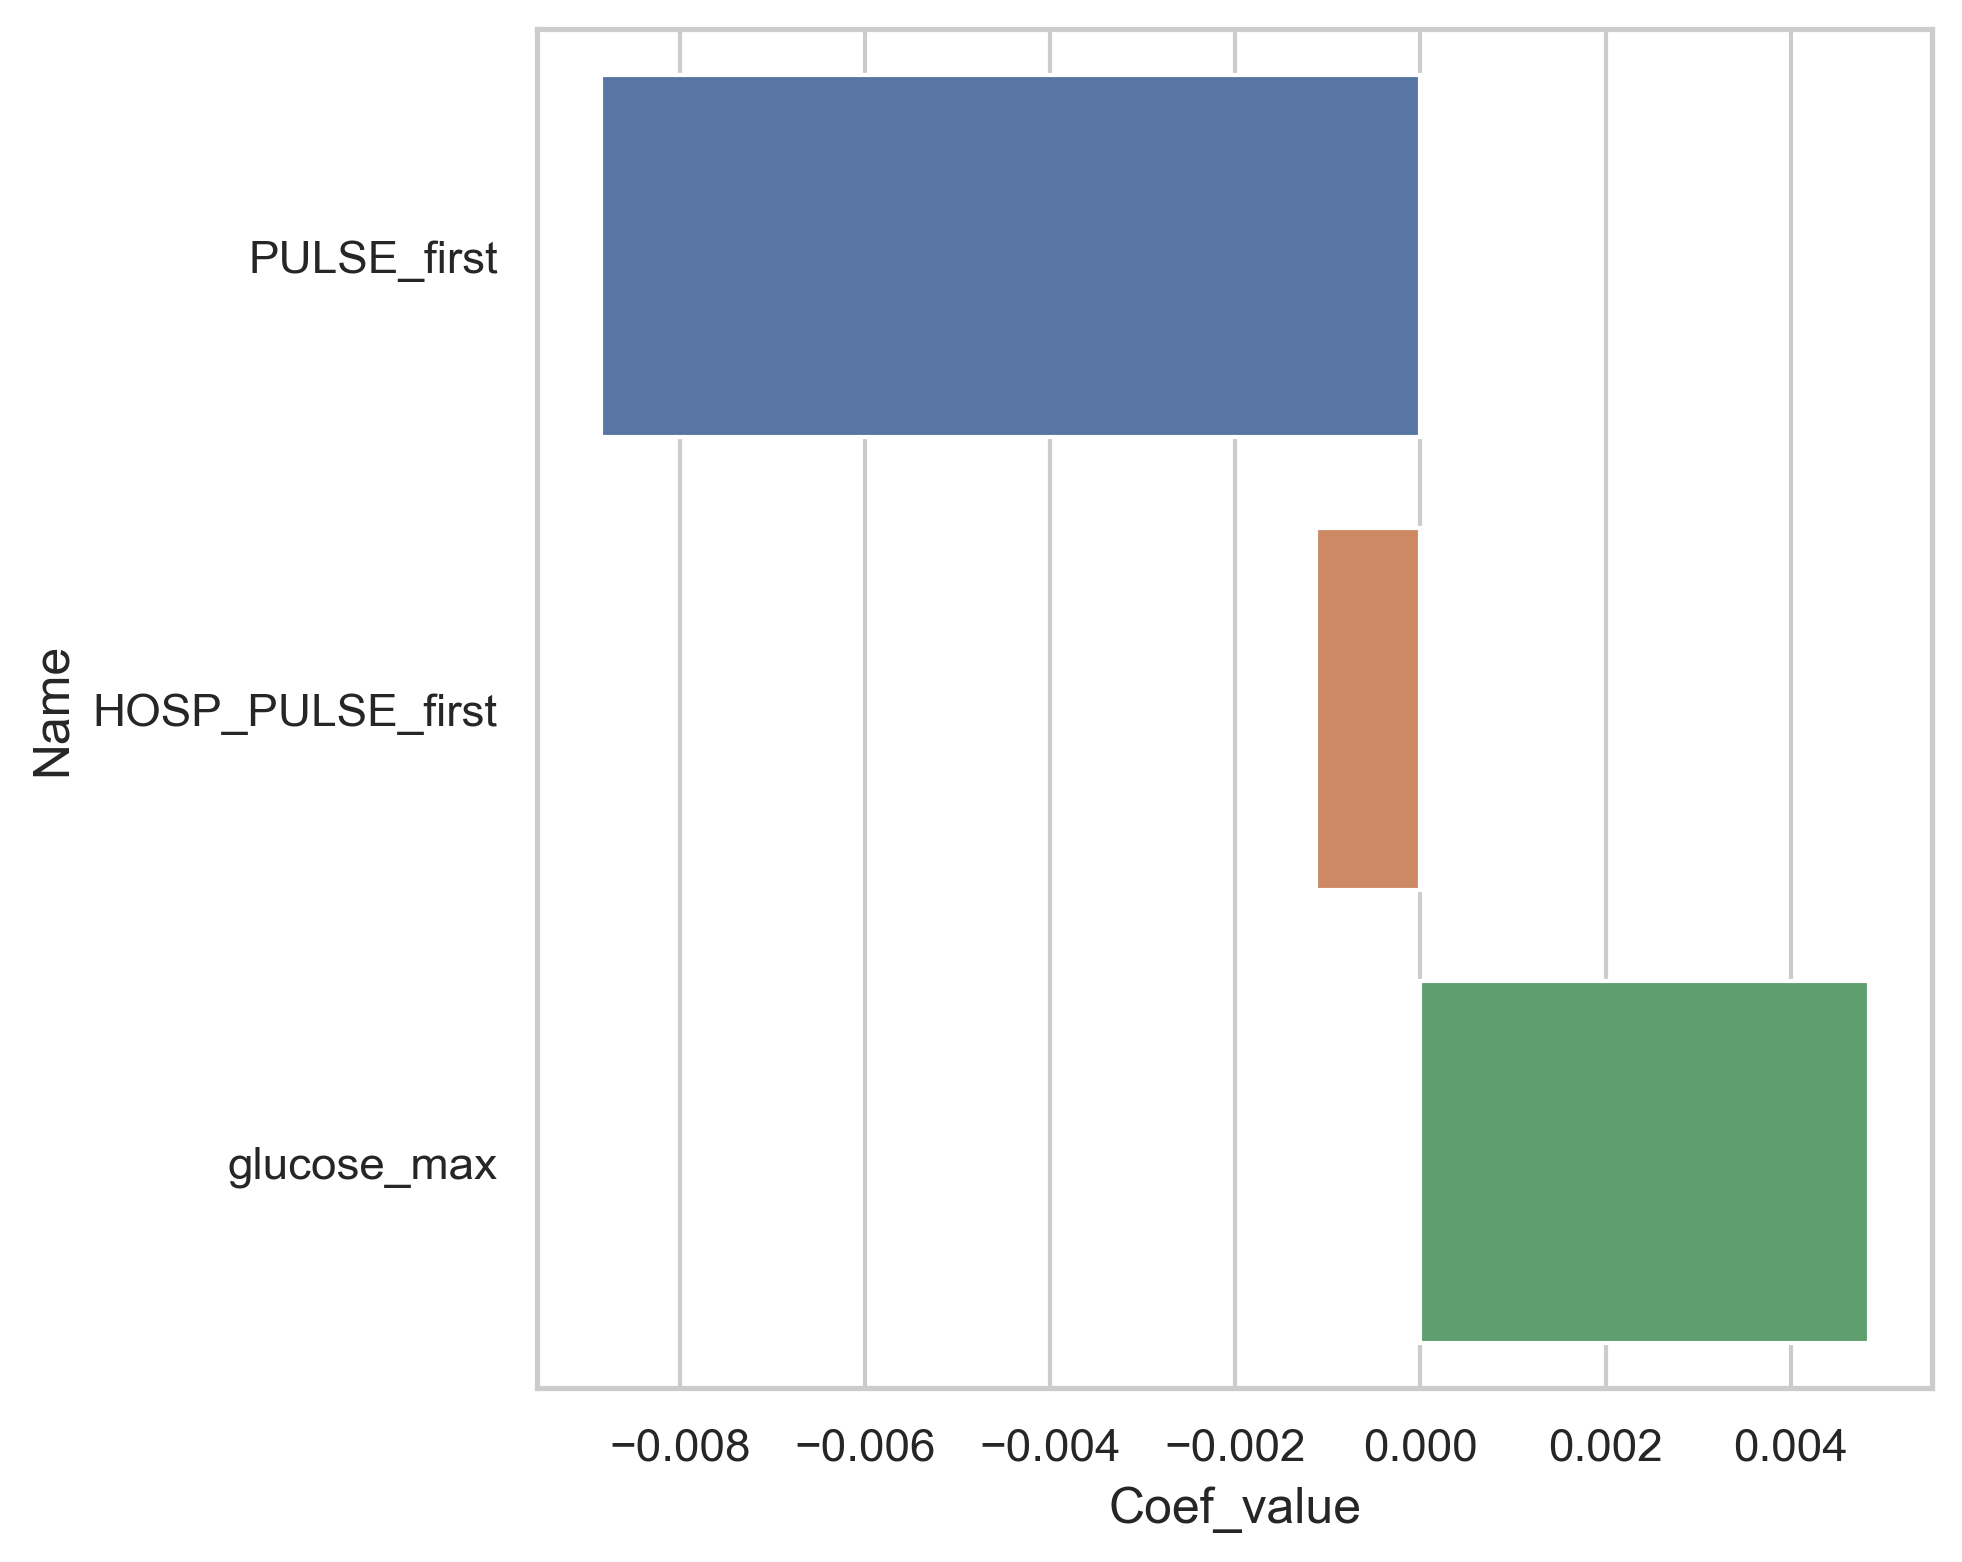

In [242]:
#clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
clf,select_feats = build_L1_model(X,y,0.0045)
visualize_model(clf,select_feats)

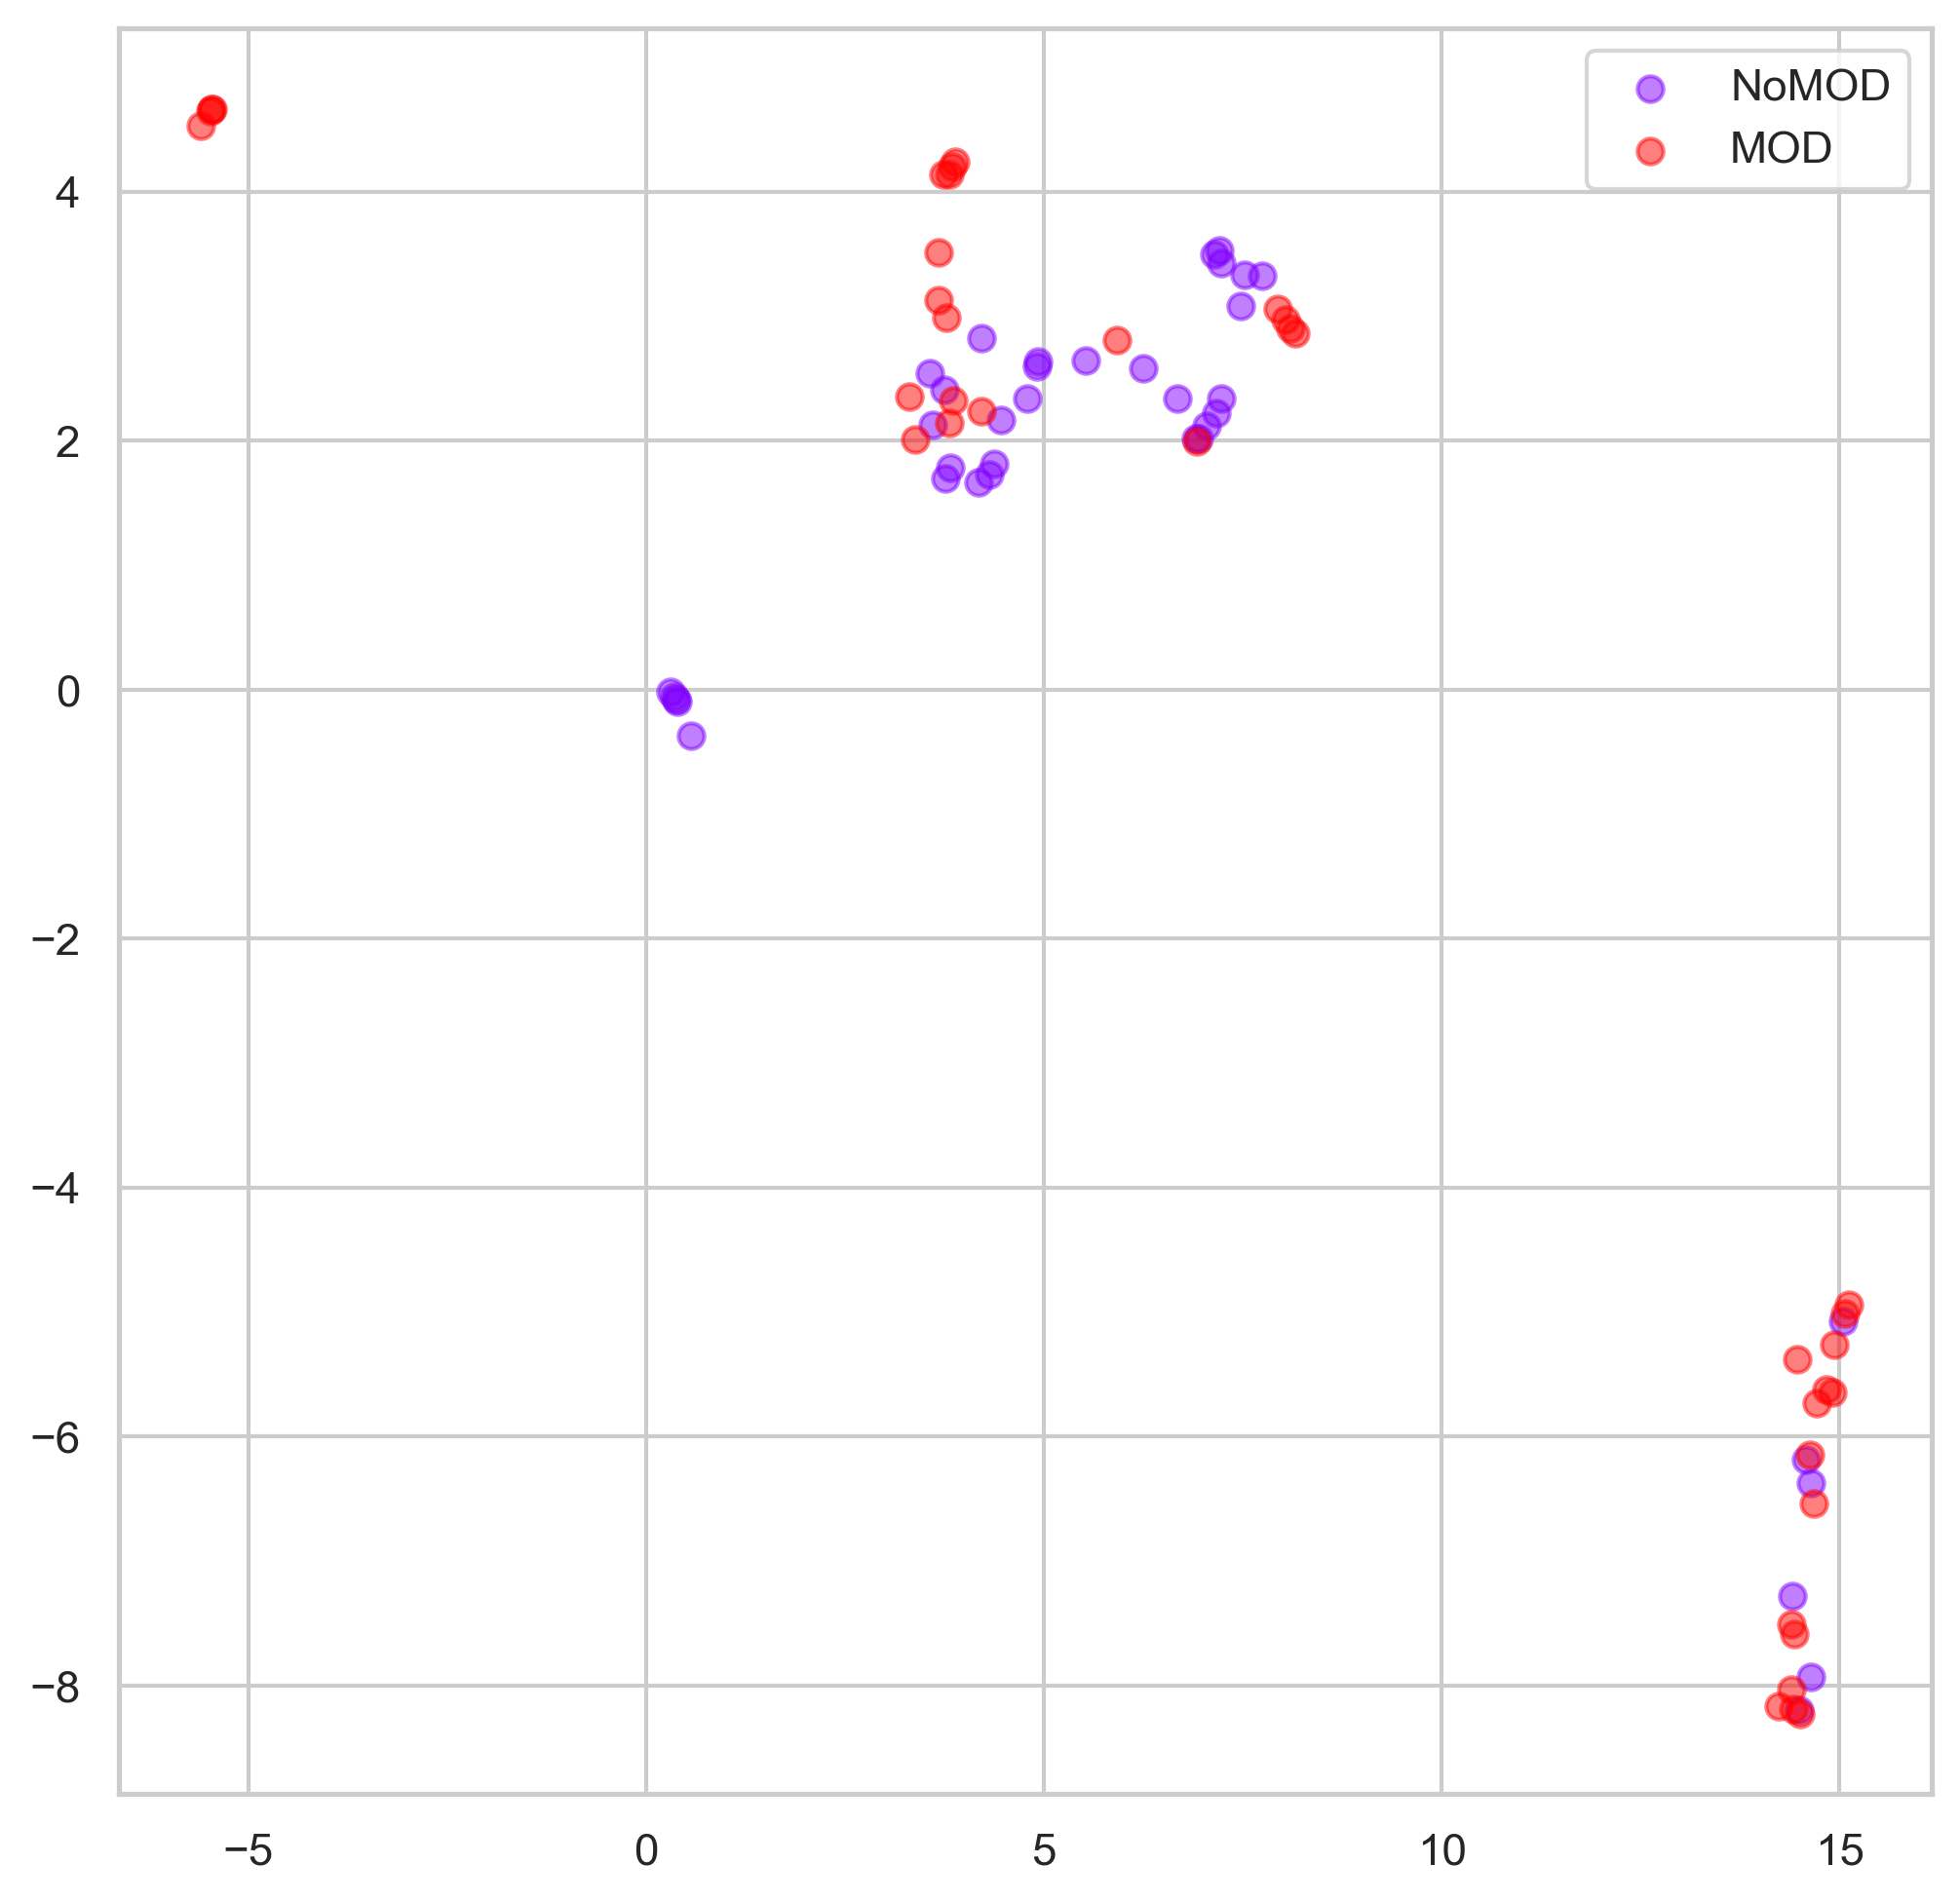

In [243]:
# umap it all
u = umap_plot_label(X,yy,1,7,['NoMOD','MOD'],'upper right')

Cluster  1
NoMOD    18
MOD      12
Name: label, dtype: int64
Cluster  2
MOD      15
NoMOD     6
Name: label, dtype: int64
Cluster  3
MOD    4
Name: label, dtype: int64
Cluster  4
NoMOD    14
MOD       6
Name: label, dtype: int64


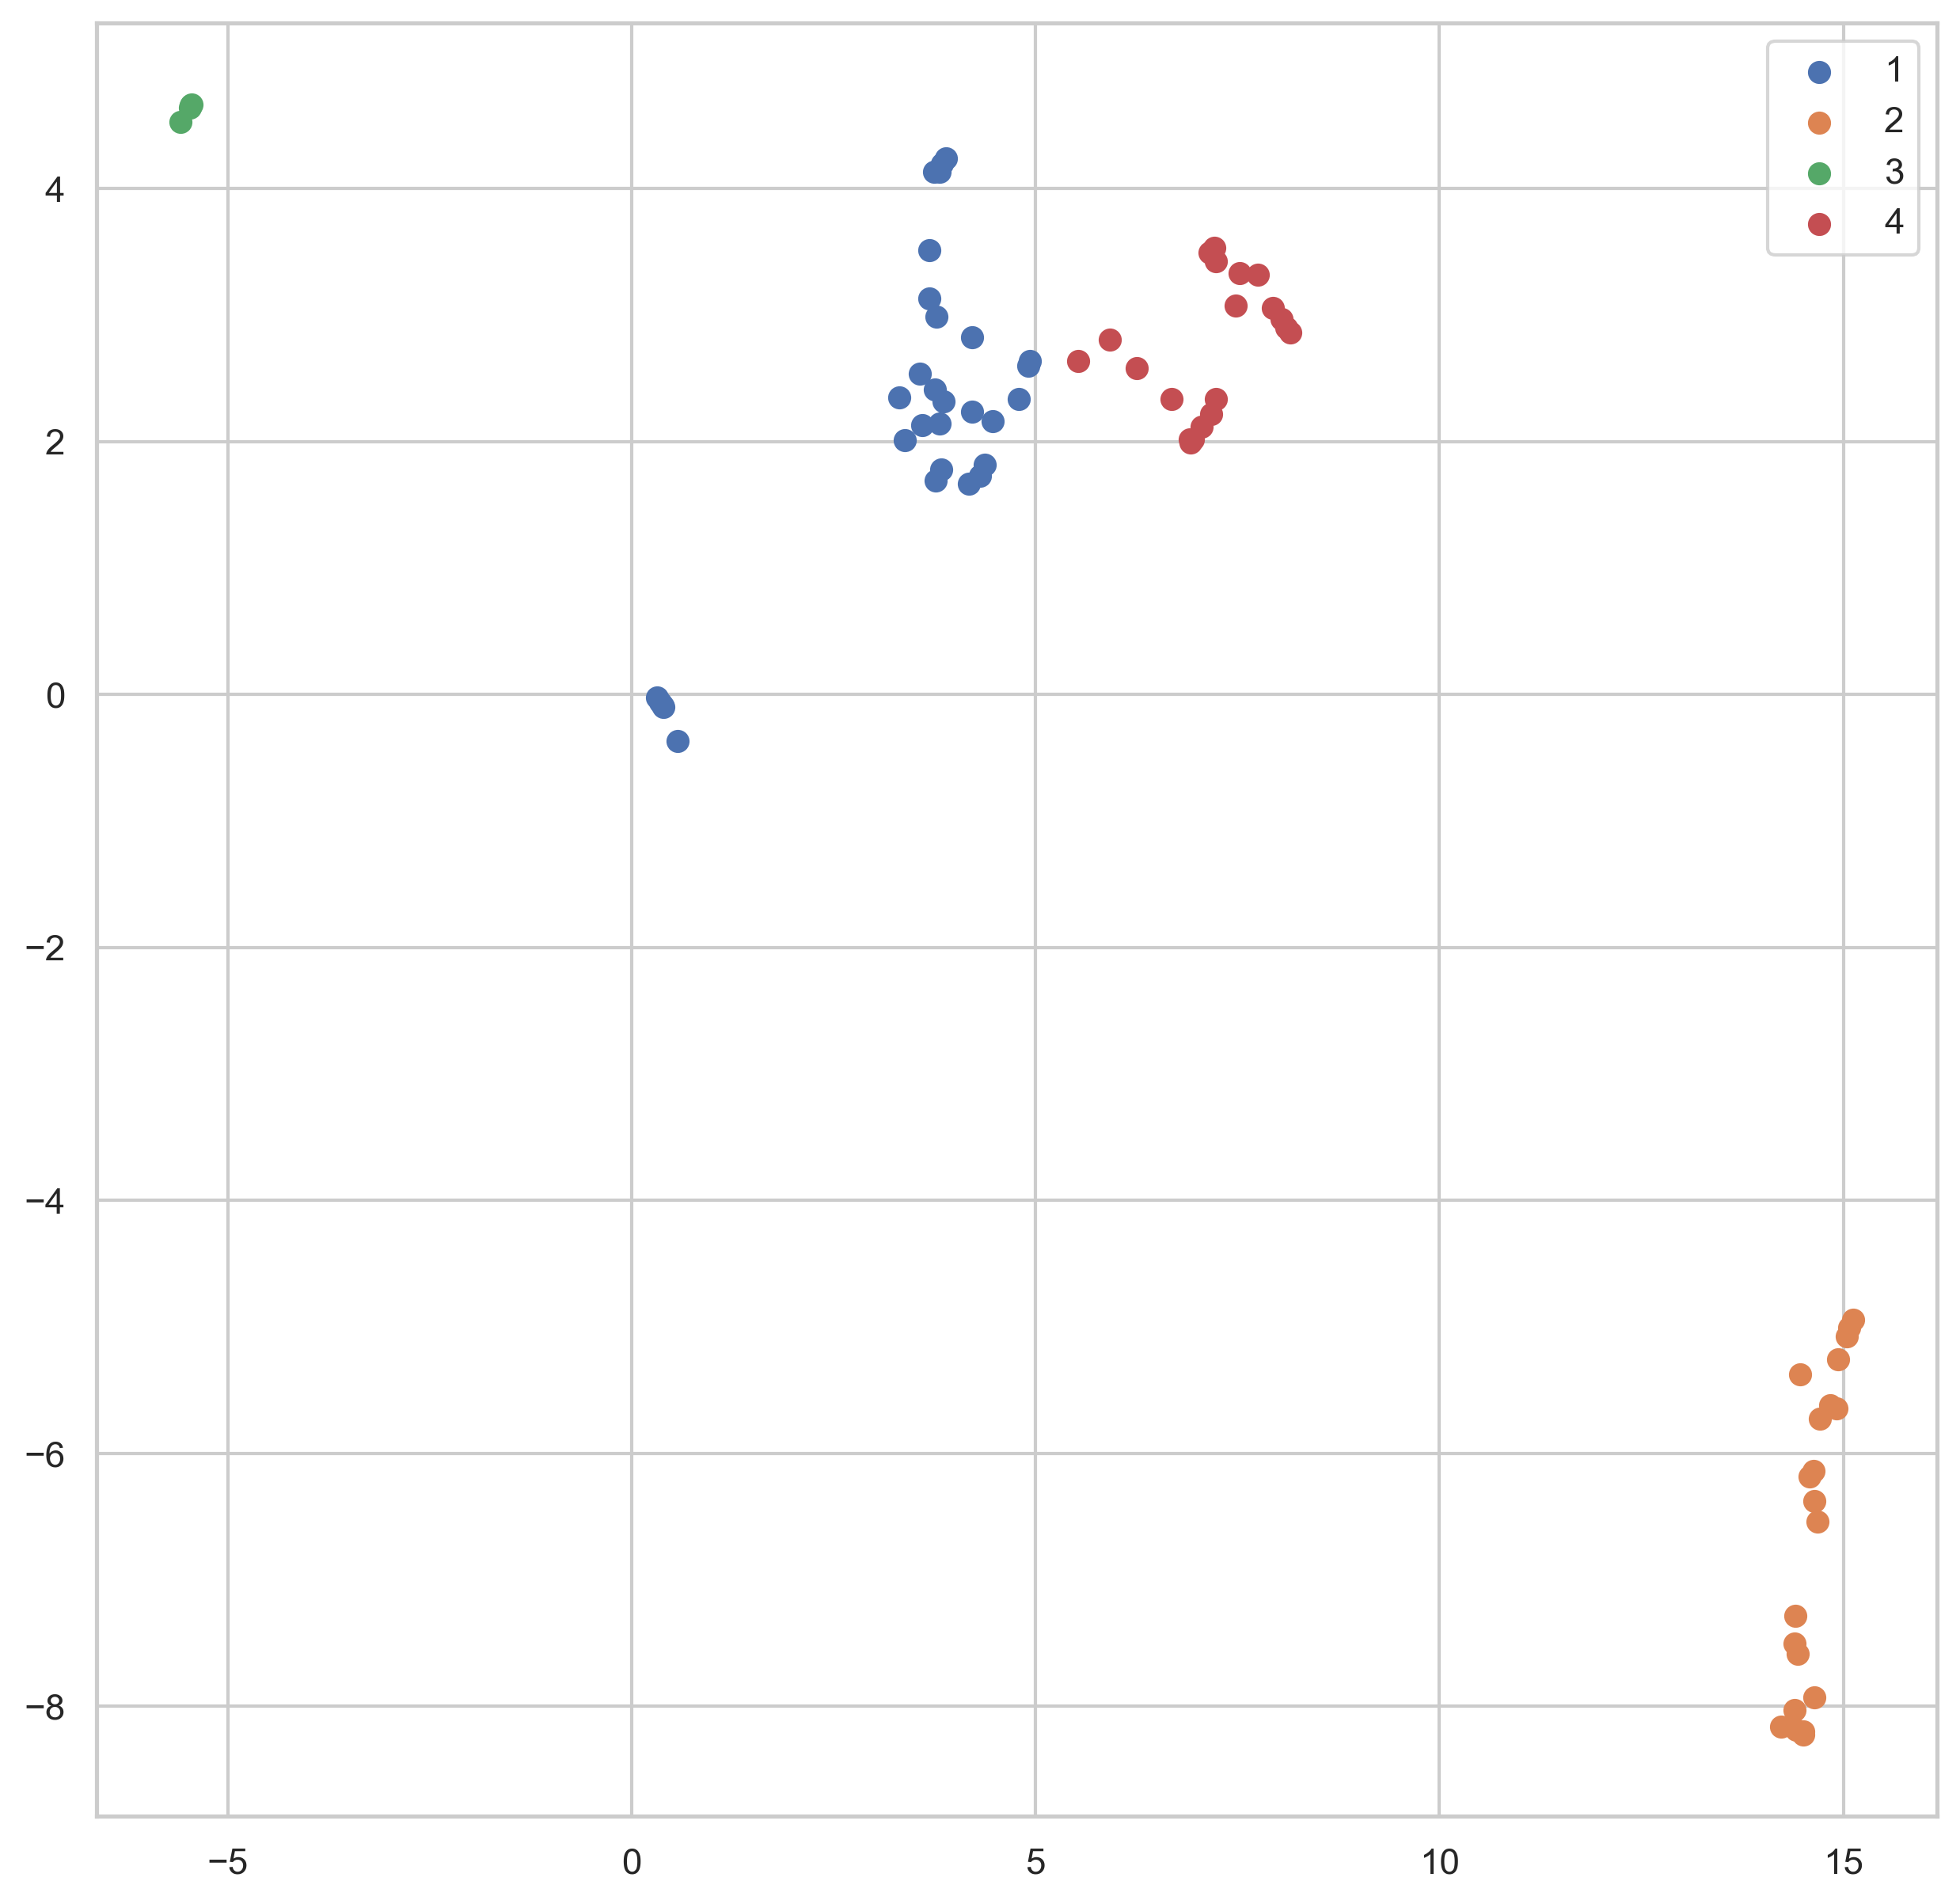

In [244]:
c = cluster_umap(u,4,tmp,'upper right')

In [245]:
#stat_cols = featimp.iloc[:5].index
analyze_clusters(c,tmp,select_feats)

median statistics of cluster  0
NoMOD    18
MOD      12
Name: label, dtype: int64


PULSE_first          68.0
HOSP_PULSE_first     65.5
glucose_max         106.5
Name: 50%, dtype: float64

median statistics of cluster  1
MOD      15
NoMOD     6
Name: label, dtype: int64


PULSE_first          75.0
HOSP_PULSE_first     75.0
glucose_max         236.0
Name: 50%, dtype: float64

median statistics of cluster  2
MOD    4
Name: label, dtype: int64


PULSE_first          72.0
HOSP_PULSE_first     65.0
glucose_max         429.0
Name: 50%, dtype: float64

median statistics of cluster  3
NoMOD    14
MOD       6
Name: label, dtype: int64


PULSE_first          87.0
HOSP_PULSE_first     73.0
glucose_max         134.5
Name: 50%, dtype: float64

In [246]:
# find those rows in limit_dizzy_all that have nulls
null_val_rows = limit_dizzy_all[limit_dizzy_all.isnull().any(axis=1)].copy()
null_val_rows.shape

(7, 29)

In [247]:
for gcol in ['glucose_min','glucose_max']:
    vals = limit_dizzy_all.groupby('label')[gcol].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(gcol,mod_val,nomod_val)                                     

glucose_min 156.0 126.0
glucose_max 171.0 126.0


In [248]:
null_val_rows.loc[null_val_rows.label=='MOD','glucose_min'] = 156
null_val_rows.loc[null_val_rows.label=='MOD','glucose_max'] = 171
null_val_rows.loc[null_val_rows.label=='NoMOD','glucose_min'] = 126
null_val_rows.loc[null_val_rows.label=='NoMOD','glucose_max'] = 126

In [249]:
# predict on null_val_rows
print(clf.predict(null_val_rows.iloc[:,2:]))
print(null_val_rows['label'])

[1 1 0 0 0 0 1]
12      MOD
22      MOD
60    NoMOD
61    NoMOD
62    NoMOD
63    NoMOD
65    NoMOD
Name: label, dtype: object


In [260]:
print(all_dizzy_all.shape)
abcols = ['WBC_abnormal_count','glucose_count','glucose_abnormal_count','albumin_abnormal_count','CO2_count',
        'alkphos_abnormal_count','hgb_abnormal_count']
for abcol in abcols:
    all_dizzy_all[abcol] = all_dizzy_all[abcol].fillna(0)



for col in all_dizzy_all.columns[1:]:
    v = all_dizzy_all[col].isna().sum()
    if v > 0:
        print(col,v )
    
print(all_dizzy_all.shape)

# find those rows in all_dizzy_all that have null
all_null_val_rows = all_dizzy_all[all_dizzy_all.isnull().any(axis=1)].copy()
print(all_null_val_rows.shape)

for gcol in ['glucose_min','glucose_max']:
    vals = all_dizzy_all[gcol].describe()[['50%']]
    g_val = vals['50%']
   
    print(gcol,g_val)     
    
# fill in glucose values that are medians across the entire set.
all_null_val_rows.loc[:,'glucose_min'] = 134
all_null_val_rows.loc[:,'glucose_max'] = 135


tmp1 = pd.concat([all_dizzy_all.dropna(),all_null_val_rows])
print(tmp1.iloc[:,1:].shape)
for col in tmp1.columns[1:]:
    v = tmp1[col].isna().sum()
    if v > 0:
        print(col,v )

print('Logistic regression prediction:')
ypred1 = clf.predict(tmp1.iloc[:,1:])
display(pd.merge(tmp1[ypred1==1].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())
display(pd.merge(tmp1[ypred1==0].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())

print('Random forest prediction:')
ypred1 = rf.predict(tmp1.iloc[:,1:])
display(pd.merge(tmp1[ypred1==1].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())
display(pd.merge(tmp1[ypred1==0].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())

(195, 28)
glucose_min 18
glucose_max 18
(195, 28)
(18, 28)
glucose_min 134.0
glucose_max 135.0
(195, 27)
Logistic regression prediction:


MOD         21
CodingEr     9
NoMOD        7
PMOD         2
Name: label, dtype: int64

NoMOD    36
MOD      18
PMOD      7
Name: label, dtype: int64

Random forest prediction:


MOD         36
CodingEr     5
PMOD         4
NoMOD        3
Name: label, dtype: int64

NoMOD       40
PMOD         5
CodingEr     4
MOD          3
Name: label, dtype: int64

In [134]:
ypred1 =rf.predict(tmp1.iloc[:,1:])
display(pd.merge(tmp1[ypred1==1].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())
display(pd.merge(tmp1[ypred1==0].PtSSN,dizzy_labels_df,on='PtSSN')['label'].value_counts())

MOD         35
CodingEr     5
PMOD         4
NoMOD        3
Name: label, dtype: int64

NoMOD       40
PMOD         5
MOD          4
CodingEr     4
Name: label, dtype: int64

In [65]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(max_depth=7,criterion='entropy')
scores = cross_val_score(dt,tmp.iloc[:,2:],y)
print(np.mean(scores),np.std(scores))

0.6799999999999999 0.08844332774281068


In [255]:
# train and test on all 75 labeled records
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,max_depth=3)
y = np.array([1 if x=='MOD' else 0 for x in tmp.label])
rf.fit(tmp.iloc[:,2:],y)
ypred = rf.predict(tmp.iloc[:,2:])
metrics.confusion_matrix(y,ypred)

array([[36,  2],
       [ 2, 35]], dtype=int64)

In [256]:
rf.predict(null_val_rows.iloc[:,2:])

array([0, 1, 0, 0, 0, 0, 1])

C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


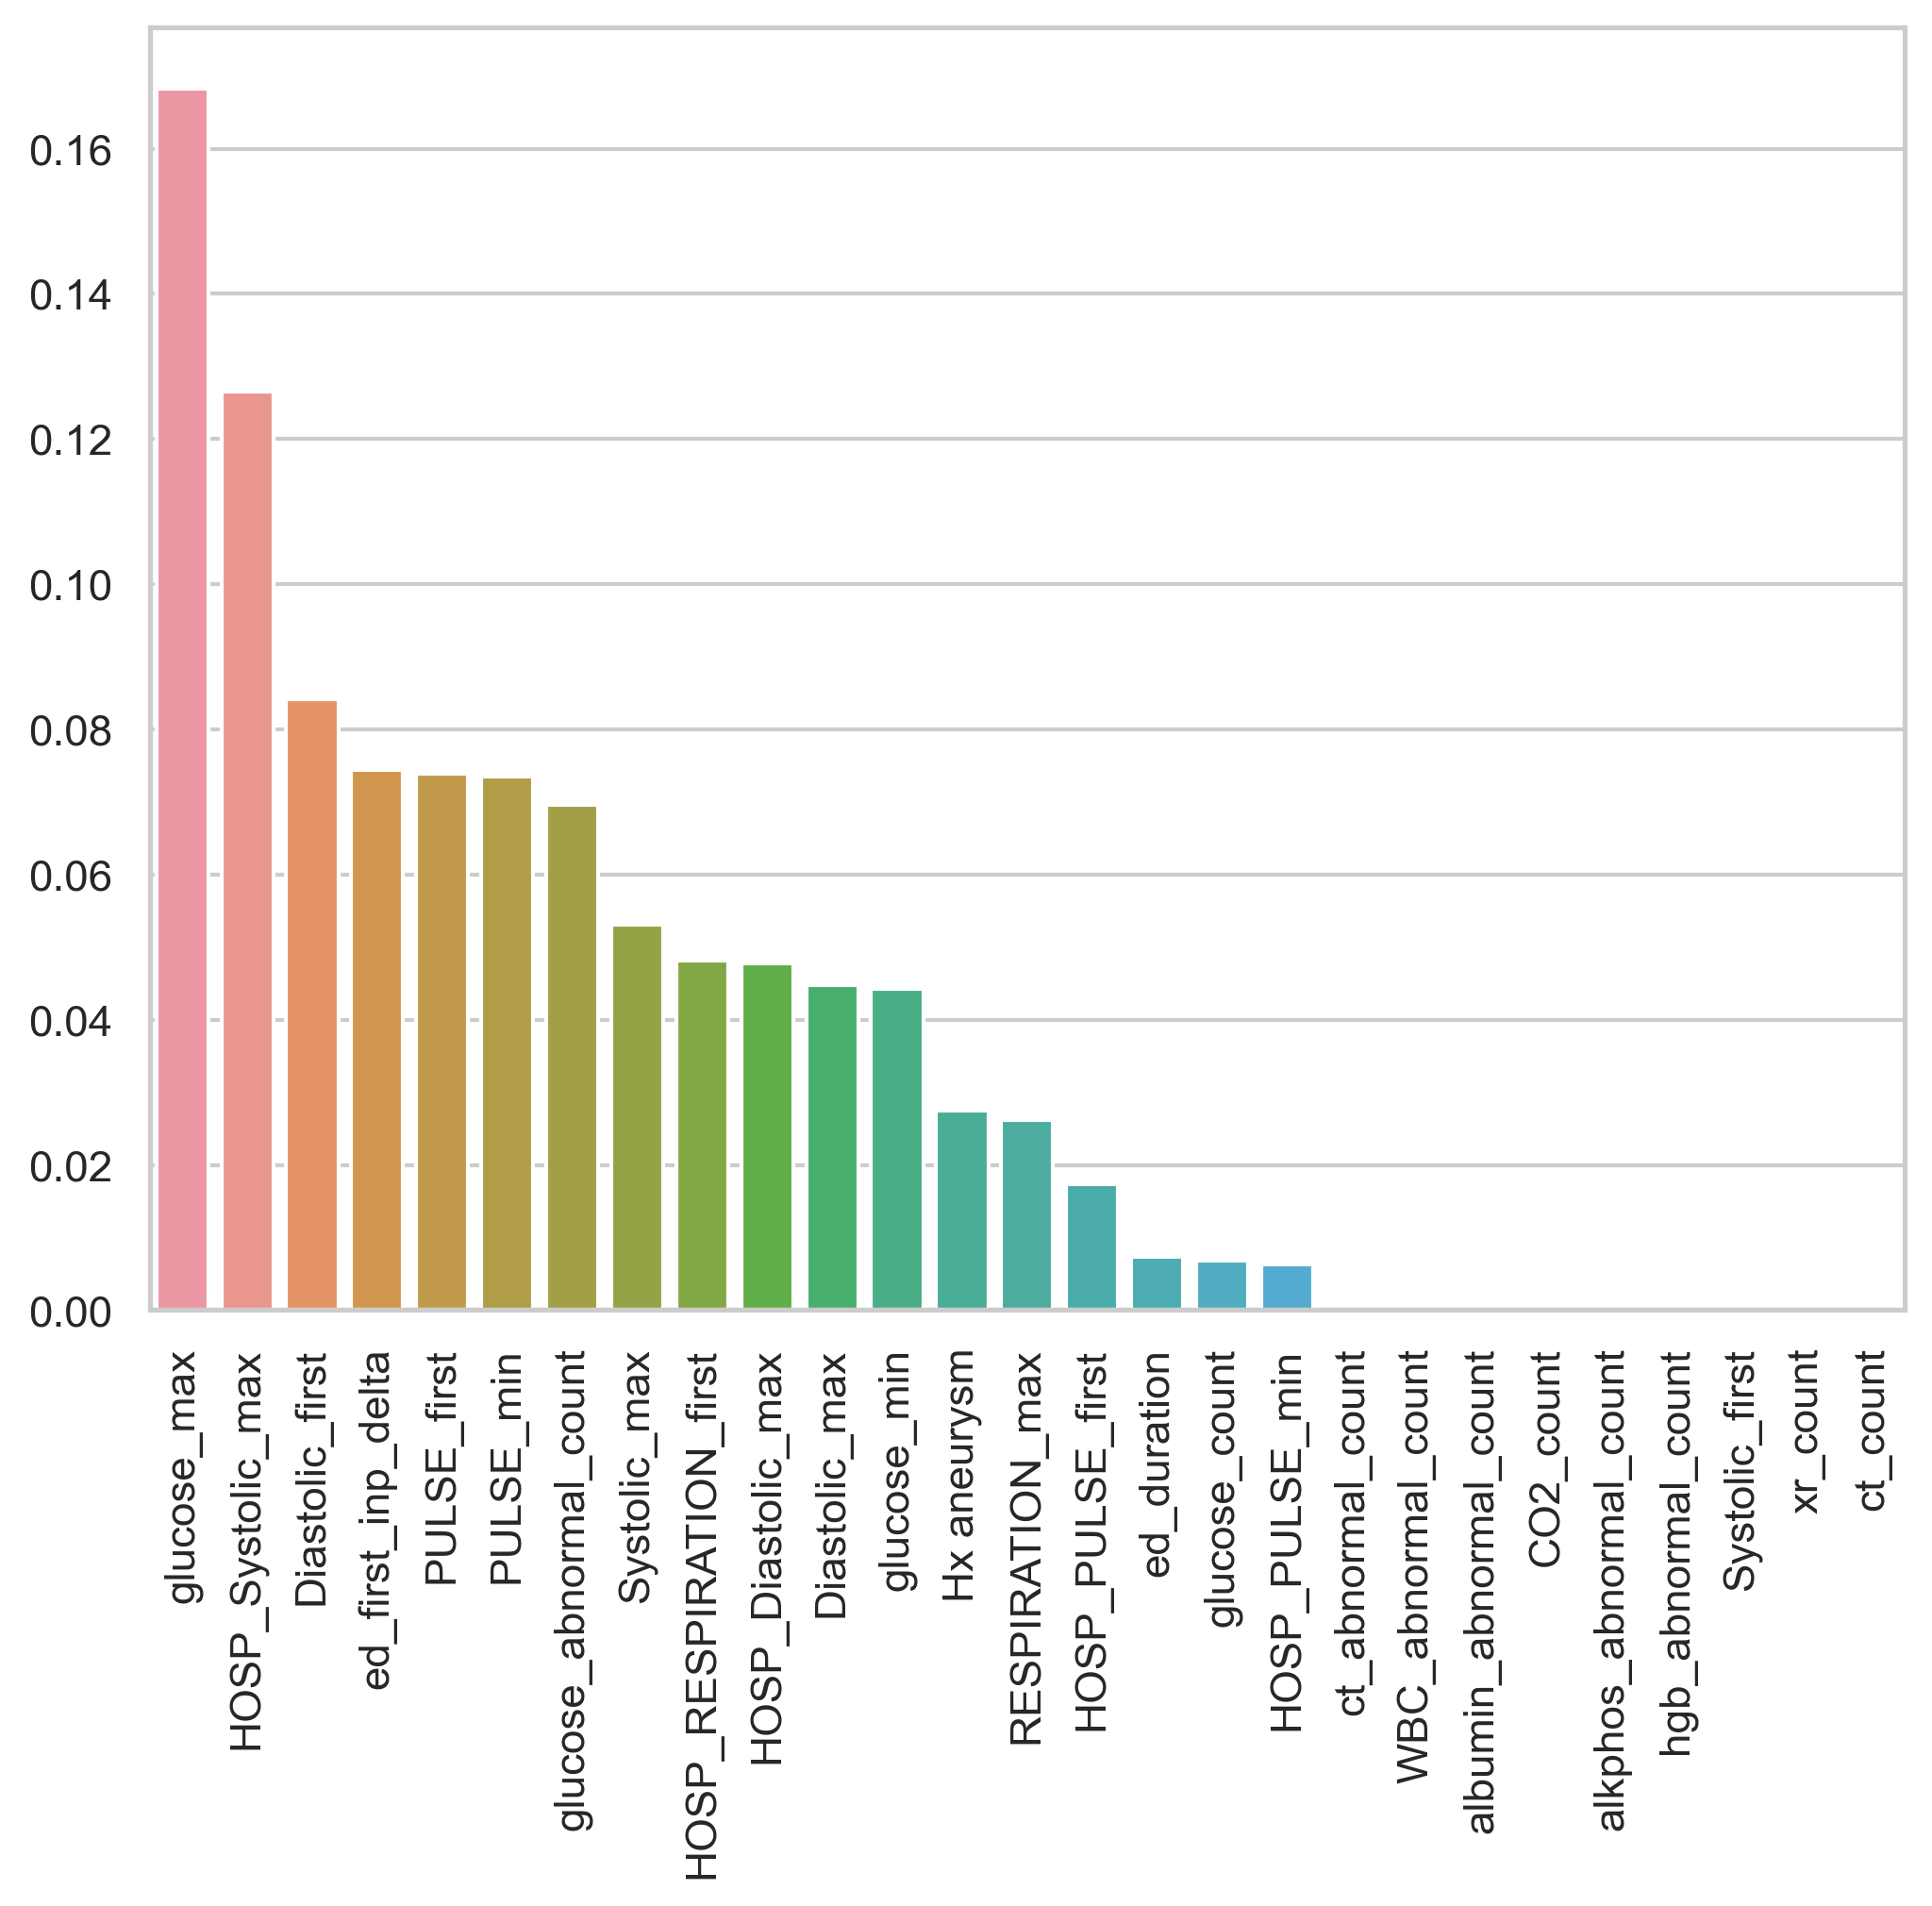

In [257]:
featimp = pd.Series(rf.feature_importances_,index=tmp.columns[2:]).sort_values(ascending=False)
import seaborn as sns

plt.figure(figsize=(8,6))
myplot = sns.barplot(featimp.index,featimp.values)
myplot.set_xticklabels(myplot.get_xticklabels(),rotation = 90);

In [75]:
# now do an 80-20 split; and run train/test
Xtrain,Xtest,ytrain,ytest = train_test_split(tmp.iloc[:,2:],y,stratify=y,test_size=0.1)
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)
rf = RandomForestClassifier(n_estimators=7,max_depth=4)
rf.fit(Xtrain,ytrain)
ypred = rf.predict(Xtest)
print(metrics.confusion_matrix(ytest,ypred))
print('AUC = ',metrics.roc_auc_score(ytest,ypred))
print('F1 = ',metrics.f1_score(ytest,ypred))
print('Accuracy = ',metrics.accuracy_score(ytest,ypred))

(67, 27) (8, 27) (67,) (8,)
[[3 1]
 [1 3]]
AUC =  0.75
F1 =  0.75
Accuracy =  0.75


In [258]:
ypred_all = rf.predict(pd.concat([tmp.iloc[:,2:],null_val_rows.iloc[:,2:]]))
y_all = [1 if x =='MOD' else 0 for x in tmp.label] + [1 if x=='MOD' else 0 for x in null_val_rows.label]
metrics.confusion_matrix(y_all,ypred_all)

array([[40,  3],
       [ 3, 36]], dtype=int64)

C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


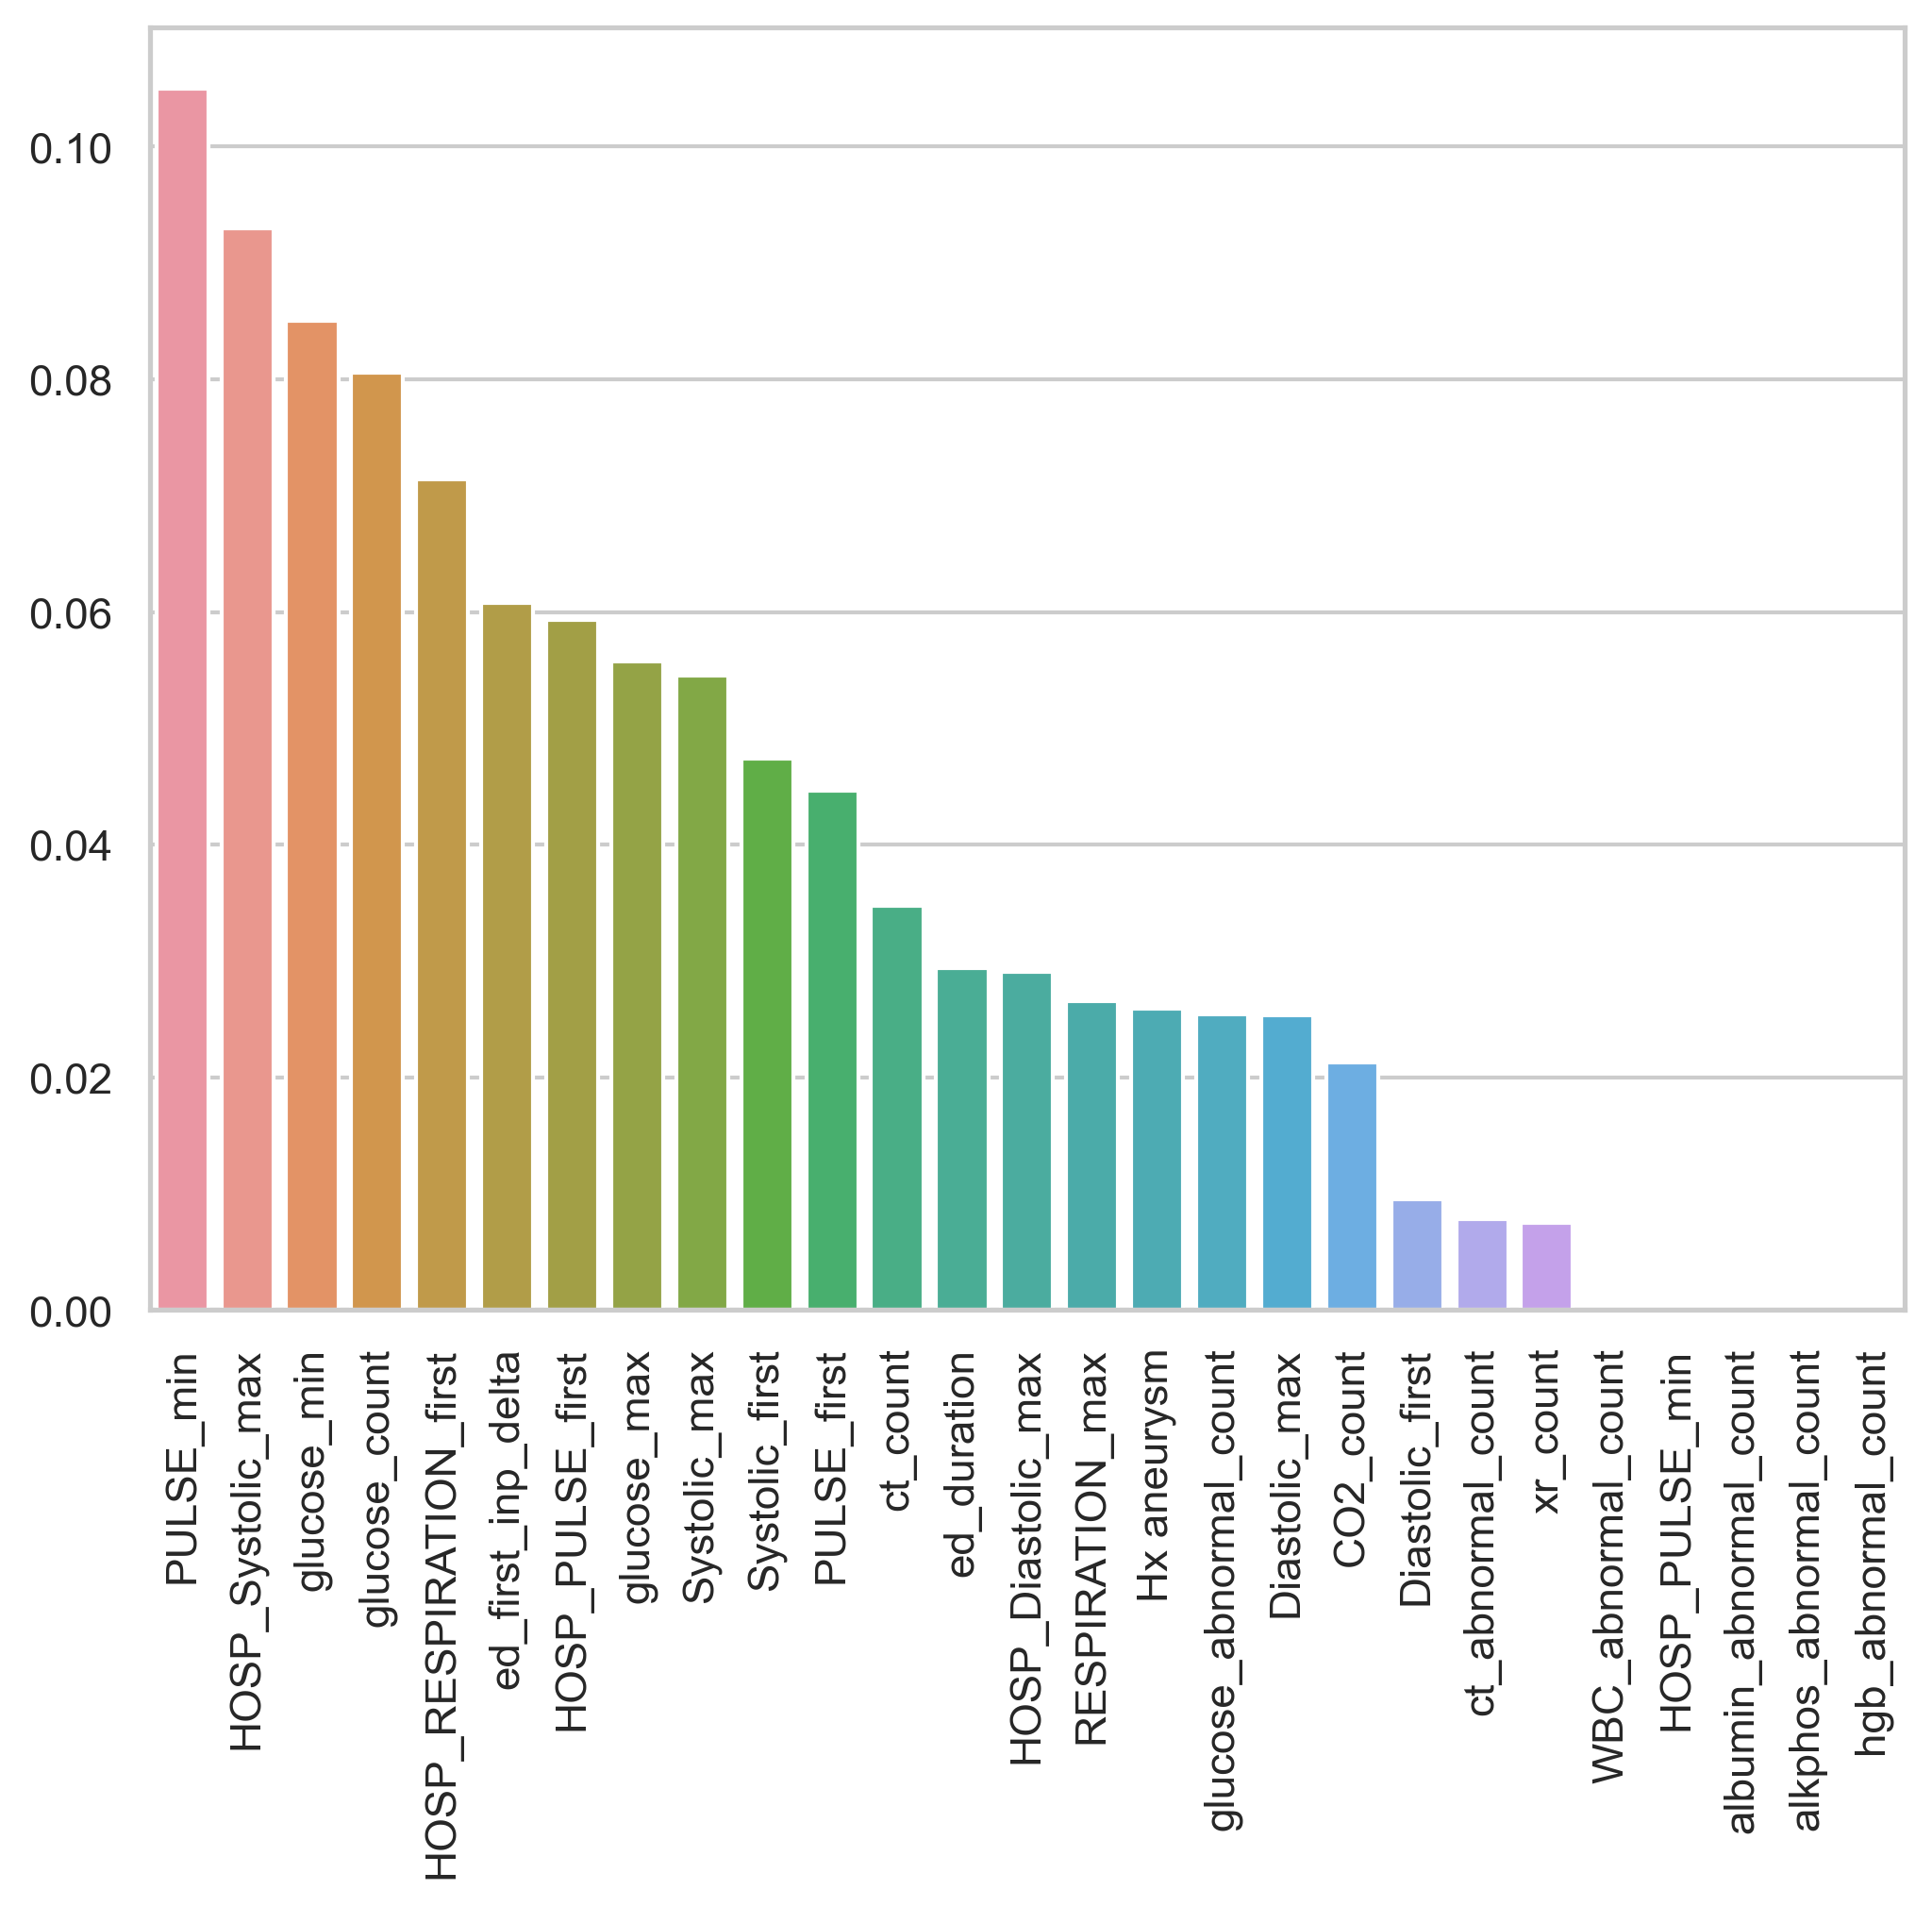

In [77]:
featimp = pd.Series(rf.feature_importances_,index=tmp.columns[2:]).sort_values(ascending=False)
import seaborn as sns

plt.figure(figsize=(8,6))
myplot = sns.barplot(featimp.index,featimp.values)
myplot.set_xticklabels(myplot.get_xticklabels(),rotation = 90);

# Classify unlabeled records in dizzy

In [266]:
tmp1.shape

(195, 28)

In [267]:
for col in tmp1.columns[1:]:
    v = tmp1[col].isna().sum()
    if v > 0:
        print(col,v )


In [279]:
tmp2.columns

Index(['PtSSN', 'ed_duration', 'ed_first_inp_delta', 'Systolic_max',
       'Systolic_first', 'Diastolic_max', 'Diastolic_first', 'PULSE_min',
       'PULSE_first', 'RESPIRATION_max', 'HOSP_Systolic_max',
       'HOSP_Diastolic_max', 'HOSP_PULSE_min', 'HOSP_PULSE_first',
       'HOSP_RESPIRATION_first', 'WBC_abnormal_count', 'glucose_count',
       'glucose_min', 'glucose_max', 'glucose_abnormal_count',
       'albumin_abnormal_count', 'CO2_count', 'alkphos_abnormal_count',
       'hgb_abnormal_count', 'xr_count', 'ct_count', 'ct_abnormal_count',
       'Hx aneurysm', 'label'],
      dtype='object')

(195, 29)


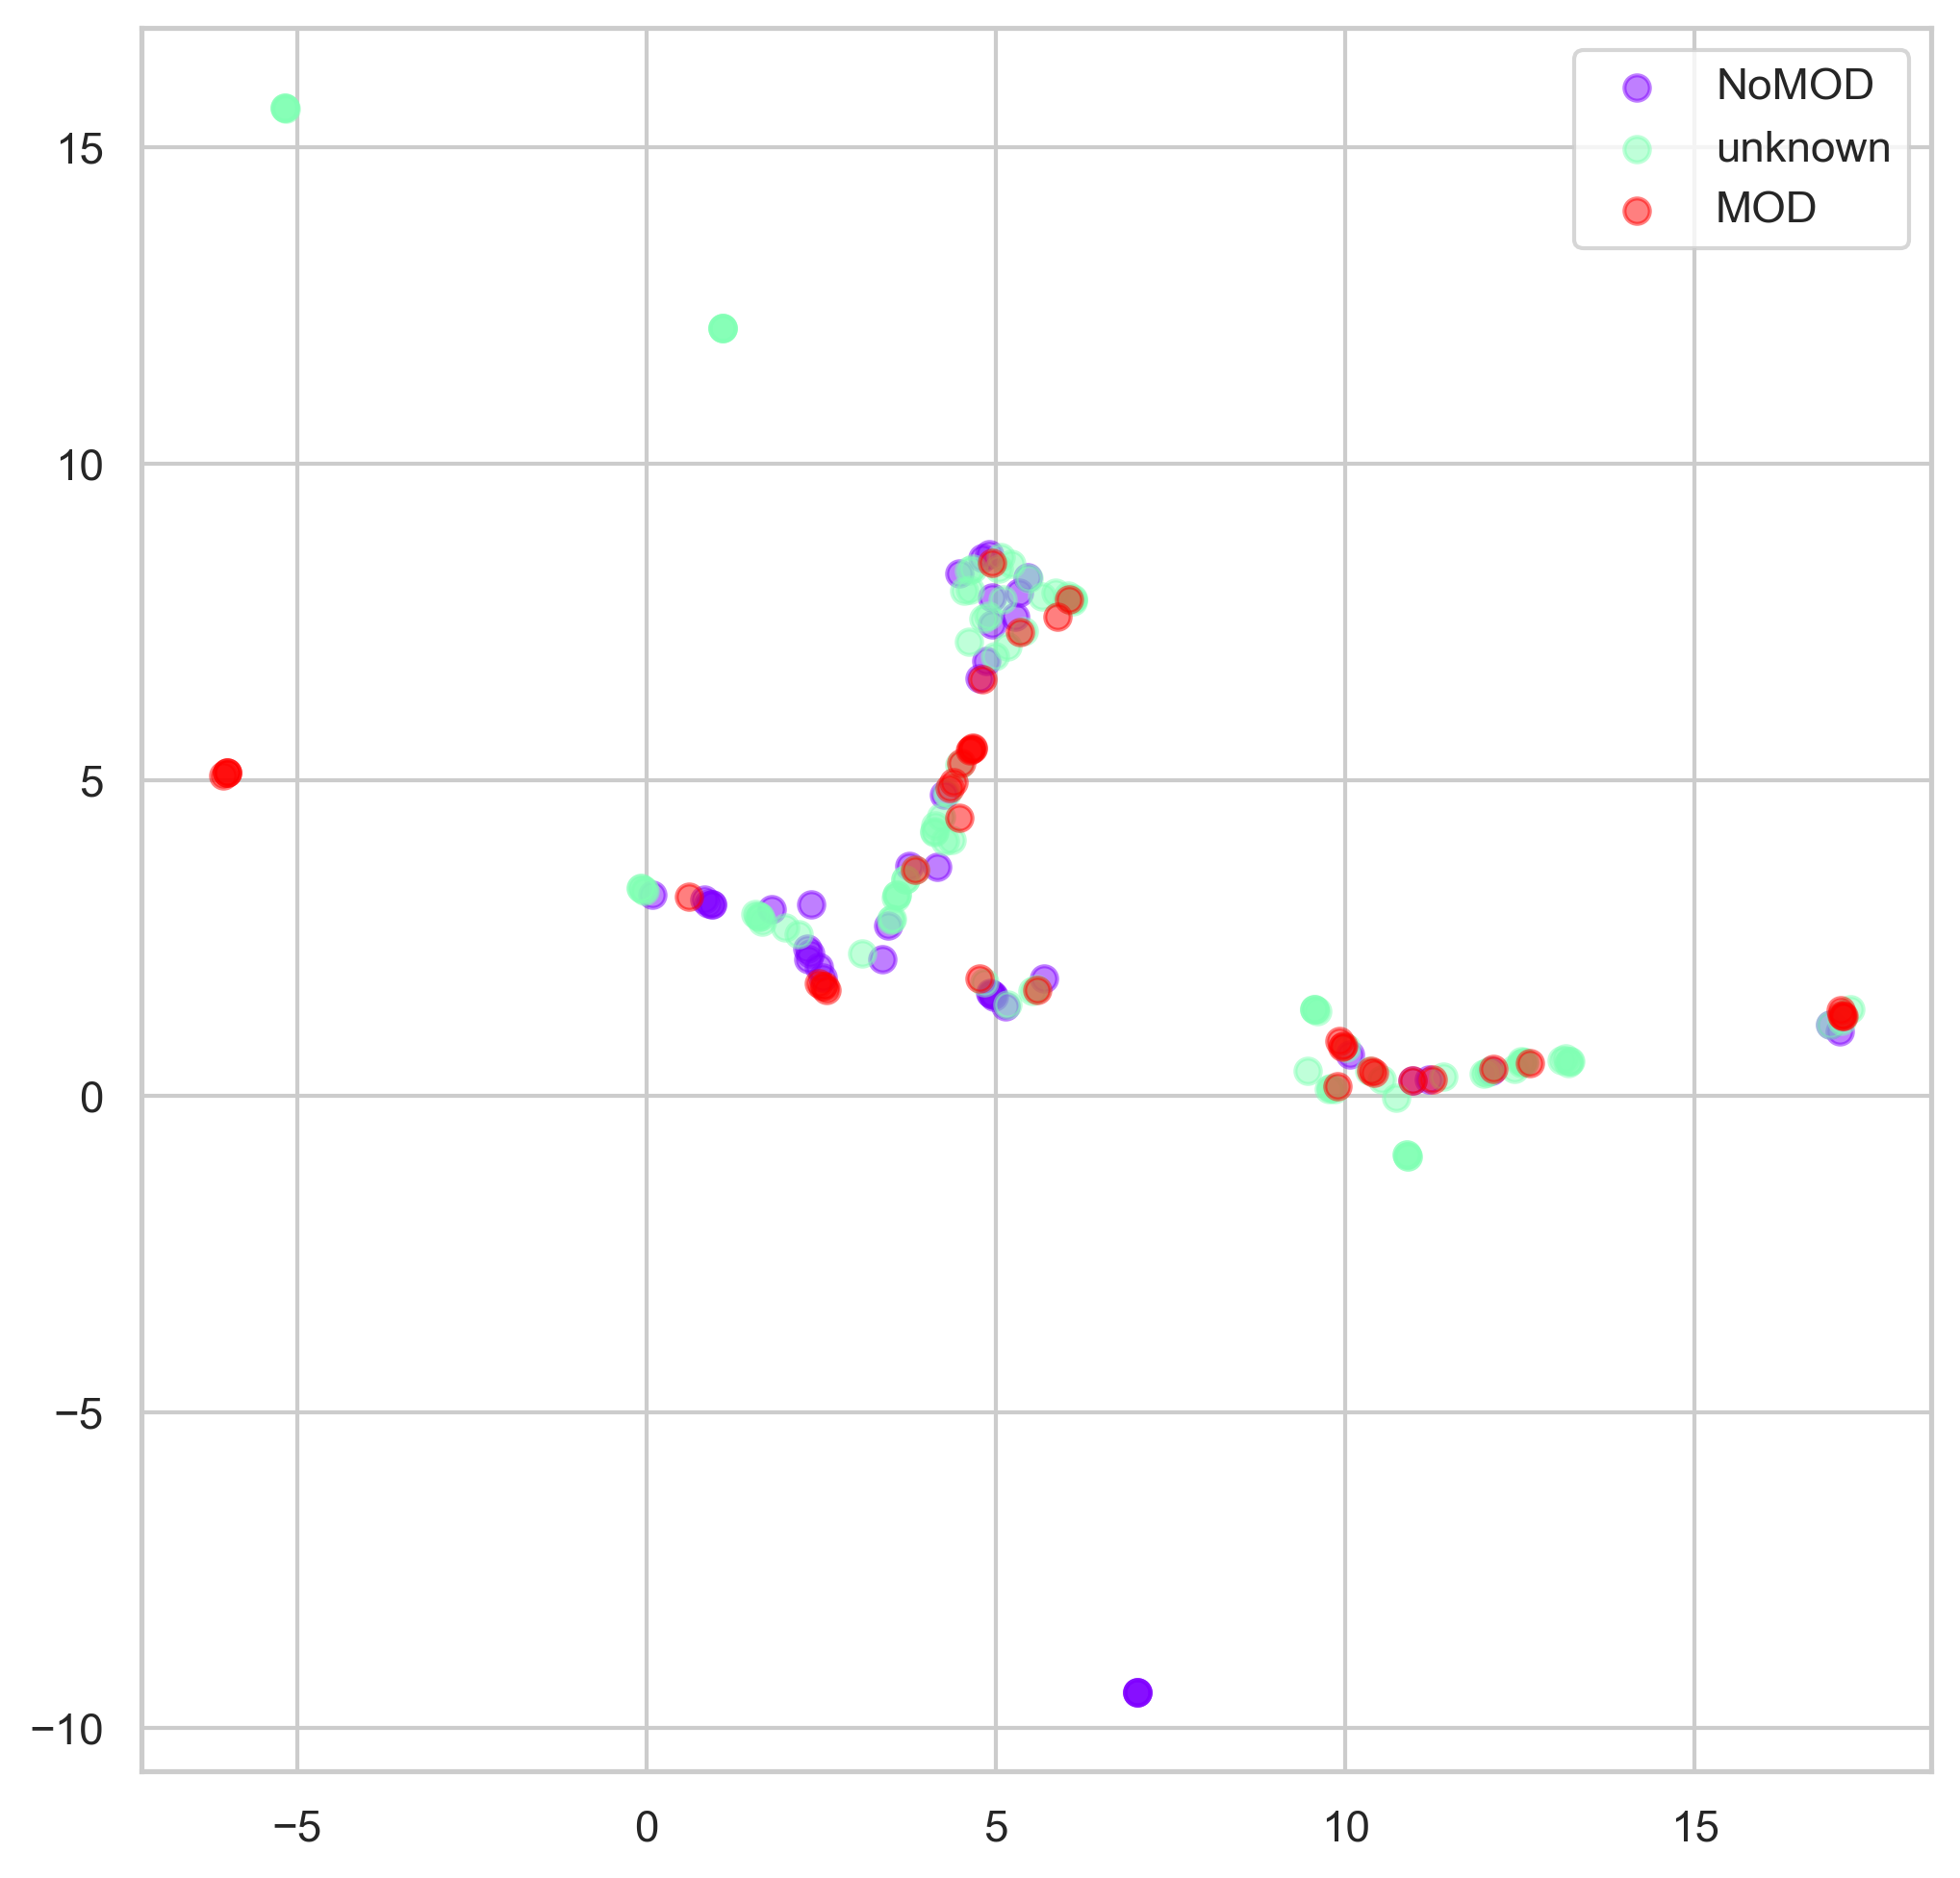

In [292]:
# merge to create temp labels
tmp2 = pd.merge(tmp1,dizzy_labels_df,on='PtSSN',how='left')
print(tmp2.shape)
#display(tmp2.label.value_counts())
len(set(dizzy_labels_df.PtSSN).difference(tmp2.PtSSN))
tmp2.label = tmp2.label.fillna('unknown')
tmp3 = tmp2[tmp2.label.isin(['MOD','NoMOD','unknown'])]


u = umap_plot_label(tmp3.iloc[:,1:-1],tmp3.label,4,7,['NoMOD','unknown','MOD'],'upper right');


Cluster  1
unknown    34
MOD        14
NoMOD      10
Name: label, dtype: int64
Cluster  2
unknown    53
NoMOD      33
MOD        21
Name: label, dtype: int64
Cluster  3
unknown    8
MOD        4
Name: label, dtype: int64


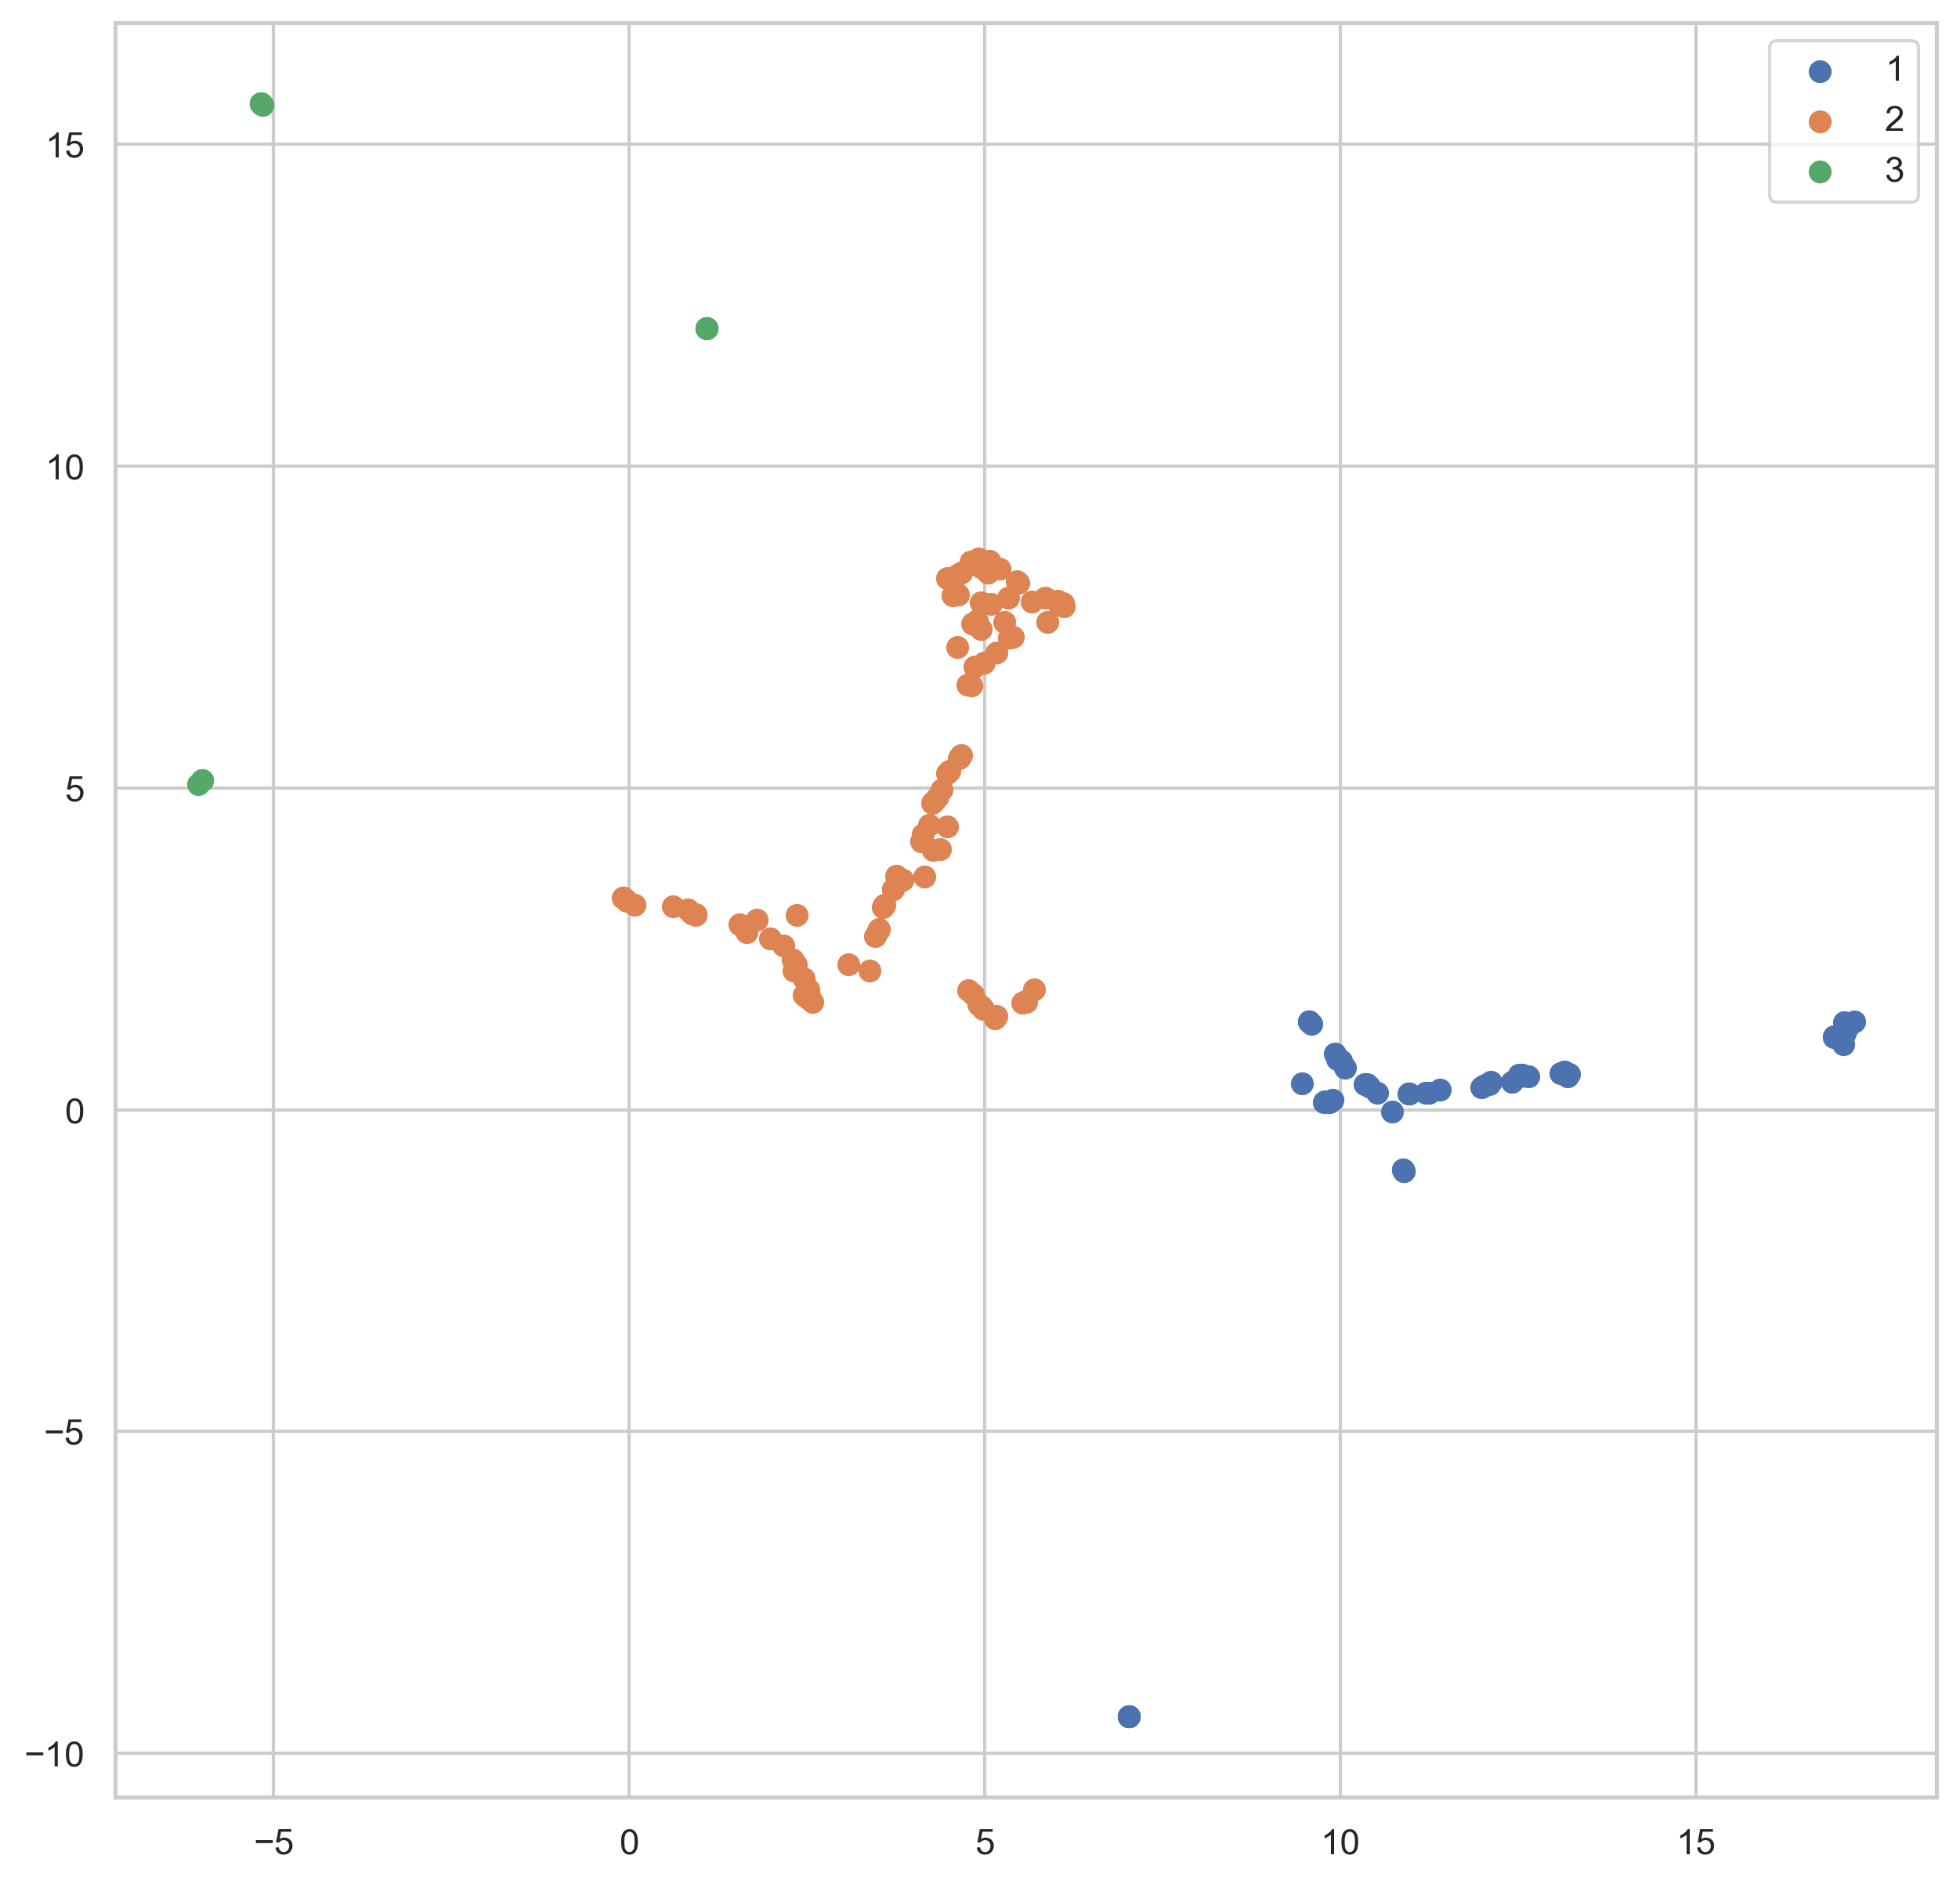

In [294]:
c = cluster_umap(u,3,tmp3,'upper right')

In [304]:
analyze_clusters(c,tmp3,list(featimp.index)[:10])

median statistics of cluster  0
unknown    34
MOD        14
NoMOD      10
Name: label, dtype: int64


glucose_max               246.500000
HOSP_Systolic_max         171.000000
Diastolic_first            83.500000
ed_first_inp_delta          5.271227
PULSE_first                80.000000
PULSE_min                  70.000000
glucose_abnormal_count      2.000000
Systolic_max              166.000000
HOSP_RESPIRATION_first     18.000000
HOSP_Diastolic_max         95.000000
Name: 50%, dtype: float64

median statistics of cluster  1
unknown    53
NoMOD      33
MOD        21
Name: label, dtype: int64


glucose_max               127.000000
HOSP_Systolic_max         165.000000
Diastolic_first            87.000000
ed_first_inp_delta          7.219167
PULSE_first                74.000000
PULSE_min                  71.000000
glucose_abnormal_count      1.000000
Systolic_max              157.000000
HOSP_RESPIRATION_first     18.000000
HOSP_Diastolic_max         92.000000
Name: 50%, dtype: float64

median statistics of cluster  2
unknown    8
MOD        4
Name: label, dtype: int64


glucose_max               173.000000
HOSP_Systolic_max         183.500000
Diastolic_first            74.000000
ed_first_inp_delta         10.726667
PULSE_first                72.000000
PULSE_min                  72.000000
glucose_abnormal_count      2.000000
Systolic_max              159.000000
HOSP_RESPIRATION_first     18.000000
HOSP_Diastolic_max         94.500000
Name: 50%, dtype: float64

In [ ]:
# plot the predicted labels for the unknowns


# Assemble the abdpain_all dataframe

In [305]:
abdpain_cohort_tmp = abdpain_cohort_df_labeled[['PtSSN'] + cohort_fields].drop_duplicates(subset=['PtSSN'])
abdpain_demo_tmp = abdpain_demo_coded_labeled[['PtSSN'] + list(abdpain_demo_coded_labeled.columns[1:-1])].drop_duplicates(subset=['PtSSN'])
abdpain_vitals_tmp = abdpain_EDvitals_labeled[['PtSSN'] + list(abdpain_EDvitals_labeled.columns[2:-1])].drop_duplicates(subset=['PtSSN'])
abdpain_hosp_vitals_tmp = abdpain_hosp_vitals_labeled[['PtSSN'] + list(abdpain_hosp_vitals_labeled.columns[2:-1])].drop_duplicates(subset=['PtSSN'])
abdpain_consults_tmp = abdpain_topN_consult_counts_labeled[['PtSSN'] + list(abdpain_topN_consult_counts.columns[1:-1])].drop_duplicates(subset=['PtSSN'])

# images
abdpain_images_xr_count_labeled = pd.merge(abdpain_images_xr_count,abdpain_labels_df,on='PtSSN').drop_duplicates(subset=['PtSSN'])
abdpain_images_ct_count_labeled = pd.merge(abdpain_images_ct_count,abdpain_labels_df,on='PtSSN').drop_duplicates(subset=['PtSSN'])
abdpain_images_ct_abnormal_count_labeled = pd.merge(abdpain_images_ct_abnormal_count,abdpain_labels_df,on='PtSSN').drop_duplicates(subset=['PtSSN'])

# convert image count fields into int
abdpain_images_xr_count_labeled.xr_count = abdpain_images_xr_count_labeled.xr_count.astype(int)
abdpain_images_ct_count_labeled.ct_count = abdpain_images_ct_count_labeled.ct_count.astype(int)
abdpain_images_ct_abnormal_count_labeled.ct_abnormal_count = abdpain_images_ct_abnormal_count_labeled.ct_abnormal_count.astype(int)

abdpain_images_xr_count_tmp = abdpain_images_xr_count_labeled[['PtSSN','xr_count']].drop_duplicates()
abdpain_images_ct_count_tmp = abdpain_images_ct_count_labeled[['PtSSN','ct_count']].drop_duplicates()
abdpain_images_ct_abnormal_count_tmp = abdpain_images_ct_abnormal_count_labeled[['PtSSN','ct_abnormal_count']].drop_duplicates()


In [314]:
# labs is rel_abdpain_labs
# risk factors is abdpain_rf_df_all_labeled

# merge them all

abdpain_all = pd.merge(abdpain_labels_df,abdpain_cohort_tmp,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_demo_tmp,on='PtSSN')
print(abdpain_all.shape)

abdpain_all = pd.merge(abdpain_all,abdpain_consults_tmp,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,rel_abdpain_labs,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_images_xr_count_tmp,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_images_ct_count_tmp,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_images_ct_abnormal_count_tmp,on='PtSSN')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_rf_df_all_labeled,on=['PtSSN','label'])
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_vitals_tmp,on='PtSSN',how='left')
print(abdpain_all.shape)
abdpain_all = pd.merge(abdpain_all,abdpain_hosp_vitals_tmp,on='PtSSN',how='left')
print(abdpain_all.shape)

(104, 7)
(104, 15)
(104, 20)
(104, 28)
(104, 29)
(104, 30)
(104, 31)
(104, 39)
(104, 63)
(104, 87)


In [ ]:
# who are the missing SSNs in abdpain_EDvitals?
tmp1 = abdpain_EDvitals_labeled.groupby('PtSSN')['PtSSN'].agg('count')
missing = set(abdpain_cohort_df_labeled.PtSSN).difference(set(tmp1.index))
print(missing)
abdpain_cohort_df_labeled[abdpain_cohort_df_labeled.PtSSN.isin(missing)]

In [ ]:
# who are the missing SSNs in abdpain_hosp_vitals?
tmp2 = abdpain_hosp_vitals_labeled.groupby('PtSSN')['PtSSN'].agg('count')
missing1 = set(abdpain_cohort_df_labeled.PtSSN).difference(set(tmp2.index))
print(missing1)
abdpain_cohort_df_labeled[abdpain_cohort_df_labeled.PtSSN.isin(missing1)]

In [45]:
abdpain_all.label.value_counts()

NoMOD    64
MOD      29
Name: label, dtype: int64

In [358]:
abdpain_labels_df.label.value_counts()

NoMOD    73
MOD      31
Name: label, dtype: int64

In [309]:
for col in abdpain_all.columns[2:]:
   
    v = abdpain_all[col].isna().sum()
    if v > 0:
        print(col,v )
    

WBC_max 10
potassium_max 9
potassium_min 9
chloride_max 7
bun_abnormal_count 8
lact_abnormal_count 57
amylase_abnormal_count 72
amylase_max 72
Systolic_count 5
Systolic_max 5
Systolic_min 5
Systolic_first 5
Diastolic_count 5
Diastolic_max 5
Diastolic_min 5
Diastolic_first 5
PULSE_count 5
PULSE_max 5
PULSE_min 5
PULSE_first 5
RESPIRATION_count 5
RESPIRATION_max 5
RESPIRATION_min 5
RESPIRATION_first 5
PAIN_count 5
PAIN_max 5
PAIN_min 5
PAIN_first 5
TEMPERATURE_count 5
TEMPERATURE_max 5
TEMPERATURE_min 5
TEMPERATURE_first 5
HOSP_Systolic_count 6
HOSP_Systolic_max 6
HOSP_Systolic_min 6
HOSP_Systolic_first 6
HOSP_Diastolic_count 6
HOSP_Diastolic_max 6
HOSP_Diastolic_min 6
HOSP_Diastolic_first 6
HOSP_PULSE_count 6
HOSP_PULSE_max 6
HOSP_PULSE_min 6
HOSP_PULSE_first 6
HOSP_RESPIRATION_count 6
HOSP_RESPIRATION_max 6
HOSP_RESPIRATION_min 6
HOSP_RESPIRATION_first 6
HOSP_PAIN_count 6
HOSP_PAIN_max 6
HOSP_PAIN_min 6
HOSP_PAIN_first 6
HOSP_TEMPERATURE_count 6
HOSP_TEMPERATURE_max 6
HOSP_TEMPERATURE_

In [323]:
abdpain_all.columns

Index(['PtSSN', 'label', 'ed_duration', 'ed_first_inp_delta', 'sum_hosp_stay',
       'num_hosp', 'num_ED_visits', 'age_at_index_visit',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'CHART CONSULT', 'EKG',
       'GASTROENTEROLOGY', 'GENERAL SURGERY', 'GI ENDOSCOPY', 'WBC_max',
       'potassium_max', 'potassium_min', 'chloride_max', 'bun_abnormal_count',
       'lact_abnormal_count', 'amylase_abnormal_count', 'amylase_max',
       'xr_count', 'ct_count', 'ct_abnormal_count', 'IB', 'appendicitis',
       'cholecystisis', 'cholelithiasis', 'cirrhosis', 'diverticulitis',
       'diverticulosis', 'pancreatitis', 'Systolic_count', 'Systolic_max',
       'Systolic_min', 'Systolic_first', 'Diastolic_count', 'Diastolic_max',
       'Diastolic_min', 'Diastolic_first', 'PULSE_count', 'PULSE_max',
       'PULSE_min', 'PULSE_first', 'RESPIRATION_count', 'RESPIRATION_max',
      

In [324]:
# fill na on the counts to be zero
count_fields = ['bun_abnormal_count','lact_abnormal_count','amylase_abnormal_count']

for col in count_fields:
    abdpain_all[col] = abdpain_all[col].fillna(0)
    
print(abdpain_all.shape)

(104, 87)


In [325]:
abdpain_tmp_clean = abdpain_all.dropna(subset=['Systolic_count'])
missing = list(set(abdpain_all.PtSSN).difference(set(abdpain_tmp_clean.PtSSN)))

In [326]:
# fix ED_vitals fields with NoMOD values

ed_vitals_cols = ['Systolic_count', 'Systolic_max', 'Systolic_min', 'Systolic_first'] + \
                 ['Diastolic_count', 'Diastolic_max', 'Diastolic_min', 'Diastolic_first'] + \
                 ['PULSE_count', 'PULSE_max', 'PULSE_min', 'PULSE_first'] + \
                 ['RESPIRATION_count', 'RESPIRATION_max', 'RESPIRATION_min', 'RESPIRATION_first'] + \
                 ['PAIN_count', 'PAIN_max', 'PAIN_min', 'PAIN_first'] + \
                 ['TEMPERATURE_count', 'TEMPERATURE_max', 'TEMPERATURE_min', 'TEMPERATURE_first'] 

impval_dict = {}
for gcol in ed_vitals_cols:
    vals = abdpain_tmp_clean.groupby('label')[gcol].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(gcol,mod_val,nomod_val) 
    impval_dict[gcol]={'MOD':mod_val,'NoMOD':nomod_val}
    
for PtSSN in missing:
    for gcol in ed_vitals_cols:
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='MOD':
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,gcol] = impval_dict[gcol]['MOD']
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='NoMOD':   
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,gcol] = impval_dict[gcol]['NoMOD']
    

Systolic_count 3.0 2.0
Systolic_max 147.0 144.0
Systolic_min 135.0 130.5
Systolic_first 145.0 139.5
Diastolic_count 3.0 2.0
Diastolic_max 86.0 89.0
Diastolic_min 76.0 75.0
Diastolic_first 83.0 83.5
PULSE_count 3.0 2.0
PULSE_max 99.0 88.0
PULSE_min 85.0 76.0
PULSE_first 89.0 82.5
RESPIRATION_count 3.0 2.0
RESPIRATION_max 18.0 18.0
RESPIRATION_min 16.0 16.5
RESPIRATION_first 18.0 18.0
PAIN_count 2.0 2.0
PAIN_max 8.0 8.0
PAIN_min 4.0 5.0
PAIN_first 6.0 6.0
TEMPERATURE_count 2.0 2.0
TEMPERATURE_max 99.9 97.69999999999999
TEMPERATURE_min 97.9 96.7
TEMPERATURE_first 98.7 96.93


In [327]:
abdpain_tmp_clean = abdpain_all.dropna(subset=['HOSP_Systolic_count'])
missing = list(set(abdpain_all.PtSSN).difference(set(abdpain_tmp_clean.PtSSN)))

# fix hosp_vitals fields with NoMOD/MOD values

hosp_vitals_cols = ['HOSP_' + x for x in ed_vitals_cols]

impval_dict = {}
for gcol in hosp_vitals_cols:
    vals = abdpain_tmp_clean.groupby('label')[gcol].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(gcol,mod_val,nomod_val) 
    impval_dict[gcol]={'MOD':mod_val,'NoMOD':nomod_val}
    
for PtSSN in missing:
    for gcol in hosp_vitals_cols:
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='MOD':
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,gcol] = impval_dict[gcol]['MOD']
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='NoMOD':   
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,gcol] = impval_dict[gcol]['NoMOD']
    

HOSP_Systolic_count 11.0 12.0
HOSP_Systolic_max 150.0 151.0
HOSP_Systolic_min 103.0 110.0
HOSP_Systolic_first 126.0 128.0
HOSP_Diastolic_count 11.0 12.0
HOSP_Diastolic_max 92.0 89.0
HOSP_Diastolic_min 59.0 65.0
HOSP_Diastolic_first 75.0 76.0
HOSP_PULSE_count 12.0 11.0
HOSP_PULSE_max 100.0 96.0
HOSP_PULSE_min 64.0 61.0
HOSP_PULSE_first 77.0 73.0
HOSP_RESPIRATION_count 10.0 11.0
HOSP_RESPIRATION_max 20.0 20.0
HOSP_RESPIRATION_min 16.0 16.0
HOSP_RESPIRATION_first 18.0 18.0
HOSP_PAIN_count 15.0 17.0
HOSP_PAIN_max 8.0 8.0
HOSP_PAIN_min 0.0 0.0
HOSP_PAIN_first 0.0 0.0
HOSP_TEMPERATURE_count 11.0 11.0
HOSP_TEMPERATURE_max 99.7 98.9
HOSP_TEMPERATURE_min 97.4 97.3
HOSP_TEMPERATURE_first 98.1 98.1


In [328]:
for col in abdpain_all.columns[2:]:
   
    v = abdpain_all[col].isna().sum()
    if v > 0:
        print(col,v )
    

WBC_max 10
potassium_max 9
potassium_min 9
chloride_max 7
amylase_max 72


In [331]:
# fix the lab values colums for the missing based on class
labval_cols = ['WBC_max','potassium_max','potassium_min','chloride_max','amylase_max']

for col in labval_cols:
    abdpain_tmp_clean = abdpain_all.dropna(subset=[col])
    missing = list(set(abdpain_all.PtSSN).difference(set(abdpain_tmp_clean.PtSSN)))

    vals = abdpain_tmp_clean.groupby('label')[col].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(col,mod_val,nomod_val) 
    
    for PtSSN in missing:
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='MOD':
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,col] = mod_val
        if abdpain_all[abdpain_all.PtSSN==PtSSN].label.values[0]=='NoMOD':   
            abdpain_all.loc[abdpain_all.PtSSN==PtSSN,col] = nomod_val
    


WBC_max 11.1 9.8
potassium_max 4.0 4.1
potassium_min 4.0 4.0
chloride_max 101.0 103.0
amylase_max 98.1 98.19999999999999


In [332]:
for col in abdpain_all.columns[2:]:
   
    v = abdpain_all[col].isna().sum()
    if v > 0:
        print(col,v )
    

In [334]:
#rel_cols = set(abdpain_all.columns).difference(set(['amylase_min','amylase_max']))
pred_cols = set(abdpain_all.columns).difference(set(['PtSSN','label']))
abdpain_all_clean = abdpain_all[['PtSSN','label'] + list(pred_cols)].copy()
abdpain_all_clean.columns

Index(['PtSSN', 'label', 'HOSP_Diastolic_min', 'GI ENDOSCOPY', 'PULSE_first',
       'HOSP_TEMPERATURE_first', 'RESPIRATION_min', 'HOSP_PAIN_count',
       'diverticulitis', 'HOSP_Systolic_count', 'GASTROENTEROLOGY',
       'appendicitis', 'HOSP_RESPIRATION_count', 'sum_hosp_stay',
       'HOSP_PAIN_max', 'Gender', 'pancreatitis', 'HOSP_Systolic_min',
       'PAIN_first', 'HOSP_RESPIRATION_min', 'Ethnicity',
       'HOSP_Systolic_first', 'PAIN_count', 'new_race_ALASKA/PACIFIC',
       'cholecystisis', 'RESPIRATION_max', 'RESPIRATION_count',
       'amylase_abnormal_count', 'PAIN_min', 'HOSP_PAIN_min',
       'HOSP_RESPIRATION_max', 'HOSP_PAIN_first', 'PULSE_count',
       'ed_first_inp_delta', 'Systolic_max', 'Diastolic_max', 'xr_count',
       'GENERAL SURGERY', 'HOSP_TEMPERATURE_count', 'HOSP_TEMPERATURE_max',
       'HOSP_TEMPERATURE_min', 'potassium_max', 'HOSP_PULSE_min',
       'Diastolic_first', 'HOSP_PULSE_count', 'new_race_WHITE',
       'Systolic_first', 'ct_abnormal_count', 

In [124]:
# make all count and boolean fields integers
['GI_ENDOSCOPY'  'HOSP_PAIN_count',
       'diverticulitis', 'HOSP_Systolic_count', 'GASTROENTEROLOGY',
       'appendicitis', 'HOSP_RESPIRATION_count',  'pancreatitis',
        'PAIN_count', 
       'cholecystisis',  'RESPIRATION_count',
       'amylase_abnormal_count', 
       'PULSE_count',
        'xr_count',
       'GENERAL SURGERY', 'HOSP_TEMPERATURE_count', 
       
        'HOSP_PULSE_count', 
       'ct_abnormal_count', 
       'bun_abnormal_count', 'HOSP_Diastolic_count', 'Systolic_count',
       'IB',  'diverticulosis',
       'num_ED_visits', 'EKG', 
       
       
       'TEMPERATURE_count', 
       'num_hosp',
        'Diastolic_count', 'cirrhosis',
       'cholelithiasis', 'ct_count',
       'CHART CONSULT',  'lact_abnormal_count',
       'TEMPERATURE_min', 'TEMPERATURE_first', 'ed_duration']

cfields = ['bun_abnormal_count','lact_abnormal_count','amylase_abnormal_count',
           'cirrhosis','crohns_uc','diverticulitis','appendicitis','gallbladder']
for col in cfields:
    abdpain_all_clean[col] = abdpain_all_clean[col].astype(int)
    
abdpain_all_clean.dtypes

PtSSN                                   int64
label                                  object
ed_first_inp_delta                    float64
RESPIRATION_max                       float64
PAIN_max                              float64
chloride_max                          float64
RESPIRATION_first                     float64
PAIN_min                              float64
Systolic_max                          float64
HOSP_Diastolic_max                    float64
HOSP_TEMPERATURE_min                  float64
HOSP_TEMPERATURE_max                  float64
Diastolic_first                       float64
PULSE_first                           float64
Gender                                  int64
cirrhosis                               int32
PULSE_min                             float64
HOSP_PULSE_first                      float64
num_ED_visits                           int64
troponin_count                          int32
HOSP_Systolic_max                     float64
gallbladder                       

(91, 82) (91,)


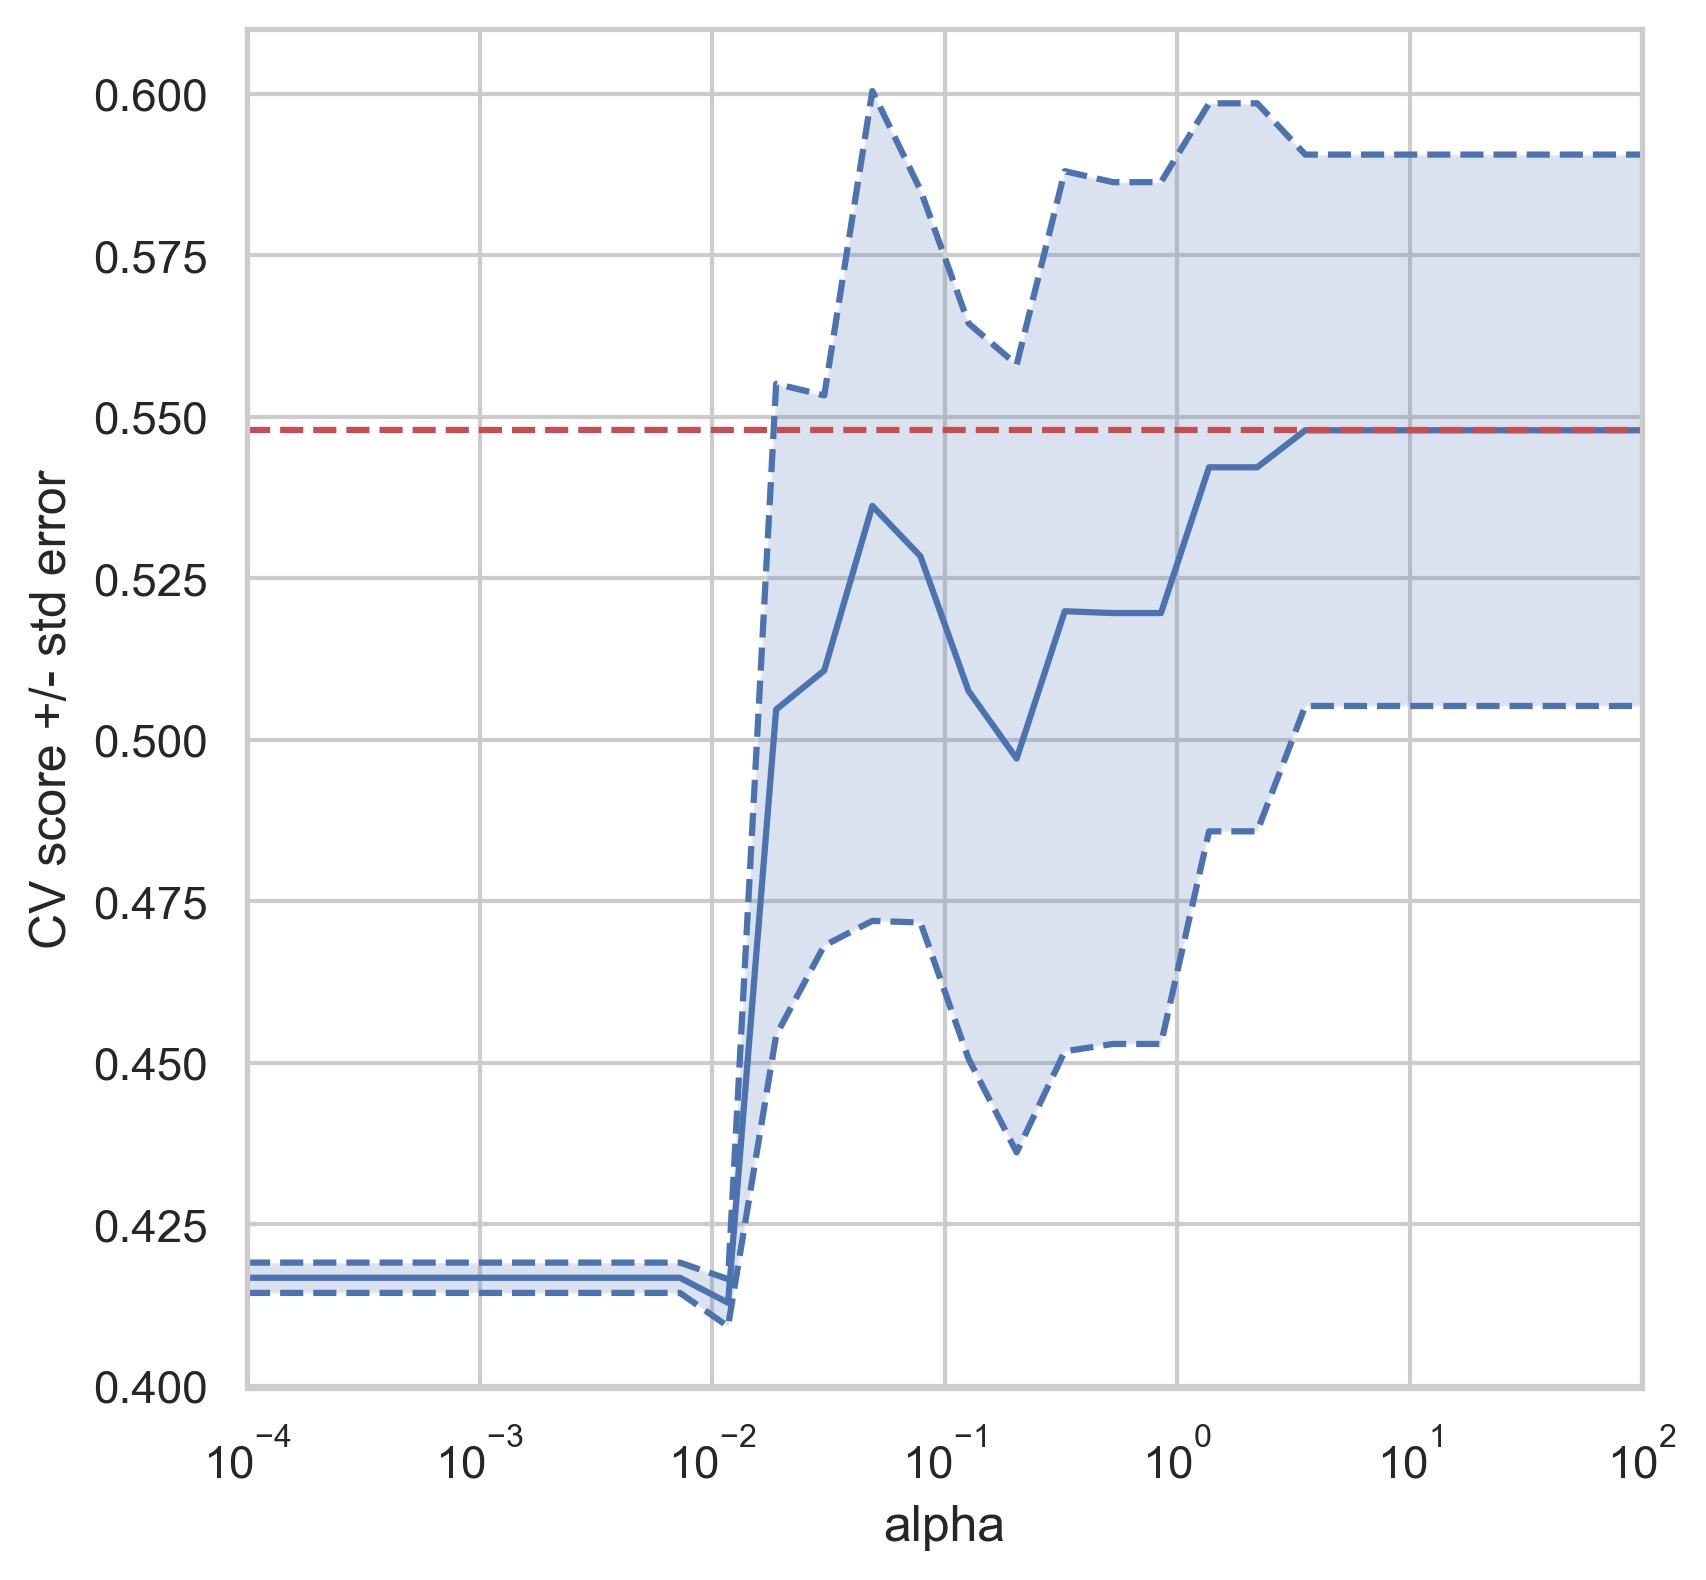

In [125]:
tmp = abdpain_all_clean.dropna()
X = tmp.loc[:,pred_cols]
yy = tmp.label
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)
clf = tune_model(X,y,5)

(81, 82) (81,)
AUC =  0.5566666666666666 0.0751588461722442
F1 =  0.5279933592977072 0.07996816940655409
Accuracy =  0.6176470588235294 0.09793499362219077
Confusion matrix:
[[55  2]
 [ 5 19]]
57  features chosen by L1 model.


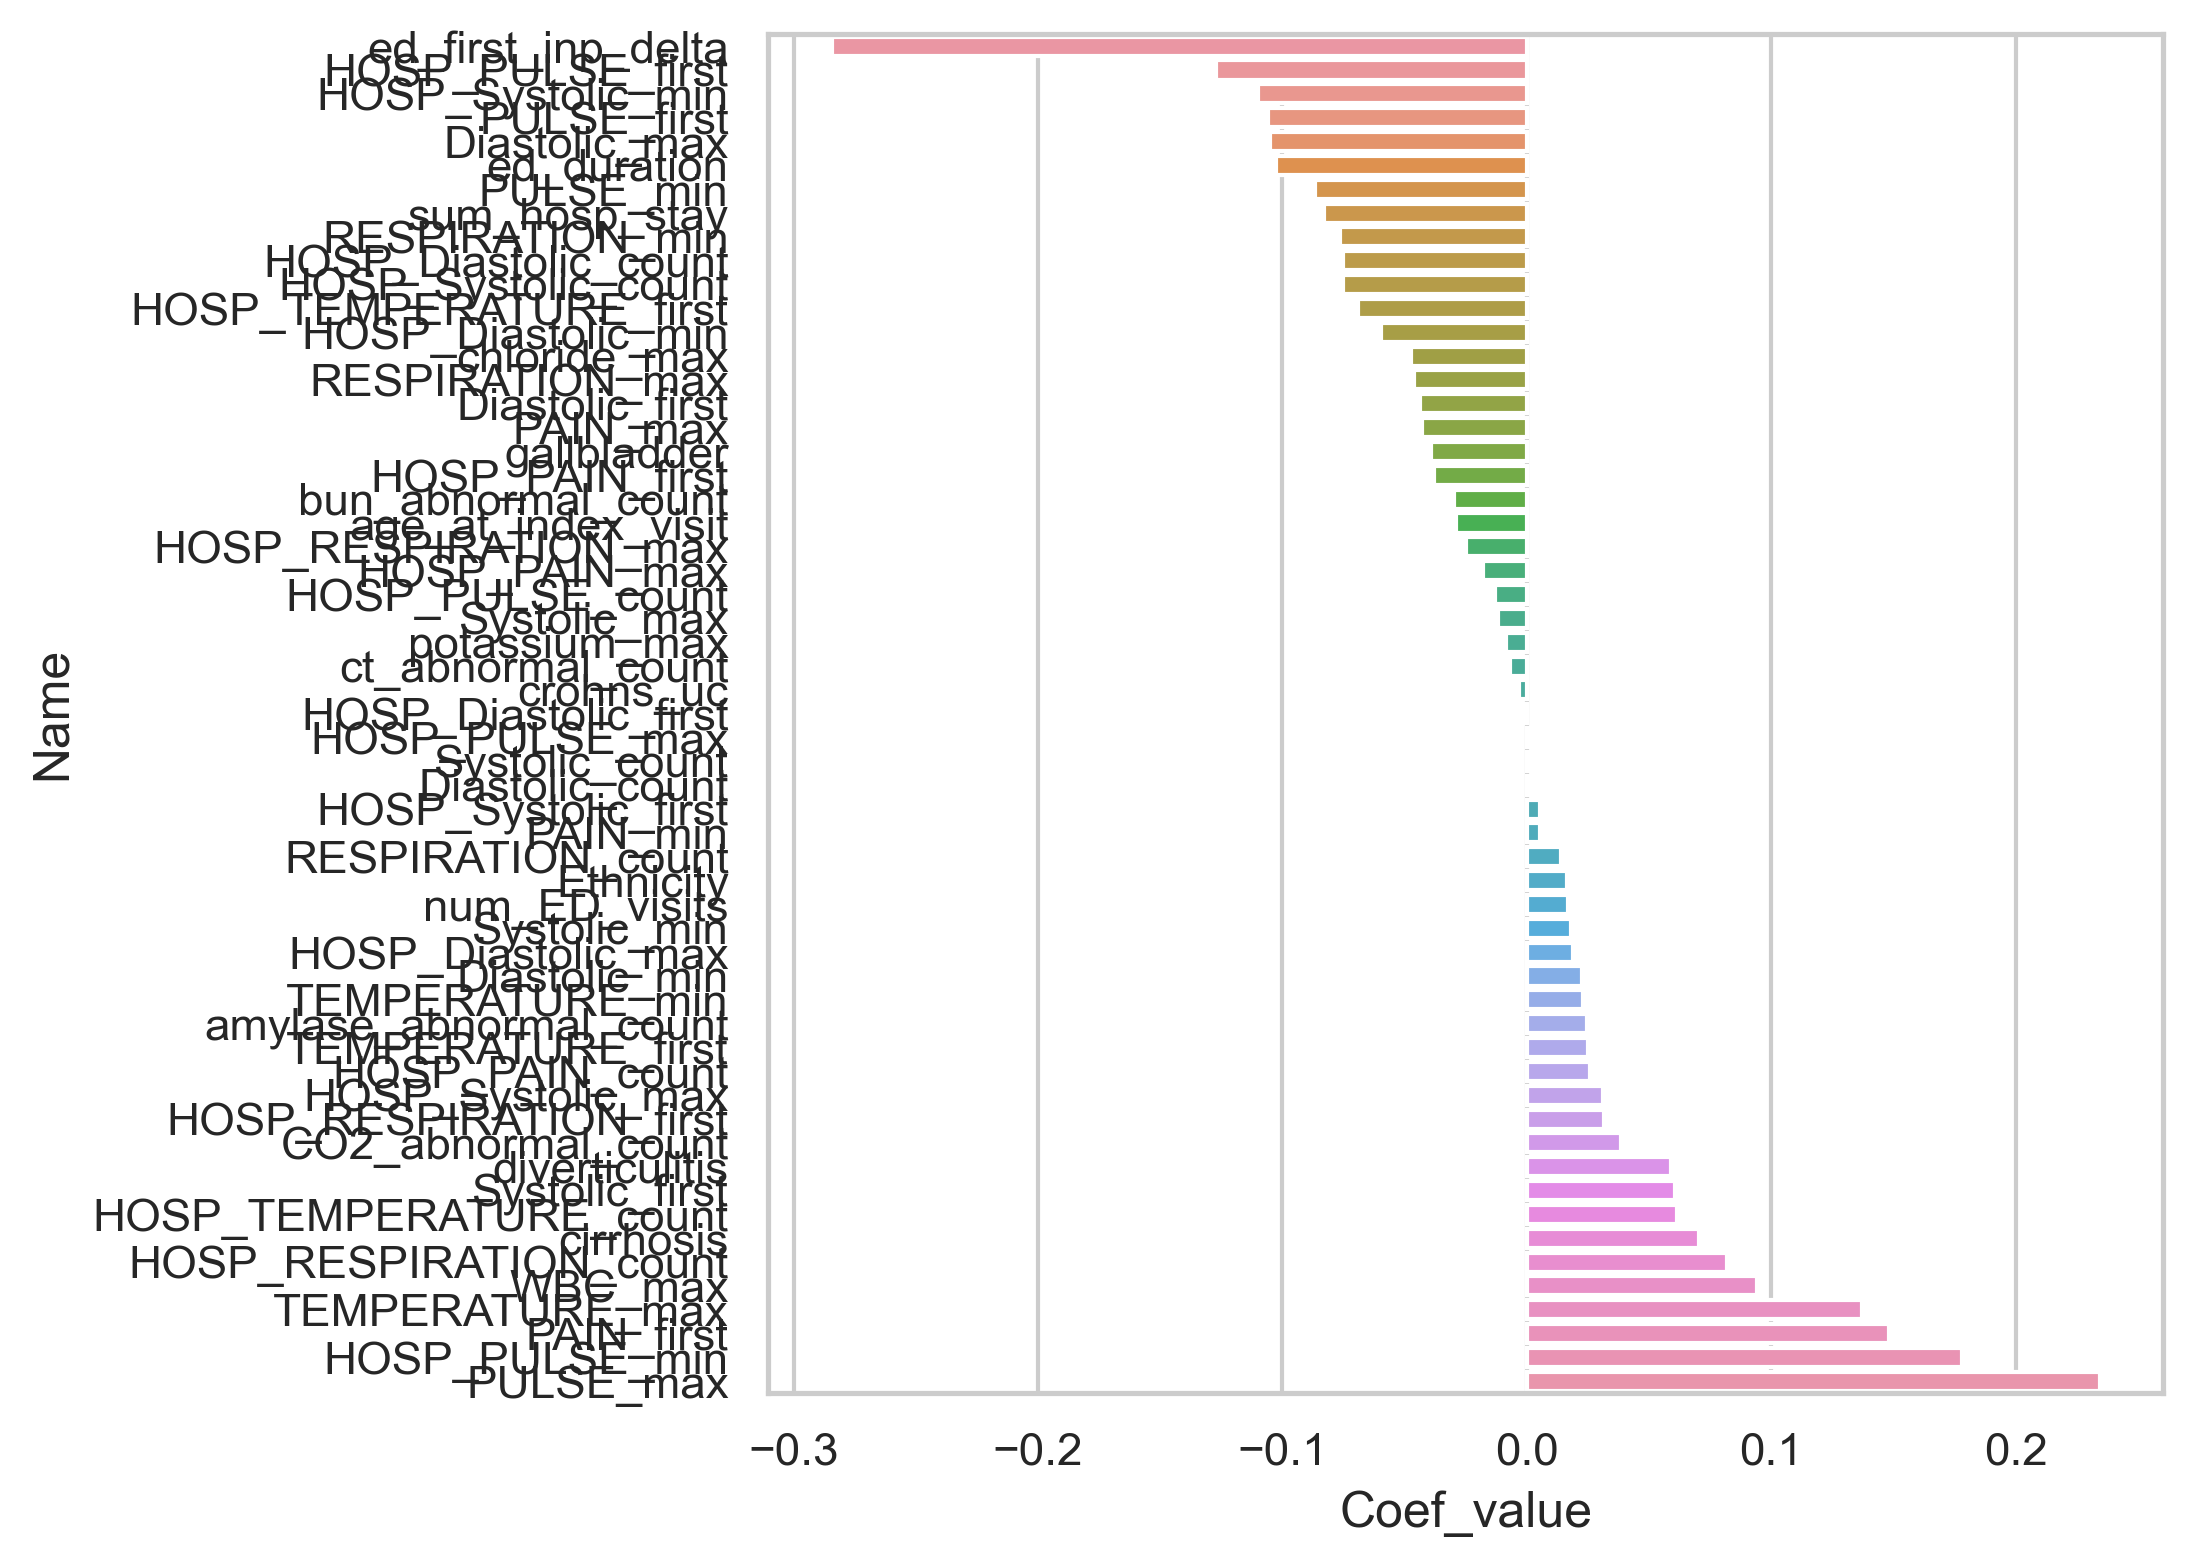

In [75]:
#clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
clf,select_feats = build_L1_model(X,y,1)
visualize_model(clf,select_feats)

In [143]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=4,max_depth=5)
y = np.array([1 if x=='MOD' else 0 for x in tmp.label])
rf.fit(tmp.iloc[:,2:],y)
ypred = rf.predict(tmp.iloc[:,2:])
metrics.confusion_matrix(y,ypred)

array([[64,  1],
       [ 2, 24]], dtype=int64)

C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


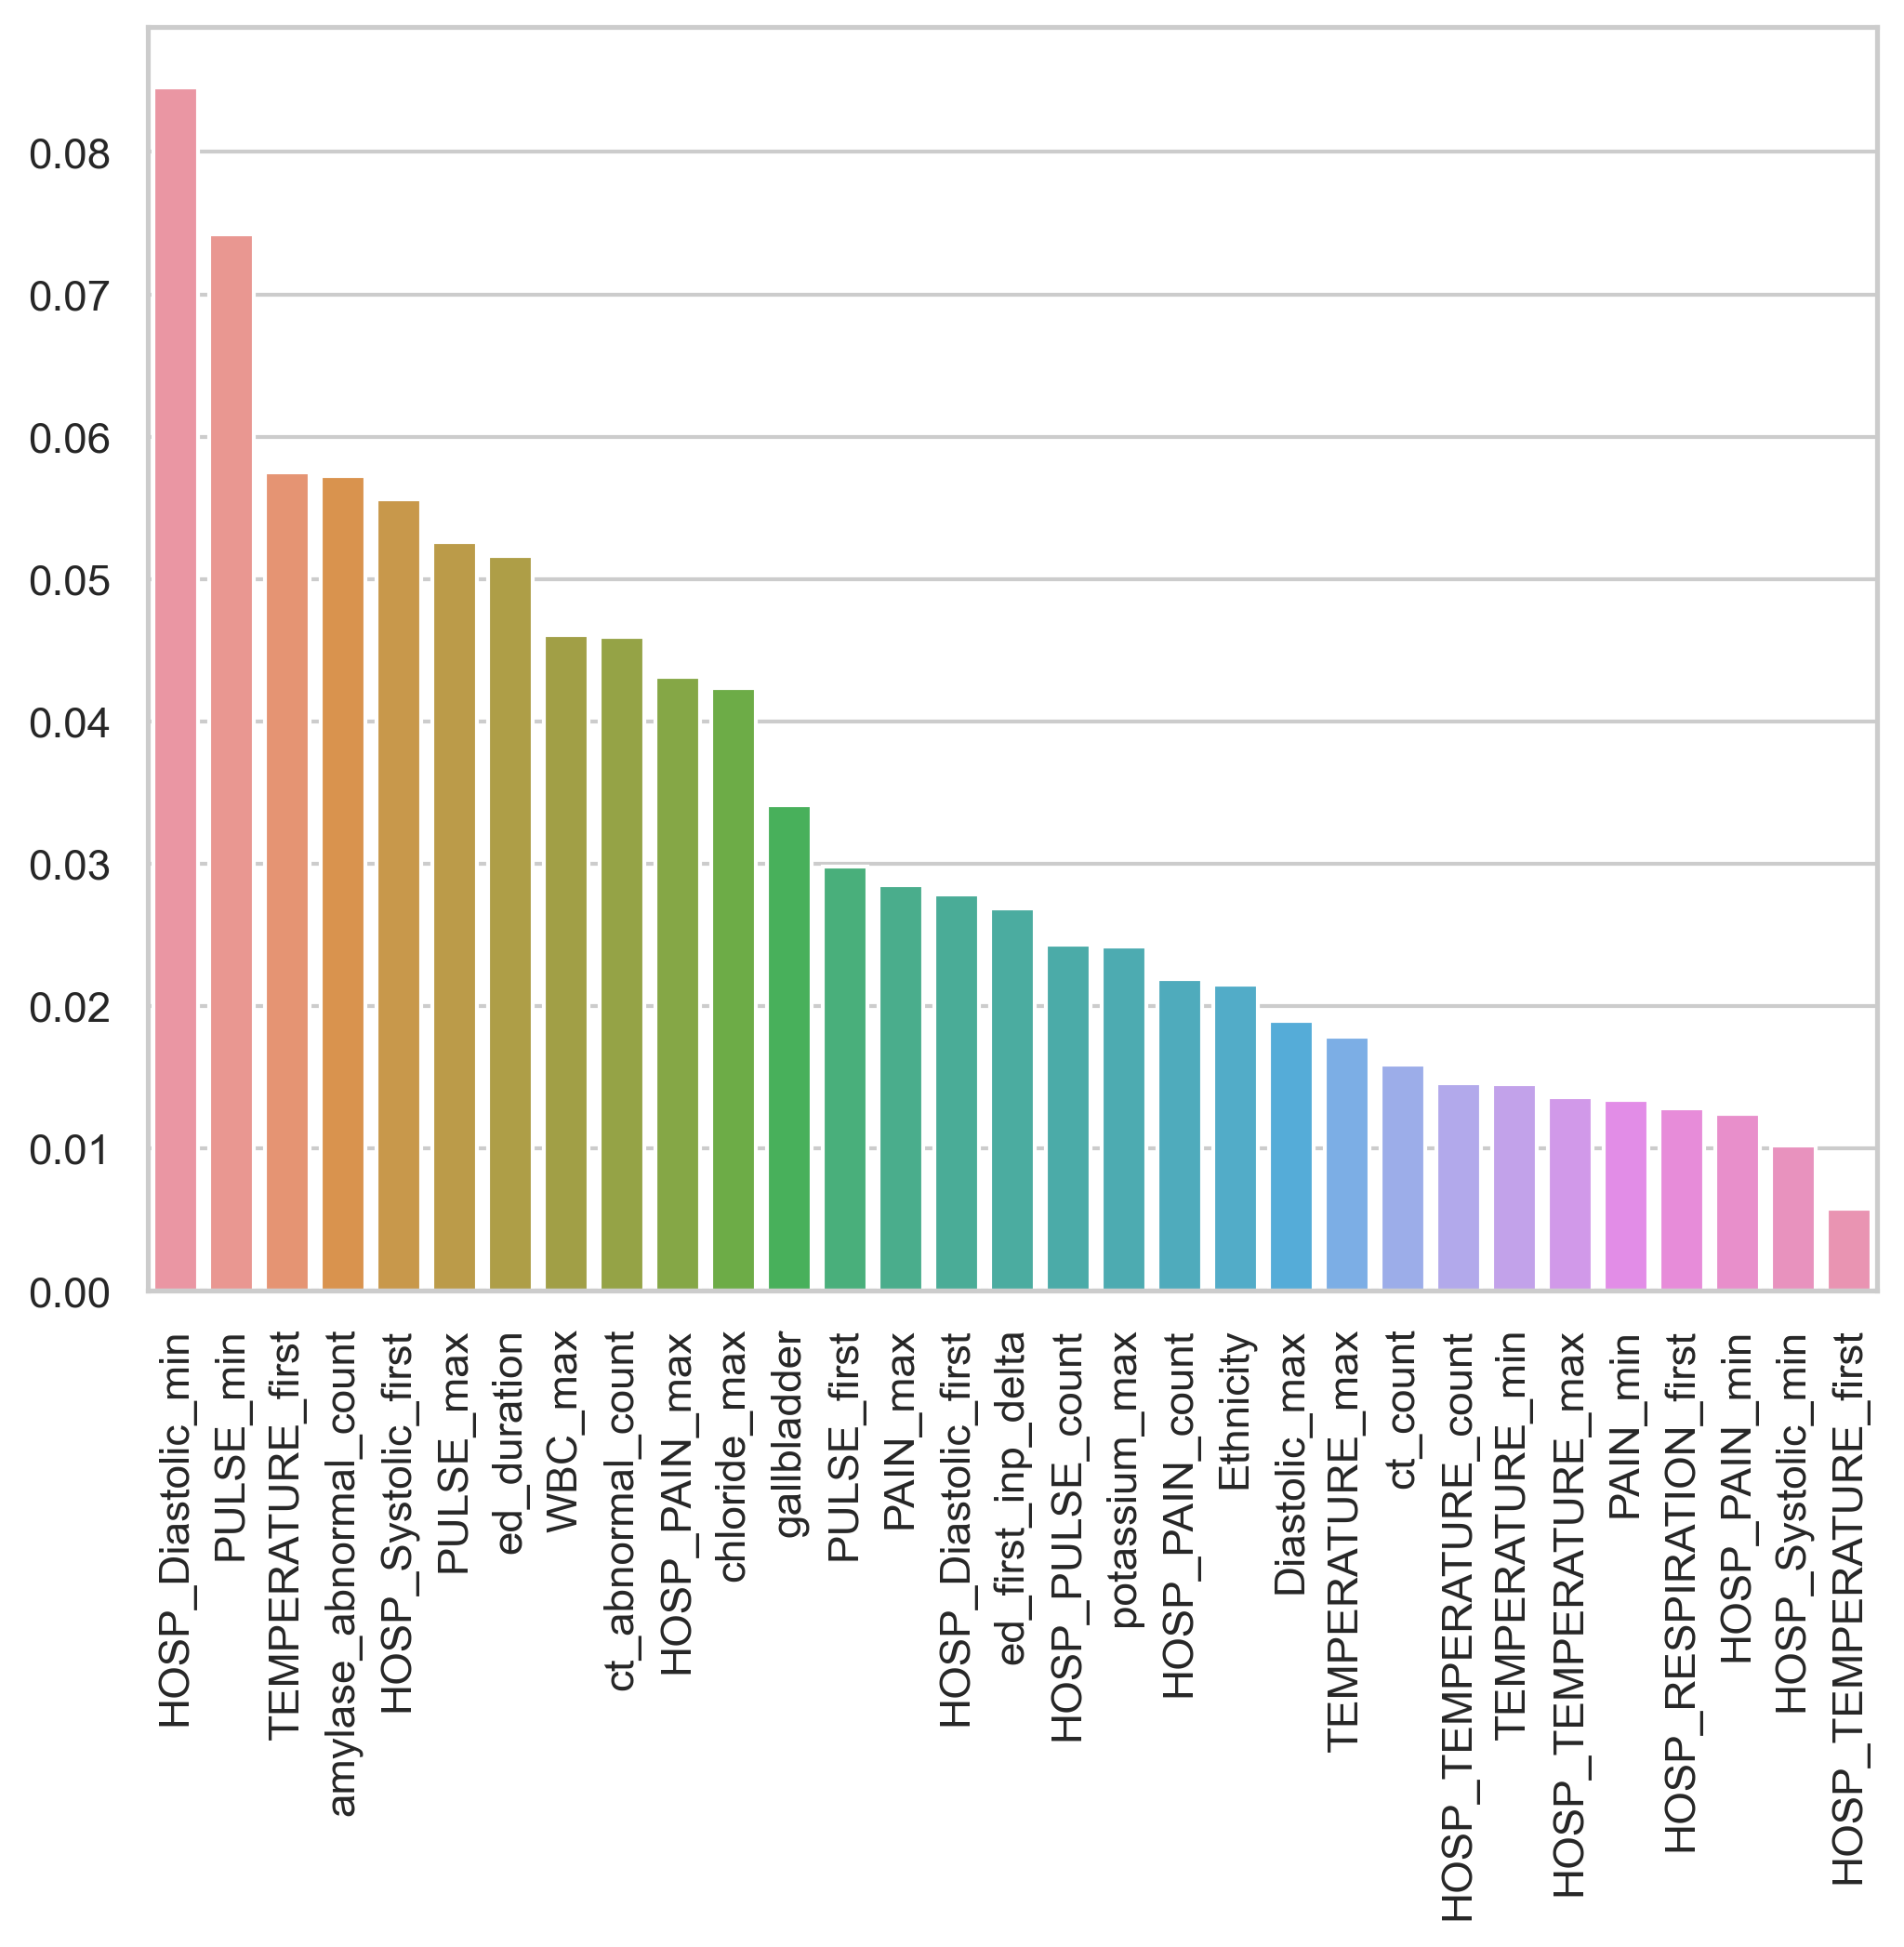

In [162]:
featimp = pd.Series(rf.feature_importances_,index=tmp.columns[2:]).sort_values(ascending=False)
featimp_nz = featimp[featimp > 0]
import seaborn as sns

plt.figure(figsize=(8,6))
myplot = sns.barplot(featimp_nz.index,featimp_nz.values)
myplot.set_xticklabels(myplot.get_xticklabels(),rotation = 90);

In [450]:
good_feats = featimp[featimp >= np.mean(featimp)].index

In [ ]:
# find those rows in abdpain_clean_all that are not in tmp
null_val_rows = abdpain_all_clean[abdpain_all_clean.isnull().any(axis=1)].copy()
null_val_rows

In [129]:
# potassium_max, chlrode_max, WBC_max, amylase_min, amylase_max filled with class-dependent medians
impval_dict = {}
for gcol in ['potassium_max','chloride_max','WBC_max']:
    vals = abdpain_all_clean.groupby('label')[gcol].describe()[['50%']].reset_index()
    mod_val = vals[vals.label=='MOD']['50%'].values[0]
    nomod_val = vals[vals.label=='NoMOD']['50%'].values[0]
    print(gcol,mod_val,nomod_val) 
    impval_dict[gcol]={'MOD':mod_val,'NoMOD':nomod_val}
    
for gcol in ['potassium_max','chloride_max','WBC_max']:
    null_val_rows.loc[null_val_rows.label=='MOD',gcol] = impval_dict[gcol]['MOD']
    null_val_rows.loc[null_val_rows.label=='NoMOD',gcol] = impval_dict[gcol]['NoMOD']
    

potassium_max 3.9 4.1
chloride_max 101.0 104.0
WBC_max 10.55 9.52


In [144]:
ytest = [1 if x=='MOD' else 0 for x in null_val_rows.label]
metrics.confusion_matrix(ytest,rf.predict(null_val_rows.iloc[:,2:]))

array([[7, 1],
       [3, 2]], dtype=int64)

In [145]:
ypred_all = rf.predict(pd.concat([tmp.iloc[:,2:],null_val_rows.iloc[:,2:]]))
y_all = [1 if x =='MOD' else 0 for x in tmp.label] + [1 if x=='MOD' else 0 for x in null_val_rows.label]
metrics.confusion_matrix(y_all,ypred_all)

array([[71,  2],
       [ 5, 26]], dtype=int64)

In [150]:
ypred_all_prob = rf.predict_proba(pd.concat([tmp.iloc[:,2:],null_val_rows.iloc[:,2:]]))[:,1]
print('AUC = ',metrics.roc_auc_score(y_all,ypred_all_prob))
print('F1 = ',metrics.f1_score(y_all,ypred_all))
print('AUPRC = ', metrics.precision_score(y_all,ypred_all))

AUC =  0.9447635881573133
F1 =  0.8813559322033899
AUPRC =  0.9285714285714286


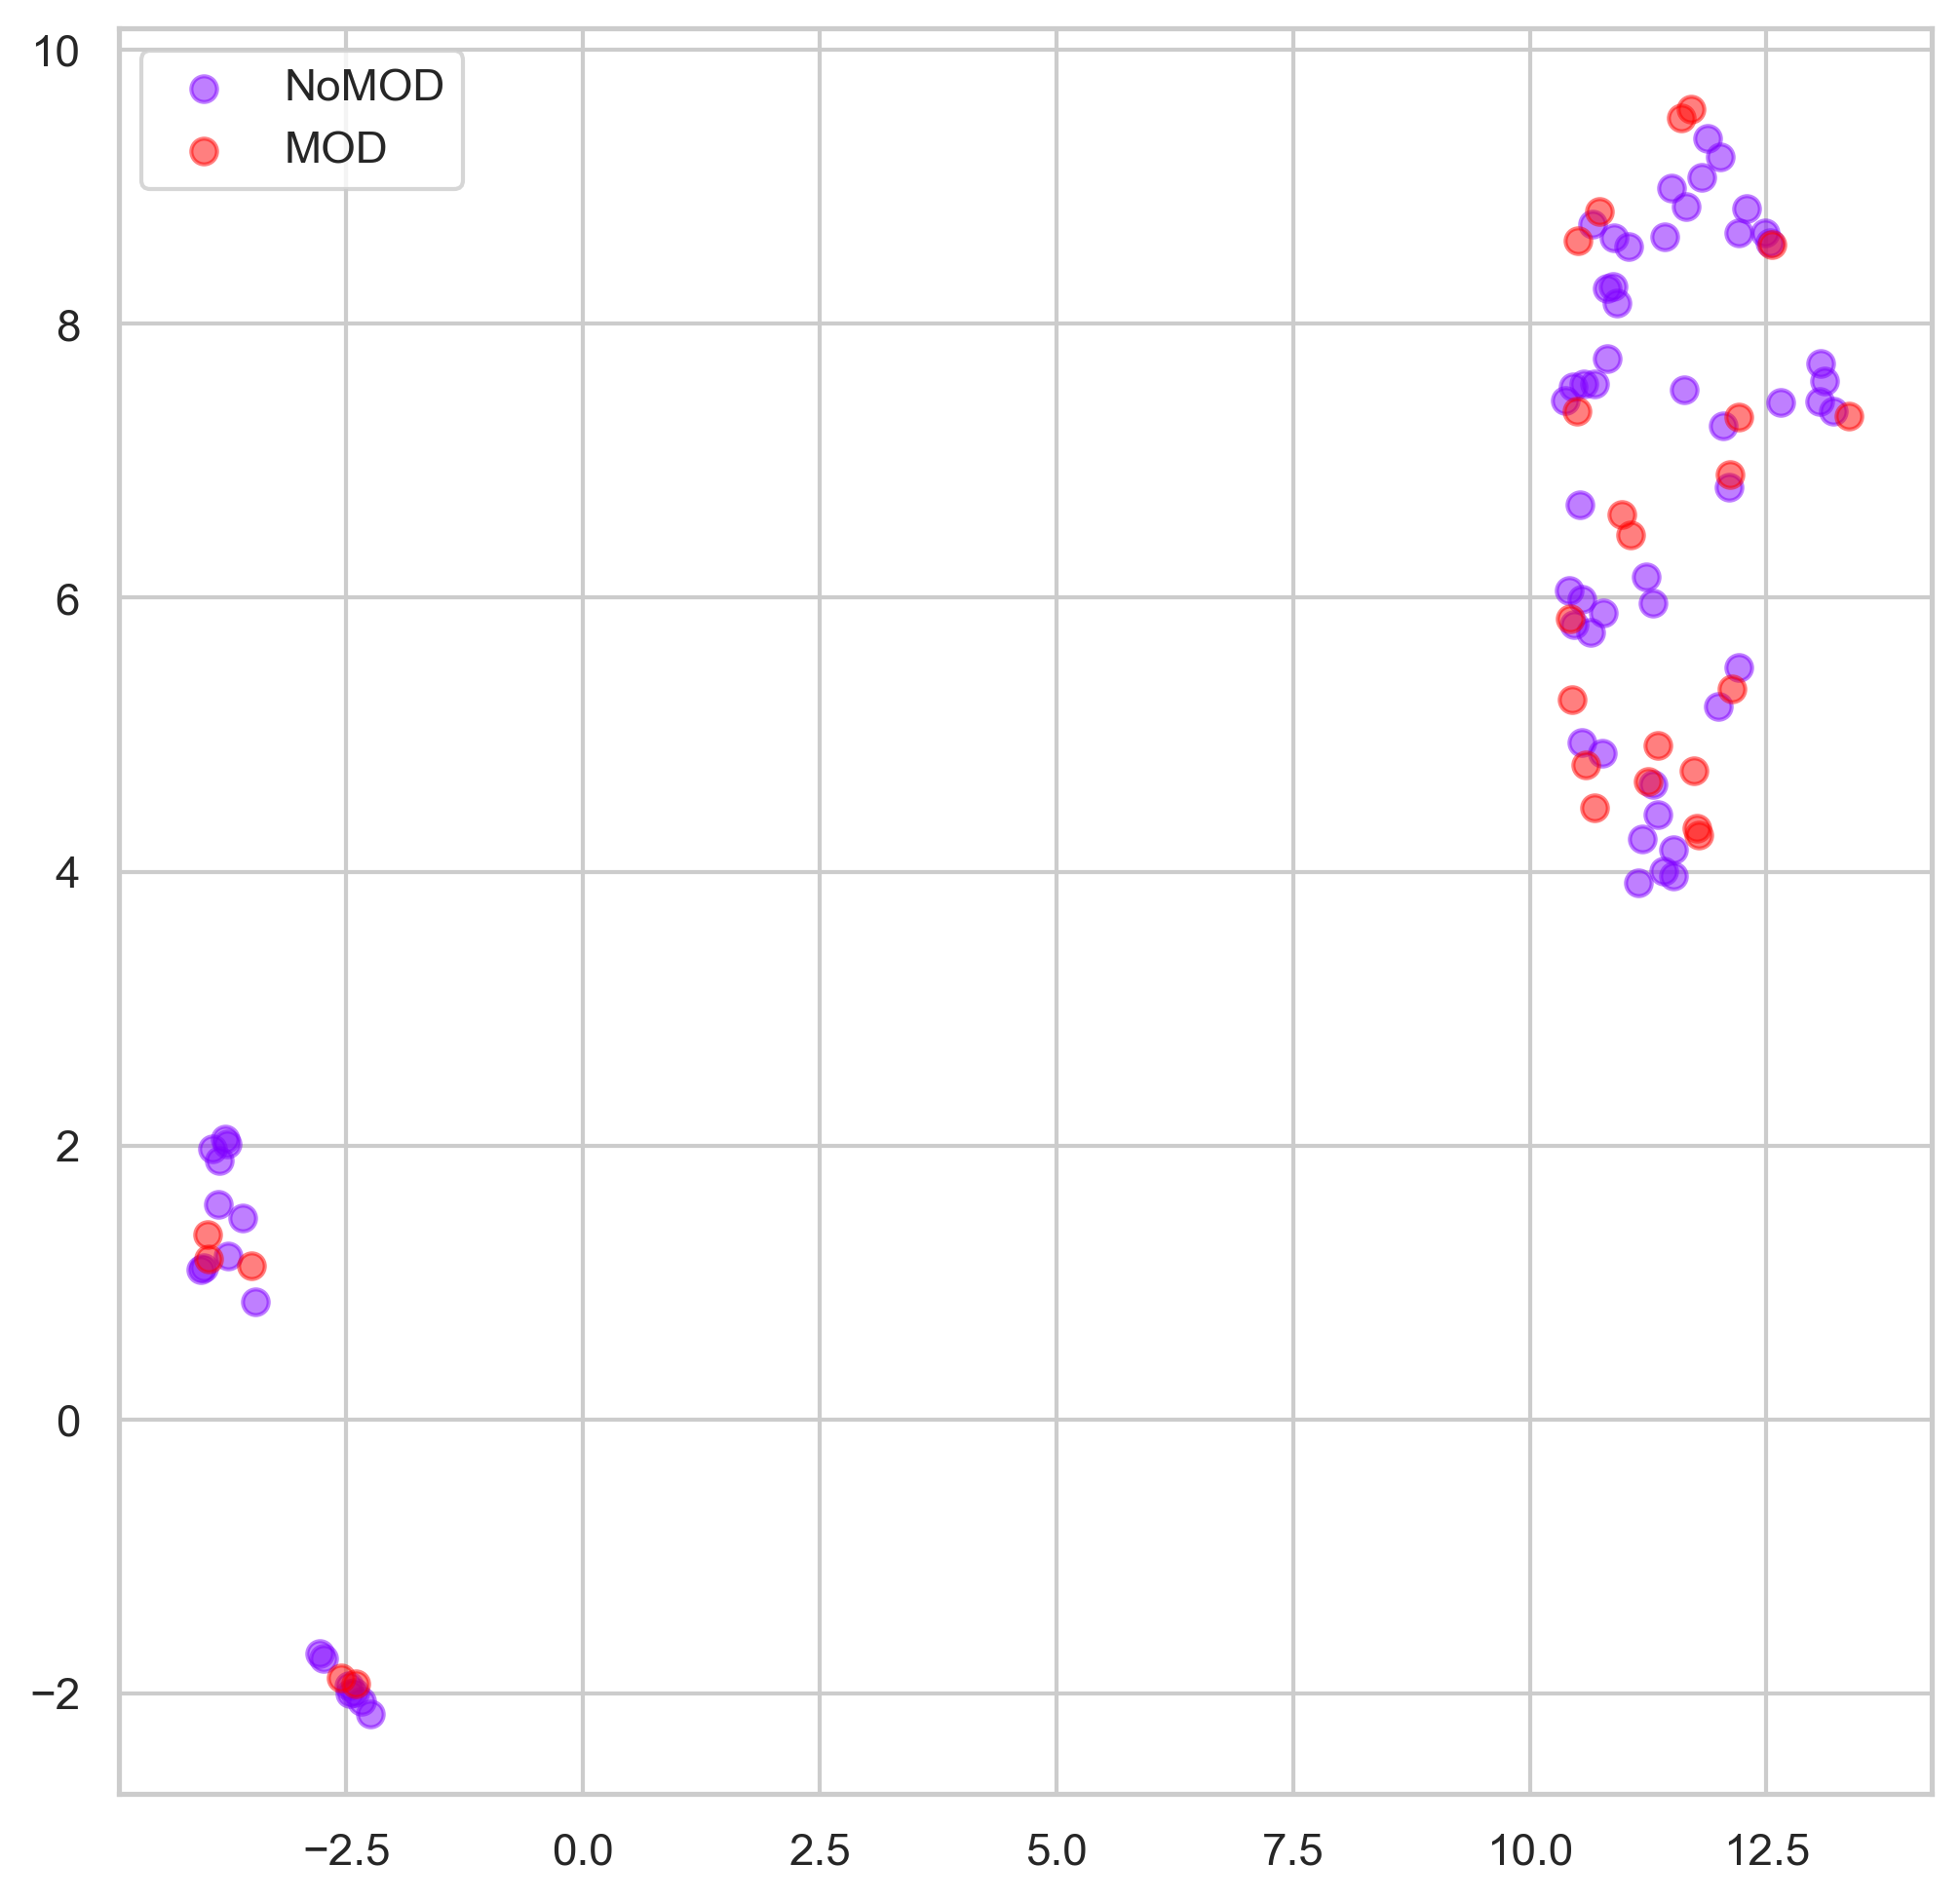

In [160]:
# umap it all
u = umap_plot_label(X,yy,1,5,['NoMOD','MOD'],'upper left')

Cluster  1
NoMOD    29
MOD       9
Name: label, dtype: int64
Cluster  2
NoMOD    17
MOD       5
Name: label, dtype: int64
Cluster  3
NoMOD    19
MOD      12
Name: label, dtype: int64


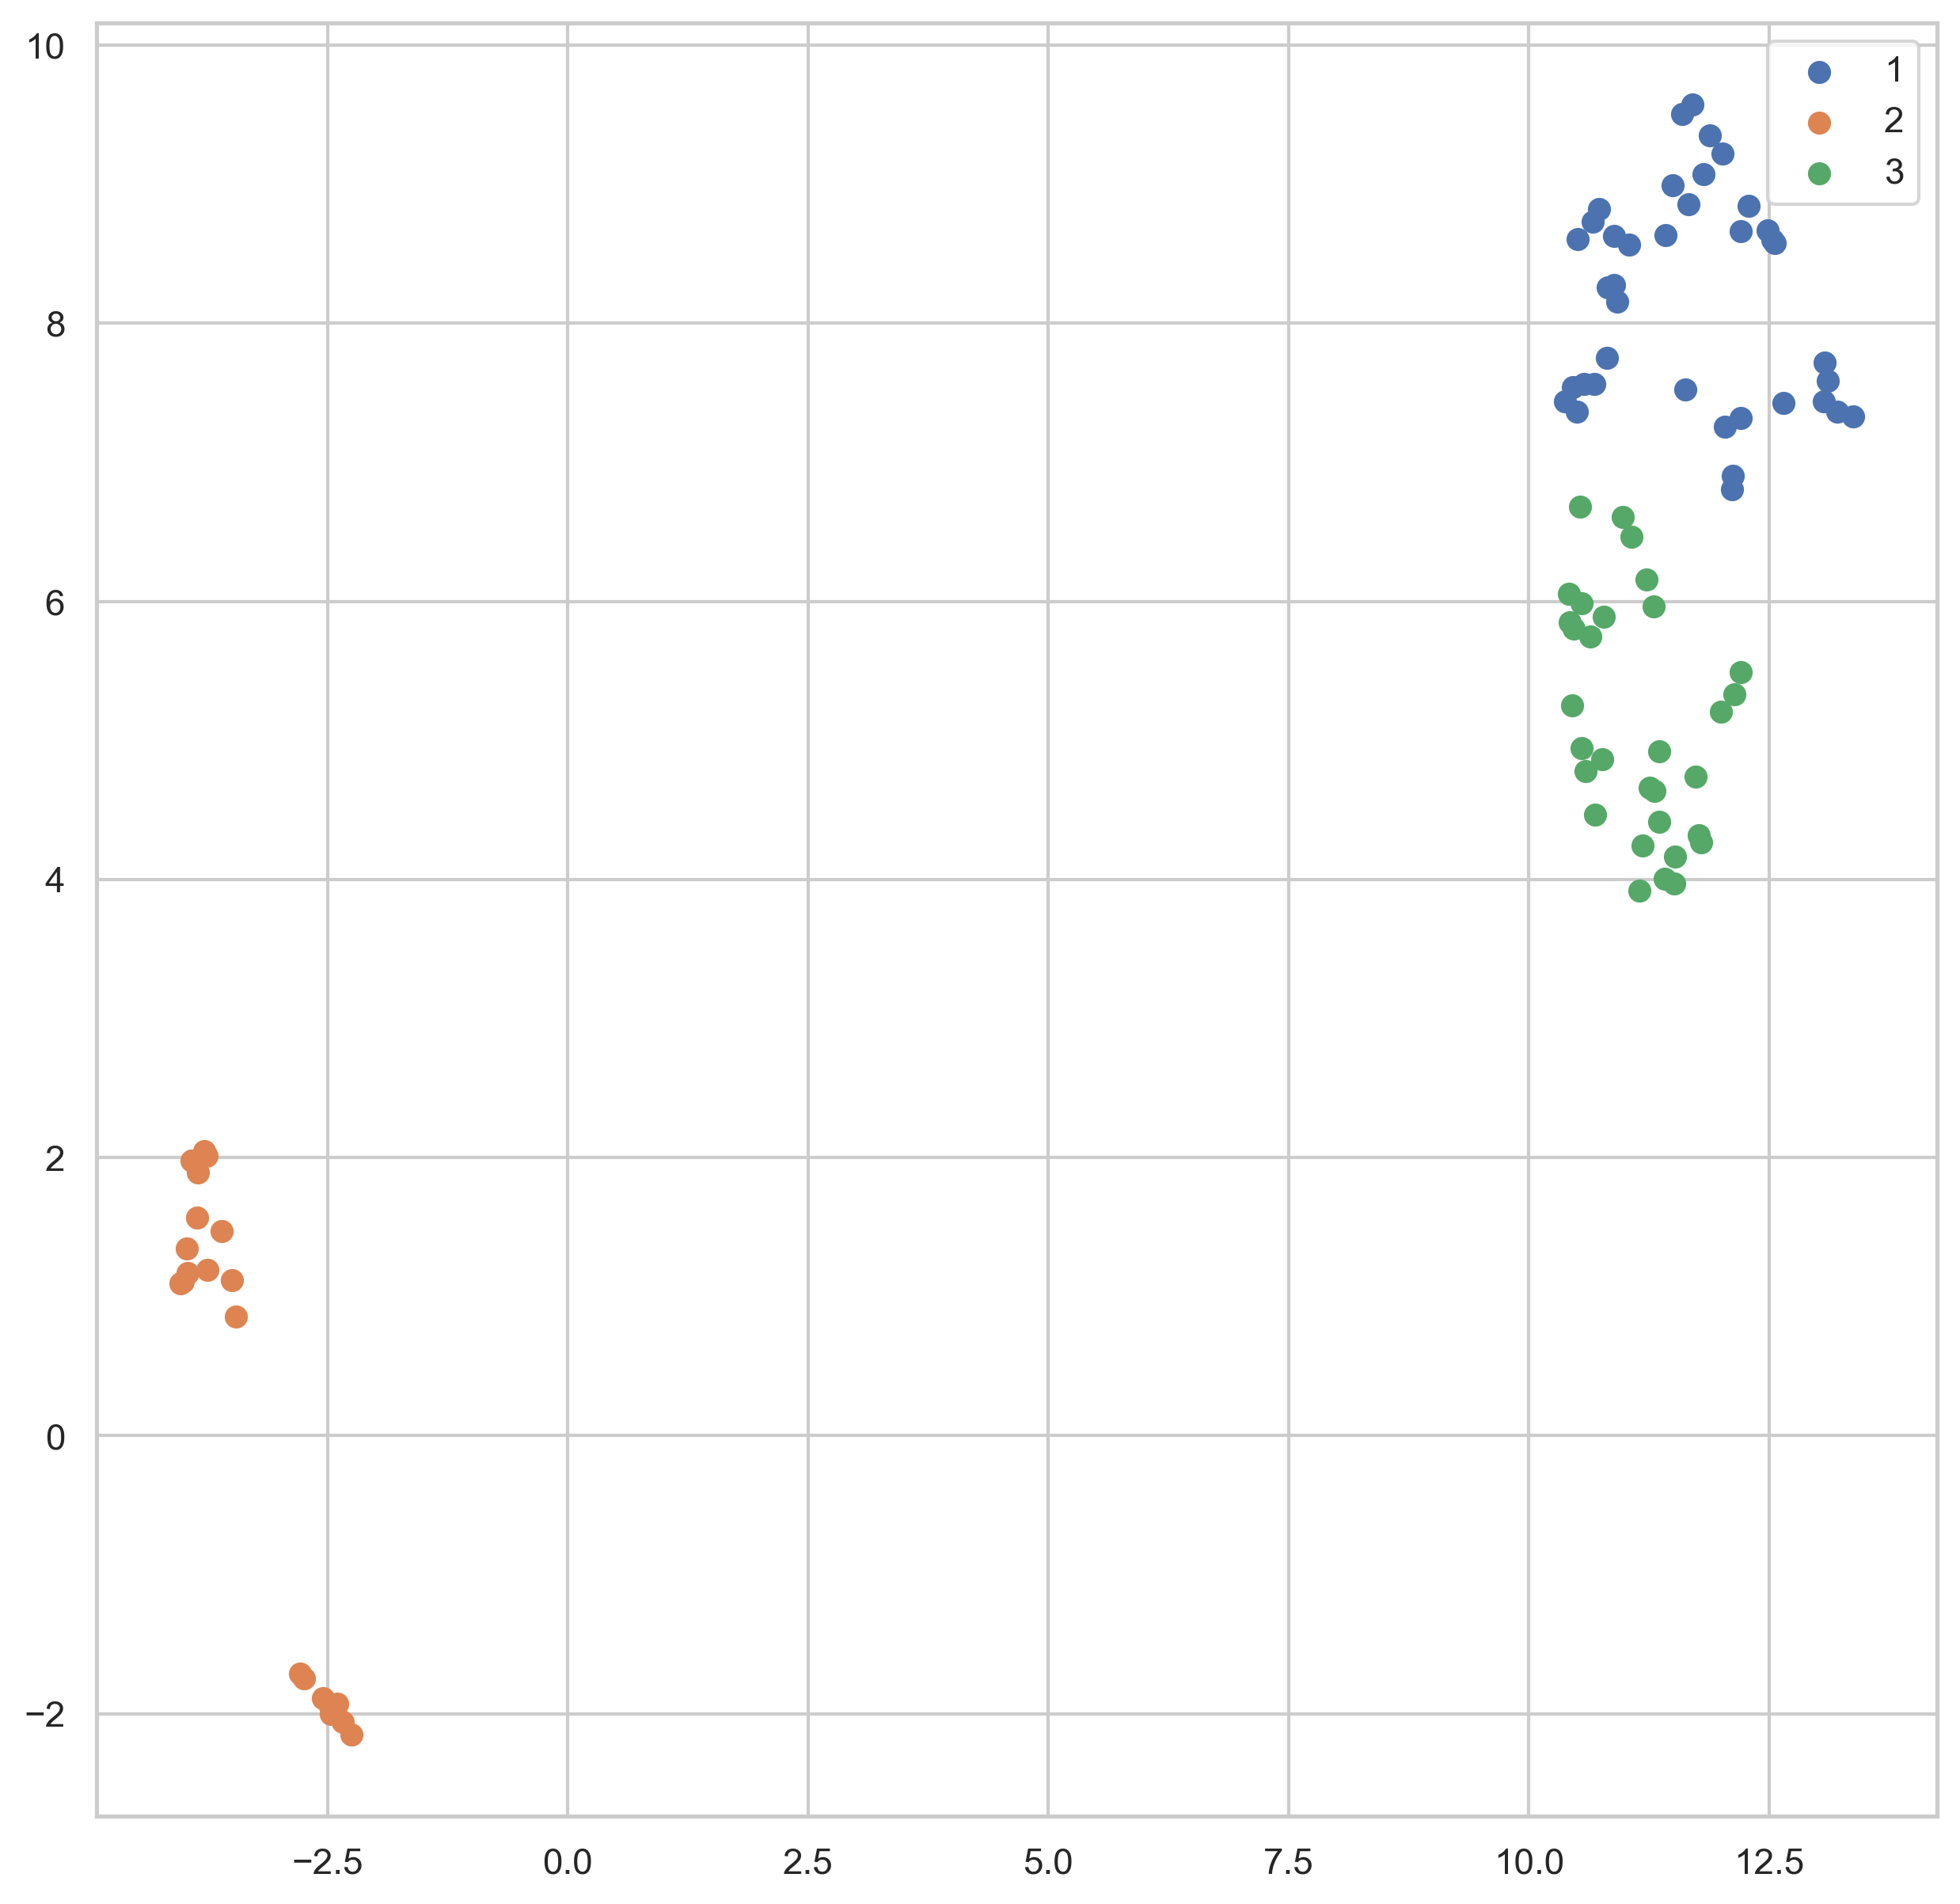

In [161]:
c = cluster_umap(u,3,tmp,'upper right')

In [164]:
stat_cols = featimp.iloc[:25].index
analyze_clusters(c,tmp,stat_cols)

median statistics of cluster  0
NoMOD    29
MOD       9
Name: label, dtype: int64


HOSP_Diastolic_min         62.500000
PULSE_min                  73.500000
TEMPERATURE_first          96.700000
amylase_abnormal_count      0.000000
HOSP_Systolic_first       132.500000
PULSE_max                  84.500000
ed_duration                 5.475417
WBC_max                     9.950000
ct_abnormal_count           0.000000
HOSP_PAIN_max               8.000000
chloride_max              103.000000
gallbladder                 0.000000
PULSE_first                82.500000
PAIN_max                    8.000000
HOSP_Diastolic_first       75.500000
ed_first_inp_delta          2.534323
HOSP_PULSE_count           11.000000
potassium_max               4.100000
HOSP_PAIN_count            16.500000
Ethnicity                   0.000000
Diastolic_max              91.500000
TEMPERATURE_max            97.650000
ct_count                    1.000000
HOSP_TEMPERATURE_count     11.000000
TEMPERATURE_min            96.700000
Name: 50%, dtype: float64

median statistics of cluster  1
NoMOD    17
MOD       5
Name: label, dtype: int64


HOSP_Diastolic_min         58.500000
PULSE_min                  75.500000
TEMPERATURE_first          98.150000
amylase_abnormal_count      0.000000
HOSP_Systolic_first       125.500000
PULSE_max                  90.000000
ed_duration                 5.286528
WBC_max                     9.335000
ct_abnormal_count           0.000000
HOSP_PAIN_max              99.000000
chloride_max              103.650000
gallbladder                 0.000000
PULSE_first                83.000000
PAIN_max                    8.000000
HOSP_Diastolic_first       76.000000
ed_first_inp_delta          2.946806
HOSP_PULSE_count           29.500000
potassium_max               4.250000
HOSP_PAIN_count            48.000000
Ethnicity                   0.000000
Diastolic_max              85.000000
TEMPERATURE_max            98.700000
ct_count                    1.000000
HOSP_TEMPERATURE_count     29.500000
TEMPERATURE_min            96.700000
Name: 50%, dtype: float64

median statistics of cluster  2
NoMOD    19
MOD      12
Name: label, dtype: int64


HOSP_Diastolic_min         65.000000
PULSE_min                  94.000000
TEMPERATURE_first          98.600000
amylase_abnormal_count      0.000000
HOSP_Systolic_first       126.000000
PULSE_max                 106.000000
ed_duration                 5.996667
WBC_max                     9.500000
ct_abnormal_count           0.000000
HOSP_PAIN_max               8.000000
chloride_max              102.000000
gallbladder                 0.000000
PULSE_first               103.000000
PAIN_max                    7.000000
HOSP_Diastolic_first       76.000000
ed_first_inp_delta          2.455139
HOSP_PULSE_count           12.000000
potassium_max               3.800000
HOSP_PAIN_count            16.000000
Ethnicity                   0.000000
Diastolic_max              85.000000
TEMPERATURE_max           100.000000
ct_count                    0.000000
HOSP_TEMPERATURE_count     11.000000
TEMPERATURE_min            98.500000
Name: 50%, dtype: float64